In [ ]:
import pandas as pd
import glob
import os
import time
import numpy as np
import math
import json
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install researchpy

In [ ]:
from pathlib import Path
import matplotlib.pyplot as plt
from itertools import combinations
from sklearn import cluster
from sklearn import metrics
import plotly.express as px
from sklearn.decomposition import PCA
import seaborn as sns
import statsmodels.api as sm
import researchpy as rp
import scipy.stats as stats

## Convert and filter sas7bdat ETF files into csv file

In [ ]:
criteria_list = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv') #From previous running
criteria_list = list(criteria_list['ETF'])
na_data_list = []
#5 min
folder_location = ['/content/drive/Shareddrives/RA SASIN/Raw data(Sas7bdat)/Data after response#1/2022-2023'] #@param {type:"string"}
etf_list = {}

for files_location in folder_location:
  files = glob.glob(os.path.join(files_location, "*.sas7bdat"))


  for f in files:
    db = pd.read_sas(f, encoding = 'latin8')

    if len(db) == 0:
      na_data_list.append(f.split(sep = '/')[-1])
      continue

    etf_name = db['SYM_ROOT'][0]

    if etf_name not in criteria_list: continue

    if etf_name not in etf_list:
      etf_list[etf_name] = [f]
    else:
      for loc in etf_list[etf_name]:
        if not db.equals(pd.read_sas(loc, encoding = 'latin8')):
          etf_list[etf_name].append(f)
print('Finish Find etf_list')


#Sort file
for etf in etf_list:
  etf_list[etf] = list(set(etf_list[etf]))
  etf_list[etf].sort()
print('Finish sorting')


Finish Find etf_list
Finish sorting


In [ ]:
# For next time running code

# Sample dictionary
data = etf_list

# Specify the directory and filename
directory = "/content/drive/Shareddrives/RA SASIN/Group time data/"
filename = "etf_list.json"

# Create the directory if it doesn't exist
os.makedirs(directory, exist_ok=True)

# Construct the full file path
filepath = os.path.join(directory, filename)

# Save the dictionary as a JSON file
with open(filepath, "w") as f:
    json.dump(data, f, indent=4)

### Get new etf_list

In [ ]:

# Specify the directory and filename
directory = "/content/drive/Shareddrives/RA SASIN/Group time data/"
filename = "etf_list.json"

# Construct the full file path
filepath = os.path.join(directory, filename)

# Load the JSON file into a dictionary
with open(filepath, "r") as f:
    etf_list = json.load(f)

print(etf_list)

{'ESGU': ['/content/drive/Shareddrives/RA SASIN/Raw data(Sas7bdat)/Data after response#1/2022-2023/esgu.sas7bdat', '/content/drive/Shareddrives/RA SASIN/Raw data(Sas7bdat)/Processed/After 06 08 2022 (From Mr.Olgun)/ETFData_Lot2/etf2.sas7bdat'], 'VB': ['/content/drive/Shareddrives/RA SASIN/Raw data(Sas7bdat)/Data after response#1/2022-2023/vb.sas7bdat', '/content/drive/Shareddrives/RA SASIN/Raw data(Sas7bdat)/Processed/After 06 08 2022 (From Mr.Olgun)/ETFData_Lot2/etf1.sas7bdat'], 'AIEQ': ['/content/drive/Shareddrives/RA SASIN/Raw data(Sas7bdat)/Data after response#1/2022-2023/aieq.sas7bdat', '/content/drive/Shareddrives/RA SASIN/Raw data(Sas7bdat)/Processed/After 06 08 2022 (From Mr.Olgun)/ETFData_Lot2/aieq.sas7bdat'], 'AMJ': ['/content/drive/Shareddrives/RA SASIN/Raw data(Sas7bdat)/Data after response#1/2022-2023/amj.sas7bdat', '/content/drive/Shareddrives/RA SASIN/Raw data(Sas7bdat)/Processed/After 06 08 2022 (From Mr.Olgun)/ETFData_Lot2/amj.sas7bdat'], 'AMLP': ['/content/drive/Share

### AUX CODE

In [ ]:
def CreateETFdf(etf,etf_file_location_list):
  df = pd.DataFrame({'SYM_ROOT':[], 'DATE':[], 'Int5M':[], 'Close':[], 'Volume':[]})
  for file_loc in etf_file_location_list[etf]:
    #df =  df.append(pd.read_sas(file_loc, encoding = 'latin8'))
    df = pd.concat([df,pd.read_sas(file_loc, encoding = 'latin8') ])
    df = df.sort_values(by = 'DATE', ascending = True, ignore_index = True)
  return df

def AdjMissingData(df, is_print_result = False):
  day = df['DATE'].unique()
  allday = np.repeat(day, 78) #แก้เป็น 78 ช่วง

  time = pd.timedelta_range(start='9:30:00', end='16:00:00', freq='5T') #แก้เป็น start 9:30:00

  time2 = []
  for j in range(0,len(time)):
    t = str(time[j])
    t = t[-8:]
    time2.append(t)

  Int5M = []
  for i in range(0,len(time2)-1):
    timer = time2[i] + '-' + time2[i+1]
    Int5M.append(timer)

  all5M = []
  for i in range(0,len(day)):
    for j in range(0,len(Int5M)):
      all5M.append(Int5M[j])

  allrange= pd.DataFrame()
  allrange['DATE'] = allday
  allrange['Int5M'] = all5M

  new_df = pd.merge(allrange, df,  how='left', left_on=['DATE','Int5M'], right_on = ['DATE','Int5M'])

  new_df['SYM_ROOT'] = new_df['SYM_ROOT'].fillna(method='ffill')
  new_df['SYM_ROOT'] = new_df['SYM_ROOT'].fillna(method='bfill')
  new_df['Volume'] = new_df['Volume'].fillna(0)

  if is_print_result:
    print('number of NaN in the first row: ',new_df[(new_df['Close'].isna() == True) & ((new_df['Int5M'] == '09:30:00-09:35:00') )].shape[0])
  return new_df

def AdjZERO(df, new_df, is_print_result = False):
  day = df['DATE'].unique()
  for d in range(0,len(day)):
    i = 78*d
    L = 1
    while ((math.isnan(new_df.iloc[i,3]) == True) and (L <= 78)):
      new_df.loc[i,'Close'] = 'ZERO'
      i+=1
      L+=1
  if is_print_result:
    print('number of ZERO: ',new_df[new_df['Close']=='ZERO'].shape[0])

  new_df['Close'] = new_df['Close'].fillna(method='ffill')
  return new_df

def AdjDateFormat(df):
  # adjust DATE format
  df['DATE'] = pd.to_datetime(df['DATE'],format='%Y-%m-%d')
  df['DD'] = df['DATE'].dt.day
  df['MM'] = df['DATE'].dt.month
  df['YY'] = df['DATE'].dt.year

  df['hh'] = df['Int5M'].str.slice(start=9, stop=11)
  df['min'] = df['Int5M'].str.slice(start=12, stop=14)

  df = df.drop(columns=['DATE','Int5M','SYM_ROOT'])
  df = df.rename(columns={"Close": "PRICE", "Volume": "SIZE"})
  col = ['DD','MM','YY','hh','min','SIZE','PRICE']
  df = df.reindex(columns=col)
  return df

def DFCriteria(df,criteria_percent):
  ## criteria del part
  df['DMY'] = df['DD'].astype(str)+'/'+df['MM'].astype(str)+'/'+df['YY'].astype(str)
  df['DMY'] = pd.to_datetime(df['DMY'], format = '%d/%m/%Y')
  u_date = df['DMY'].unique()

  for d in u_date:
    have_per = df[(df['SIZE'] != 0) & (df['DMY'] == d)].shape[0]
    all_per = df[df['DMY'] == d].shape[0]
    percent = have_per / all_per

    if percent < criteria_percent:
      df = df.drop(df[df['DMY'] == d].index, axis = 0)
  return df

def SEPPERIOD_WRITEFILE(sep_type,df, files_destination):
  if sep_type == 'normal':

    pre = df[df['DMY'] < '3/11/2020']
    num_pre = len(pre['DMY'].unique())
    pen = df[(df['DMY'] >= '3/11/2020') & (df['DMY'] <= '23/2/2022')]
    num_pen = len(pen['DMY'].unique())
    ur = df[df['DMY'] > '23/02/2022']
    num_ur = len(ur['DMY'].unique())

    pre = pre.drop('DMY', axis = 1)
    pen = pen.drop('DMY', axis = 1)
    ur = ur.drop('DMY', axis = 1)

    filename_pre = f'{files_destination}/{etf}-5min-data-pre.csv'
    filename_pen = f'{files_destination}/{etf}-5min-data-pen.csv'
    filename_ur  = f'{files_destination}/{etf}-5min-data-ur.csv'

    pre.to_csv(filename_pre,index = False)
    pen.to_csv(filename_pen, index = False)
    ur.to_csv(filename_ur, index = False)

    return num_pre,num_pen,num_ur

  elif sep_type == 'pew_research':

    normal = df[(df['DMY'] <= '15/3/2020')]
    num_normal = len(normal['DMY'].unique())
    first = df[(df['DMY'] > '15/3/2020') & (df['DMY'] <= '30/6/2020')]
    num_first = len(first['DMY'].unique())
    second = df[(df['DMY'] > '30/6/2020') & (df['DMY'] <= '30/9/2020')]
    num_second = len(second['DMY'].unique())
    third = df[(df['DMY'] >  '30/9/2020') & (df['DMY'] <= '31/3/2021')]
    num_third = len(third['DMY'].unique())
    fourth = df[(df['DMY'] >  '31/3/2021') & (df['DMY'] <= '31/7/2021')]
    num_fourth = len(fourth['DMY'].unique())
    fifth = df[(df['DMY'] >  '31/7/2021') & (df['DMY'] <= '30/11/2021')]
    num_fifth = len(fifth['DMY'].unique())
    omi = df[(df['DMY'] >  '30/11/2021') & (df['DMY'] <= '23/2/2022')]
    num_omi = len(omi['DMY'].unique())
    ur = df[df['DMY'] > '23/02/2022']
    num_ur = len(ur['DMY'].unique())

    normal = normal.drop('DMY', axis = 1)
    first = first.drop('DMY', axis = 1)
    second = second.drop('DMY', axis = 1)
    third = third.drop('DMY', axis = 1)
    fourth = fourth.drop('DMY', axis = 1)
    fifth = fifth.drop('DMY', axis = 1)
    omi = omi.drop('DMY', axis = 1)
    ur = ur.drop('DMY', axis = 1)


    filename_normal = f'{files_destination}/{etf}-5min-data-normal.csv'
    filename_first = f'{files_destination}/{etf}-5min-data-first.csv'
    filename_second = f'{files_destination}/{etf}-5min-data-second.csv'
    filename_third = f'{files_destination}/{etf}-5min-data-third.csv'
    filename_fourth = f'{files_destination}/{etf}-5min-data-fourth.csv'
    filename_fifth = f'{files_destination}/{etf}-5min-data-fifth.csv'
    filename_omi = f'{files_destination}/{etf}-5min-data-omi.csv'
    filename_ur = f'{files_destination}/{etf}-5min-data-ur.csv'

    normal.to_csv(filename_normal,index = False)
    first.to_csv(filename_first,index = False)
    second.to_csv(filename_second, index = False)
    third.to_csv(filename_third, index = False)
    fourth.to_csv(filename_fourth, index = False)
    fifth.to_csv(filename_fifth, index = False)
    omi.to_csv(filename_omi, index = False)
    ur.to_csv(filename_ur, index = False)

    return num_normal, num_first, num_second, num_third, num_fourth, num_fifth, num_omi, num_ur


### Filter some etf with criteria to get new List of etf

In [ ]:
sep_pendemic = True
sep_type = 'normal'#'pew_research' , 'normal'
x = 1
files_destination = "/content/drive/Shareddrives/RA SASIN/Group time data/5min_3period_after_response#1" #@param {type:"string"}
count = 0
num_data = pd.DataFrame()
all_etf = []

all_pre = []
all_pen = []

all_normal = []
all_first = []
all_second = []
all_third = []
all_fourth = []
all_fifth = []
all_omi = []
all_ur = []
#etf_list = {'XHE': etf_list['XHE']}
criteria_percent = 0.75#@param {type:"number"}


  #Read file
for etf in etf_list:

  df = CreateETFdf(etf,etf_list)

  new_df = AdjMissingData(df)

  df = AdjZERO(df,new_df)

  df = AdjDateFormat(df)

  ## adjust first Nan row part
  #index = df[np.isnan(df['PRICE']) == True].shape[0]
  #df.drop([i for i in range(index)],axis = 0,inplace = True)

  df = DFCriteria(df, criteria_percent)


  ##write file part
  days = len(df['DMY'].unique())
  criteria_days = 500 #@param {type:"integer"}
  if days > criteria_days:
    count+=1
    if sep_pendemic:
      if sep_type == 'normal':
        pre,pen,ur = SEPPERIOD_WRITEFILE(sep_type,df, files_destination)
        all_pre.append(pre)
        all_pen.append(pen)
        all_ur.append(ur)
      elif sep_type == 'pew_research':
        normal, first,second,third,fourth,fifth,omi,ur = SEPPERIOD_WRITEFILE(sep_type,df, files_destination)
        all_normal.append(normal)
        all_first.append(first)
        all_second.append(second)
        all_third.append(third)
        all_fourth.append(fourth)
        all_fifth.append(fifth)
        all_omi.append(omi)
        all_ur.append(ur)
      all_etf.append(etf)
      print(f'{x}.{etf} file is finished written')
    else:
      df = df.drop('DMY', axis = 1)
      filename =  files_destination+'/'+ etf + '-5min-data.csv'
      df.to_csv(filename, index = False)
      print(f'{x}.{etf} has total {days} days and been written')
    x+=1
  else:
    print(f'{x}.{etf} has total {days} days and will not be wrote')
    x+=1

num_data['ETF'] = all_etf
if sep_type =='normal':
  num_data['Num_Pre'] = all_pre
  num_data['Num_Pen'] = all_pen
  num_data['Num_Ur'] = all_ur
elif sep_type == 'pew_research':
  num_data['Num_Normal'] = all_normal
  num_data['Num_First'] = all_first
  num_data['Num_Second'] = all_second
  num_data['Num_Third'] = all_third
  num_data['Num_Fourth'] = all_fourth
  num_data['Num_Fifth'] = all_fifth
  num_data['Num_Omi'] = all_omi
  num_data['Num_Ur'] = all_ur
print(f'total etfs which were written are: {count}')
num_data

1.ESGU file is finished written
2.VB file is finished written
3.AIEQ file is finished written
4.AMJ file is finished written
5.AMLP file is finished written
6.AMZA file is finished written
7.ARKG file is finished written
8.ARKK file is finished written
9.ARKQ file is finished written
10.ARKW file is finished written
11.BBH file is finished written
12.BIZD file is finished written
13.CDC file is finished written
14.CFO file is finished written
15.CIBR file is finished written
16.CLOU file is finished written
17.DES file is finished written
18.DFE file is finished written
19.DGRO file is finished written
20.DGRW file is finished written
21.DHS file is finished written
22.DIA file is finished written
23.DIV file is finished written
24.DLN file is finished written
25.DON file is finished written
26.DSI file is finished written
27.DVY file is finished written
28.EES file is finished written
29.EMLP file is finished written
30.EPOL file is finished written
31.ESGV file is finished written
32

,ETF,Num_Pre,Num_Pen,Num_Ur
0,ESGU,92,491,462
1,VB,544,492,462
2,AIEQ,323,367,240
3,AMJ,544,491,462
4,AMLP,544,491,462
...,...,...,...,...
259,XSD,540,491,462
260,XSLV,544,491,443
261,XSW,198,484,327
262,XT,539,491,462


In [ ]:
num_data.to_csv('/content/drive/Shareddrives/RA SASIN/Group time data/num_data_3period_after_response#1.csv', index = False)

# Estimate jump variable

### Available Jumptest

In [ ]:
def BNStest(rt):
    M=max(rt.shape)
    RV=sum([i**2 for i in rt])
    abs_r=[abs(i) for i in rt]
    BV=(math.pi/2)*((M)/(M-1))*sum([abs_r[i] * abs_r[i+1] for i in range(len(abs_r)-1)])

    c=((2**(2/3))*math.gamma(7/6)*(math.gamma(1/2)**(-1/1)))**(-3)
    #TP1=sum((abs_r[2:]**(4/3))*(abs_r[1:-1]**(4/3))*(abs_r[0:-2]**(4/3)))
    TP1 = sum([((abs_r[i])**(4/3)*(abs_r[i+1])**(4/3)*(abs_r[i+2])**(4/3)) for i in range(len(abs_r)-2)])
    TP=c*((M**2)/(M-2))*TP1

    RJ=(RV-BV)/RV
    V=((math.pi/2)**2+math.pi-5)*max(1,(TP/(BV**2)))/M
    BNS=RJ/math.sqrt(V)

    return RV,BV,BNS,TP

def MINRVtest(rt):
  M=max(rt.shape)
  RV=sum([i**2 for i in rt])
  abs_r=[abs(i) for i in rt]
  MinRV = (math.pi/(math.pi -2)) * (M/(M-1)) * sum([(min(abs_r[i], abs_r[i+1]))**2 for i in range(len(abs_r)-1)])
  MinRQ = (math.pi/(3*math.pi -8)) * (M**2/(M-1)) * sum([(min(abs_r[i],abs_r[i+1]))**4 for i in range(len(abs_r)-1)])
  Tmin = (1-(MinRV/RV))/math.sqrt(1.81 * (M**-1) * max(1,(MinRQ/(MinRV)**2)))
  return RV, Tmin, MinRV, MinRQ

def MEDRVtest(rt):
  M=max(rt.shape)
  RV=sum([i**2 for i in rt])
  abs_r=[abs(i) for i in rt]
  MedRV = (math.pi/(math.pi+6 - (4*3**(1/2)))) * (M/(M-2)) * sum([(statistics.median([abs_r[i],abs_r[i+1],abs_r[i+2]]))**2 for i in range(len(abs_r) - 2)])
  MedRQ = (3*math.pi/(9*math.pi +72-(52*(3**(1/2))))) * (M**2/(M-2)) * sum([(statistics.median([abs_r[i], abs_r[i+1], abs_r[i+2]]))**4 for i in range(len(abs_r)-2)])
  Tmed = (1-(MedRV/RV))/math.sqrt(0.96*(M**-1) * max(1,MedRQ/(MedRV**2)))
  return RV, Tmed, MedRV, MedRQ


##### auxiliary code

In [ ]:
def GetNumDay(df_date_month_year):
  df = df_date_month_year
  date_month_year = df[['DD', 'MM','YY']]
  unique_date = date_month_year.drop_duplicates()
  sort_unique_date = unique_date.sort_values(['YY','MM','DD'])
  sort_unique_date.index = np.arange(0,len(sort_unique_date))
  number_of_days = len(sort_unique_date)
  return number_of_days, sort_unique_date

def FindL(df, sort_unique_date, i):
  layer1_test = [sort_unique_date.loc[i,'DD']]
  layer2_test = [sort_unique_date.loc[i,'MM']]
  layer3_test = [sort_unique_date.loc[i,'YY']]

  layer1 = np.isin(df["DD"],layer1_test)
  layer1.astype(int)
  layer1 = df[layer1]

  layer2 = np.isin(layer1["MM"],layer2_test)
  layer2.astype(int)
  layer2 = layer1[layer2]

  layer3 = np.isin(layer2["YY"],layer3_test)
  layer3.astype(int)
  layer3 = layer2[layer3]
  L = len(layer3)
  # Check if L is valid before returning
  if L <= 1:
    print(f"Warning: L is {L} for index {i}. This might cause issues.") # Added a warning message
  return L, layer3

def GetSign(layer3, rt, L):
  max_abs_rt = 0
  for x in range(L-1):
    #handle error##
    if any([layer3.iloc[x+1,6] == "ZERO", layer3.iloc[x,6] == 'ZERO']):
      rt[x] = 0
    else:
      rt[x] = (math.log(float(layer3.iloc[x+1,6]))-math.log(float(layer3.iloc[x,6]))) # Using price

    #statistic part
        # find max abs(rt) for sign
    if abs(rt[x]) > abs(max_abs_rt):
        max_abs_rt = rt[x]
  #get sign
  if max_abs_rt >= 0:
    sign = 1
  else: sign = -1
  return sign, rt

def ResultColName(method):
  if method == 'BNS':
    col_names = ['BNS', 'RV', 'BV', 'L', 'DD', 'MM','YY', 'std dev', 'mean', 'TP', 'hypothesis test','JV']
  elif method == 'MINRV':
    col_names = ['Tmin', 'RV','MinRV', 'L', 'DD', 'MM','YY', 'MinRQ', 'hypothesis test', 'JV']
  elif method == 'MEDRV':
    col_names = ['Tmed', 'RV','MedRV', 'L', 'DD', 'MM','YY', 'MedRQ', 'hypothesis test','JV']
  return col_names

def ExportReport(stat, folder_report, method, interval, period):
  stat = stat.sort_values(by=['ETF'])
  report_w = f'{folder_report}/{method}_{interval}_{period}_statistic.csv'
  stat.to_csv(report_w, index = False )
  print(f'{method} Report process finished')

def FindTimePeriod(period, file_names):
  if period == '2_periods':
    if '-pre' in str(os.path.basename(file_names)):
      time_period = 'Pre'
    elif '-pen' in str(os.path.basename(file_names)):
      time_period = 'Pen'
    elif '-ur' in str(os.path.basename(file_names)):
      time_period = 'Ur'

  elif period == '5_periods':
    if '-normal.' in str(os.path.basename(file_names)):
      time_period = 'Normal'
    elif '-first.' in str(os.path.basename(file_names)):
      time_period = 'First'
    elif '-second.' in str(os.path.basename(file_names)):
      time_period = 'Second'
    elif '-third.' in str(os.path.basename(file_names)):
      time_period = 'Third'
    elif '-fourth.' in str(os.path.basename(file_names)):
      time_period = 'Fourth'
    elif '-fifth.' in str(os.path.basename(file_names)):
      time_period = 'Fifth'
    elif '-omi.' in str(os.path.basename(file_names)):
      time_period = 'Omi'
    elif '-ur.' in str(os.path.basename(file_names)):
      time_period = 'Ur'

  return time_period

def ExportFile_GenETFname(
    sequence,
    ETF_name,
    result,
    folder_path_w,
    method,
    period,
    interval,
    file_name):
  num = sequence
  time_period = FindTimePeriod(period, file_name)

  if period == '2_periods':## Need check
    if '2' in str(os.path.basename(file_name)):
      ETF_name = ETF_name + "-2"

  filepath_w = f'{folder_path_w}/{time_period}/{ETF_name}-{interval}-{method}.csv'
  result.to_csv(filepath_w, index=False)
  print(f'{num}.Process finished: {ETF_name} {time_period}')
  ETF_stamped_name = ETF_name + f'_{time_period}'
  return ETF_stamped_name

##### Main code

In [ ]:
def JmpStatTest(
    method = 'BNS',
    csv_files_location = '',
    interval = '', #Used for save file
    period = '2_periods',
    folder_report = '',
    folder_path_w = ''
    ):
  num = 1 #Used for print result
  col = ['ETF', 'Jump inten(%)','Jump mean','Abs Jump mean', 'Jump std','Abs Jump std','Jump Contribution']
  stat = pd.DataFrame(columns = col)
  etf_pass_list = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Yfinance/ETFlist_pass.csv')
  etf_pass_list = list(etf_pass_list['ETF'])

  for f in glob.glob(os.path.join(csv_files_location, '*.csv')):
    ETF_name = (os.path.basename(f)).split('-')
    file_name = os.path.basename(f)
    ETF_name = ETF_name[0]
    if ETF_name not in etf_pass_list:
      continue
    #used in statistic calculate
    jump_count = 0
    jv_jump = []
    abs_jv_jump = []
    con_rv = []
    con_jv = []

    #import file
    df = pd.read_csv(f)

    number_of_days, sort_unique_date = GetNumDay(df)

    if method == 'BNS':
      n_col = 12
    else: n_col = 10
    test = np.zeros((number_of_days,n_col))

    from IPython.core.display import Math
    for i in range(number_of_days):

      L, layer3 = FindL(df, sort_unique_date, i)

      rt = np.zeros((L-1,1))

      sign, rt = GetSign(layer3, rt, L)

      test[i,3] = L
      test[i,4] = sort_unique_date.iloc[i,0]
      test[i,5] = sort_unique_date.iloc[i,1]
      test[i,6] = sort_unique_date.iloc[i,2]
      if method == 'BNS':
        test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
        test[i,7] = np.std(rt);
        test[i,8] = np.mean(rt);
      elif method == 'MINRV':
        test[i,1],test[i,0],test[i,2],test[i,7] = MINRVtest(rt)
      elif method == 'MEDRV':
        test[i,1],test[i,0],test[i,2],test[i,7] = MEDRVtest(rt)

      #JV
      jv = test[i,1] - test[i,2]
      if jv < 0:
        jv = 0

      if(test[i,0] > 2.33): #edit: 08/08/2022
        test[i,10] = 1
  #statistic part
        #jump count
        jump_count+=1
        #get jv for cal jump mean
        jv_jump.append(math.sqrt(jv) * sign)
        #get abs jv
        abs_jv_jump.append(abs(math.sqrt(jv)*sign))

      if test[i,0] <= 2.33:
        test[i,-2] = 0
        jv = 0

      test[i,-1] = jv
      #get jv for jump contribution
      con_jv.append(math.sqrt(jv))
      #get rv for jump contribution
      con_rv.append(math.sqrt(test[i,1]))

    result = pd.DataFrame(test)

    result.columns = ResultColName(method)

    #jump inten (Yearly)
    jump_inten = (jump_count / number_of_days) * 100
    #jump mean (Yearly)
    jump_mean = np.mean(jv_jump)
    #jump standard deviation
    jump_std = np.std(jv_jump)
    #absolute jump mean
    abs_jump_mean = np.mean(abs_jv_jump)
    #absolute jump std
    abs_jump_std = np.std(abs_jv_jump)
    #jump contribution
    jump_con = sum(con_jv)/sum(con_rv)


  #export file
  ## ExportFile(sequence, ETF_name, result, folder_path_w)
    ETF_name = ExportFile_GenETFname(num, ETF_name, result, folder_path_w, method, period, interval, file_name)

    temp_stat = [ETF_name, jump_inten, jump_mean,abs_jump_mean,jump_std, abs_jump_std,jump_con]
    stat.loc[len(stat)] = temp_stat
    num+=1

  #Export statistic report file
  ExportReport(stat, folder_report, method, interval, period)


### Run part

In [ ]:
# @title Run jump test
periods = ['2_periods']
methods = ['BNS']
intervals = ['5min']
csv_files_location = "/content/drive/Shareddrives/RA SASIN/Group time data/5min_3period_after_response#1" # @param {type:"string"}
folder_report = "/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1" # @param {type:"string"}
destination_folder = '/content/drive/Shareddrives/RA SASIN/Jump test/After response#1/5min_3periods' # @param {type:"string"}
import numpy as np
import pandas as pd
import math
import os
import glob
import statistics

#def JmpStatTest(
#    method = 'BNS',
#    csv_files_location = '',
#    interval = '',
#    period = '2_periods',
#    folder_report = ''
#    ):

for interval in intervals:
  for method in methods:
    for period in periods:
      JmpStatTest(
          method = method,
          csv_files_location = csv_files_location,
          interval = interval,
          period = period,
          folder_report = folder_report,
          folder_path_w = destination_folder
          )

<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


1.Process finished: VB Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


2.Process finished: VB Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


3.Process finished: AMLP Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


4.Process finished: AMLP Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


5.Process finished: AMLP Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


6.Process finished: AMZA Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


7.Process finished: AMZA Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


8.Process finished: AMZA Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


9.Process finished: ARKG Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


10.Process finished: ARKG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


11.Process finished: ARKG Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


12.Process finished: ARKK Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


13.Process finished: ARKK Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


14.Process finished: ARKK Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


15.Process finished: ARKW Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


16.Process finished: ARKW Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


17.Process finished: ARKW Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


18.Process finished: CIBR Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


19.Process finished: CIBR Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


20.Process finished: CIBR Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


21.Process finished: DES Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


22.Process finished: DES Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


23.Process finished: DES Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


24.Process finished: DGRO Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


25.Process finished: DGRO Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


26.Process finished: DGRO Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


27.Process finished: DGRW Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


28.Process finished: DGRW Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


29.Process finished: DGRW Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


30.Process finished: DIA Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


31.Process finished: DIA Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


32.Process finished: DIA Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


33.Process finished: DIV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


34.Process finished: DIV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


35.Process finished: DIV Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


36.Process finished: DLN Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


37.Process finished: DLN Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


38.Process finished: DLN Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


39.Process finished: DON Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


40.Process finished: DON Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


41.Process finished: DON Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


42.Process finished: DSI Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


43.Process finished: DSI Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


44.Process finished: DSI Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


45.Process finished: DVY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


46.Process finished: DVY Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


47.Process finished: DVY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


48.Process finished: EMLP Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


49.Process finished: EMLP Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


50.Process finished: EMLP Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


51.Process finished: EPOL Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


52.Process finished: EPOL Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


53.Process finished: EPOL Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


54.Process finished: EUFN Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


55.Process finished: EUFN Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


56.Process finished: EUFN Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


57.Process finished: EWD Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


58.Process finished: EWD Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


59.Process finished: EWD Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


60.Process finished: EWG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


61.Process finished: EWG Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


62.Process finished: EWG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


63.Process finished: EWI Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


64.Process finished: EWI Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


65.Process finished: EWI Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


66.Process finished: EWL Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


67.Process finished: EWL Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


68.Process finished: EWL Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


69.Process finished: EWP Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


70.Process finished: EWP Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


71.Process finished: EWP Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


72.Process finished: EWQ Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


73.Process finished: EWQ Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


74.Process finished: EWQ Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


75.Process finished: EWU Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


76.Process finished: EWU Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


77.Process finished: EWU Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


78.Process finished: EZA Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


79.Process finished: EZA Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


80.Process finished: EZA Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


81.Process finished: FBT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


82.Process finished: FBT Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


83.Process finished: FBT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


84.Process finished: FCG Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


85.Process finished: FCG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


86.Process finished: FCG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


87.Process finished: FCOM Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


88.Process finished: FCOM Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


89.Process finished: FCOM Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


90.Process finished: FDIS Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


91.Process finished: FDIS Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


92.Process finished: FDIS Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


93.Process finished: FDL Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


94.Process finished: FDL Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


95.Process finished: FDL Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


96.Process finished: FDN Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


97.Process finished: FDN Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


98.Process finished: FDN Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


99.Process finished: FDVV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


100.Process finished: FDVV Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


101.Process finished: FDVV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


102.Process finished: FENY Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


103.Process finished: FENY Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


104.Process finished: FENY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


105.Process finished: FEZ Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


106.Process finished: FEZ Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


107.Process finished: FEZ Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


108.Process finished: FFTY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


109.Process finished: FFTY Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


110.Process finished: FFTY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


111.Process finished: FHLC Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


112.Process finished: FHLC Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


113.Process finished: FHLC Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


114.Process finished: FIDU Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


115.Process finished: FIDU Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


116.Process finished: FIDU Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


117.Process finished: FMAT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


118.Process finished: FMAT Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


119.Process finished: FMAT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


120.Process finished: FNCL Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


121.Process finished: FNCL Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


122.Process finished: FNCL Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


123.Process finished: FNDA Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


124.Process finished: FNDA Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


125.Process finished: FNDA Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


126.Process finished: FNDX Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


127.Process finished: FPX Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


128.Process finished: FPX Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


129.Process finished: FPX Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


130.Process finished: FNDX Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


131.Process finished: FSTA Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


132.Process finished: FSTA Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


133.Process finished: FSTA Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


134.Process finished: FNDX Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


135.Process finished: FTA Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


136.Process finished: FTA Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


137.Process finished: FTA Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


138.Process finished: FTC Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


139.Process finished: FTC Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


140.Process finished: FTC Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


141.Process finished: FTCS Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


142.Process finished: FTCS Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


143.Process finished: FTCS Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


144.Process finished: FTEC Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


145.Process finished: FTEC Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


146.Process finished: FTEC Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


147.Process finished: FUTY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


148.Process finished: FUTY Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


149.Process finished: FUTY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


150.Process finished: FVD Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


151.Process finished: FVD Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


152.Process finished: FVD Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


153.Process finished: FXH Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


154.Process finished: FXH Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


155.Process finished: FXH Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


156.Process finished: FXL Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


157.Process finished: FXL Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


158.Process finished: FXL Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


159.Process finished: FXN Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


160.Process finished: FXN Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


161.Process finished: FXN Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


162.Process finished: FXO Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


163.Process finished: FXO Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


164.Process finished: FXO Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


165.Process finished: GSLC Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


166.Process finished: GSLC Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


167.Process finished: GSLC Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


168.Process finished: HACK Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


169.Process finished: HACK Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


170.Process finished: HACK Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


171.Process finished: HDV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


172.Process finished: HDV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


173.Process finished: HDV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


174.Process finished: IAT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


175.Process finished: IAT Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


176.Process finished: IAT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


177.Process finished: IBB Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


178.Process finished: IBB Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


179.Process finished: IBB Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


180.Process finished: IDU Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


181.Process finished: IDU Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


182.Process finished: IDU Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


183.Process finished: IEO Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


184.Process finished: IEO Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


185.Process finished: IEO Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


186.Process finished: IEV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


187.Process finished: IEV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


188.Process finished: IEV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


189.Process finished: IGE Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


190.Process finished: IGE Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


191.Process finished: IGE Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


192.Process finished: IGM Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


193.Process finished: IGM Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


194.Process finished: IGM Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


195.Process finished: IGV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


196.Process finished: IGV Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


197.Process finished: IGV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


198.Process finished: IHF Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


199.Process finished: IHF Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


200.Process finished: IHF Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


201.Process finished: IHI Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


202.Process finished: IHI Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


203.Process finished: IHI Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


204.Process finished: IJH Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


205.Process finished: IJH Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


206.Process finished: IJH Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


207.Process finished: IJJ Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


208.Process finished: IJJ Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


209.Process finished: IJJ Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


210.Process finished: IJK Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


211.Process finished: IJK Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


212.Process finished: IJK Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


213.Process finished: IJR Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


214.Process finished: IJR Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


215.Process finished: IJR Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


216.Process finished: IJS Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


217.Process finished: IJS Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


218.Process finished: IJS Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


219.Process finished: IJT Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


220.Process finished: IJT Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


221.Process finished: IJT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


222.Process finished: IPAY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


223.Process finished: IPAY Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


224.Process finished: IPAY Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


225.Process finished: ITA Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


226.Process finished: ITA Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


227.Process finished: ITA Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


228.Process finished: ITB Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


229.Process finished: ITB Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


230.Process finished: ITB Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


231.Process finished: ITOT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


232.Process finished: ITOT Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


233.Process finished: ITOT Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


234.Process finished: IUSG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


235.Process finished: IUSG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


236.Process finished: IUSG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


237.Process finished: IUSV Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


238.Process finished: IUSV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


239.Process finished: IUSV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


240.Process finished: IVE Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


241.Process finished: IVE Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


242.Process finished: IVE Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


243.Process finished: IVOO Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


244.Process finished: IVOO Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


245.Process finished: IVOO Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


246.Process finished: IVV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


247.Process finished: IVV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


248.Process finished: IVV Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


249.Process finished: IVW Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


250.Process finished: IVW Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


251.Process finished: IVW Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


252.Process finished: IWB Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


253.Process finished: IWB Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


254.Process finished: IWB Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


255.Process finished: IWD Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


256.Process finished: IWD Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


257.Process finished: IWD Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


258.Process finished: IWF Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


259.Process finished: IWF Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


260.Process finished: IWF Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


261.Process finished: IWM Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


262.Process finished: IWM Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


263.Process finished: IWM Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


264.Process finished: IWN Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


265.Process finished: IWN Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


266.Process finished: IWN Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


267.Process finished: IWO Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


268.Process finished: IWO Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


269.Process finished: IWO Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


270.Process finished: IWP Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


271.Process finished: IWP Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


272.Process finished: IWP Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


273.Process finished: IWR Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


274.Process finished: IWR Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


275.Process finished: IWR Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


276.Process finished: IWS Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


277.Process finished: IWS Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


278.Process finished: IWS Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


279.Process finished: IWV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


280.Process finished: IWV Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


281.Process finished: IWV Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


282.Process finished: IWY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


283.Process finished: IWY Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


284.Process finished: IWY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


285.Process finished: IXJ Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


286.Process finished: IXJ Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


287.Process finished: IXJ Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


288.Process finished: IXN Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


289.Process finished: IXN Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


290.Process finished: IXN Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


291.Process finished: IYC Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


292.Process finished: IYC Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


293.Process finished: IYC Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


294.Process finished: IYE Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


295.Process finished: IYE Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


296.Process finished: IYE Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


297.Process finished: IYF Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


298.Process finished: IYF Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


299.Process finished: IYF Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


300.Process finished: IYG Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


301.Process finished: IYG Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


302.Process finished: IYG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


303.Process finished: IYH Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


304.Process finished: IYH Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


305.Process finished: IYH Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


306.Process finished: IYJ Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


307.Process finished: IYJ Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


308.Process finished: IYJ Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


309.Process finished: IYT Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


310.Process finished: IYT Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


311.Process finished: IYT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


312.Process finished: IYW Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


313.Process finished: IYW Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


314.Process finished: IYW Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


315.Process finished: IYZ Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


316.Process finished: IYZ Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


317.Process finished: IYZ Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


318.Process finished: JHMM Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


319.Process finished: JHMM Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


320.Process finished: JHMM Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


321.Process finished: KBE Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


322.Process finished: KBE Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


323.Process finished: KBE Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


324.Process finished: KBWB Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


325.Process finished: KBWB Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


326.Process finished: KBWB Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


327.Process finished: KIE Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


328.Process finished: KIE Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


329.Process finished: KIE Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


330.Process finished: ONEQ Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


331.Process finished: ONEQ Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


332.Process finished: ONEQ Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


333.Process finished: PDP Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


334.Process finished: PDP Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


335.Process finished: PDP Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


336.Process finished: PEY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


337.Process finished: PEY Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


338.Process finished: PEY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


339.Process finished: PHO Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


340.Process finished: PHO Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


341.Process finished: PHO Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


342.Process finished: QQQ Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


343.Process finished: QQQ Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


344.Process finished: QQQ Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


345.Process finished: QTEC Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


346.Process finished: QTEC Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


347.Process finished: QTEC Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


348.Process finished: QYLD Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


349.Process finished: QYLD Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


350.Process finished: QYLD Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


351.Process finished: RDVY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


352.Process finished: RDVY Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


353.Process finished: RDVY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


354.Process finished: RPG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


355.Process finished: RPG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


356.Process finished: RPG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


357.Process finished: RPV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


358.Process finished: RPV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


359.Process finished: RPV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


360.Process finished: RSP Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


361.Process finished: RSP Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


362.Process finished: RSP Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


363.Process finished: RYT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


364.Process finished: RYT Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


365.Process finished: RYT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


366.Process finished: SCHA Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


367.Process finished: SCHA Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


368.Process finished: SCHA Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


369.Process finished: SCHB Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


370.Process finished: SCHB Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


371.Process finished: SCHB Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


372.Process finished: SCHD Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


373.Process finished: SCHD Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


374.Process finished: SCHD Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


375.Process finished: SCHG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


376.Process finished: SCHG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


377.Process finished: SCHG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


378.Process finished: SCHK Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


379.Process finished: SCHK Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


380.Process finished: SCHK Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


381.Process finished: SCHM Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


382.Process finished: SCHM Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


383.Process finished: SCHM Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


384.Process finished: SCHV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


385.Process finished: SCHV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


386.Process finished: SCHV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


387.Process finished: SCHX Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


388.Process finished: SCHX Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


389.Process finished: SCHX Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


390.Process finished: SDOG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


391.Process finished: SDOG Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


392.Process finished: SDOG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


393.Process finished: SDY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


394.Process finished: SDY Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


395.Process finished: SDY Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


396.Process finished: SKYY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


397.Process finished: SKYY Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


398.Process finished: SKYY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


399.Process finished: SLY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


400.Process finished: SLY Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


401.Process finished: SLY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


402.Process finished: SLYG Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


403.Process finished: SLYG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


404.Process finished: SLYG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


405.Process finished: SLYV Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


406.Process finished: SLYV Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


407.Process finished: SLYV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


408.Process finished: SMDV Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


409.Process finished: SMDV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


410.Process finished: SMDV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


411.Process finished: SMH Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


412.Process finished: SMH Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


413.Process finished: SMH Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


414.Process finished: SOXX Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


415.Process finished: SOXX Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


416.Process finished: SOXX Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


417.Process finished: SPHD Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


418.Process finished: SPHD Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


419.Process finished: SPHD Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


420.Process finished: SPHQ Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


421.Process finished: SPHQ Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


422.Process finished: SPHQ Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


423.Process finished: SPLG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


424.Process finished: SPLG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


425.Process finished: SPLG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


426.Process finished: SPLV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


427.Process finished: SPLV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


428.Process finished: SPLV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


429.Process finished: SPMD Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


430.Process finished: SPMD Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


431.Process finished: SPMD Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


432.Process finished: SPSM Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


433.Process finished: SPSM Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


434.Process finished: SPSM Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


435.Process finished: SPTM Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


436.Process finished: SPTM Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


437.Process finished: SPTM Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


438.Process finished: SPY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


439.Process finished: SPY Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


440.Process finished: SPY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


441.Process finished: SPYD Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


442.Process finished: SPYD Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


443.Process finished: SPYD Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


444.Process finished: SPYG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


445.Process finished: SPYG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


446.Process finished: SPYG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


447.Process finished: SPYV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


448.Process finished: SPYV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


449.Process finished: SPYV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


450.Process finished: TDIV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


451.Process finished: TDIV Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


452.Process finished: TDIV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


453.Process finished: TUR Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


454.Process finished: TUR Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


455.Process finished: TUR Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


456.Process finished: USMV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


457.Process finished: USMV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


458.Process finished: USMV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


459.Process finished: VAW Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


460.Process finished: VAW Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


461.Process finished: VAW Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


462.Process finished: VBK Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


463.Process finished: VBK Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


464.Process finished: VBK Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


465.Process finished: VBR Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


466.Process finished: VBR Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


467.Process finished: VBR Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


468.Process finished: VCR Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


469.Process finished: VCR Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


470.Process finished: VCR Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


471.Process finished: VDC Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


472.Process finished: VDC Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


473.Process finished: VDC Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


474.Process finished: VDE Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


475.Process finished: VDE Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


476.Process finished: VDE Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


477.Process finished: VFH Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


478.Process finished: VFH Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


479.Process finished: VFH Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


480.Process finished: VGT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


481.Process finished: VGT Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


482.Process finished: VGT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


483.Process finished: VHT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


484.Process finished: VHT Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


485.Process finished: VHT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


486.Process finished: VIG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


487.Process finished: VIG Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


488.Process finished: VIG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


489.Process finished: VIOO Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


490.Process finished: VIOO Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


491.Process finished: VIOO Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


492.Process finished: VIS Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


493.Process finished: VIS Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


494.Process finished: VIS Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


495.Process finished: VLUE Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


496.Process finished: VLUE Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


497.Process finished: VLUE Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


498.Process finished: VO Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


499.Process finished: VO Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and w

501.Process finished: VOE Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


502.Process finished: VOE Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


503.Process finished: VOE Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


504.Process finished: VONG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


505.Process finished: VONG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


506.Process finished: VONG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


507.Process finished: VONV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


508.Process finished: VONV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


509.Process finished: VONV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


510.Process finished: VOO Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


511.Process finished: VOO Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


512.Process finished: VOO Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


513.Process finished: VOOG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


514.Process finished: VOOG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


515.Process finished: VOOG Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


516.Process finished: VOT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


517.Process finished: VOT Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


518.Process finished: VOT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


519.Process finished: VOX Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


520.Process finished: VOX Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


521.Process finished: VOX Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


522.Process finished: VPU Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


523.Process finished: VPU Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


524.Process finished: VPU Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


525.Process finished: VTI Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


526.Process finished: VTI Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


527.Process finished: VTI Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


528.Process finished: VTV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


529.Process finished: VTV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


530.Process finished: VTV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


531.Process finished: VTWO Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


532.Process finished: VTWO Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


533.Process finished: VTWO Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


534.Process finished: VUG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


535.Process finished: VUG Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


536.Process finished: VUG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


537.Process finished: VV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


538.Process finished: VV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


539.Process finished: VV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


540.Process finished: VXF Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


541.Process finished: VXF Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


542.Process finished: VXF Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


543.Process finished: VYM Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


544.Process finished: VYM Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


545.Process finished: VYM Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


546.Process finished: XAR Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


547.Process finished: XAR Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


548.Process finished: XAR Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


549.Process finished: XBI Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


550.Process finished: XBI Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


551.Process finished: XBI Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


552.Process finished: XES Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


553.Process finished: XES Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


554.Process finished: XES Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


555.Process finished: XHB Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


556.Process finished: XHB Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


557.Process finished: XHB Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


558.Process finished: XHE Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


559.Process finished: XHE Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


560.Process finished: XHE Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


561.Process finished: XLB Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


562.Process finished: XLB Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


563.Process finished: XLB Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


564.Process finished: XLC Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


565.Process finished: XLC Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


566.Process finished: XLC Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


567.Process finished: XLE Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


568.Process finished: XLE Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


569.Process finished: XLE Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


570.Process finished: XLF Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


571.Process finished: XLF Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


572.Process finished: XLF Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


573.Process finished: XLG Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


574.Process finished: XLG Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


575.Process finished: XLG Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


576.Process finished: XLI Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


577.Process finished: XLI Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


578.Process finished: XLI Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


579.Process finished: XLK Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


580.Process finished: XLK Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


581.Process finished: XLK Ur


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


582.Process finished: XLP Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


583.Process finished: XLP Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


584.Process finished: XLP Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


585.Process finished: XLU Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


586.Process finished: XLU Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


587.Process finished: XLU Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


588.Process finished: XLV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


589.Process finished: XLV Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


590.Process finished: XLV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


591.Process finished: XLY Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


592.Process finished: XLY Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


593.Process finished: XLY Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


594.Process finished: XME Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


595.Process finished: XME Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


596.Process finished: XME Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


597.Process finished: XMLV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


598.Process finished: XMLV Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


599.Process finished: XMLV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


600.Process finished: XOP Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


601.Process finished: XOP Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


602.Process finished: XOP Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


603.Process finished: XRT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


604.Process finished: XRT Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


605.Process finished: XRT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


606.Process finished: XSD Pre


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


607.Process finished: XSD Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


608.Process finished: XSD Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


609.Process finished: XSLV Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


610.Process finished: XSLV Pen


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


611.Process finished: XSLV Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


612.Process finished: XT Pre


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


613.Process finished: XT Pen


<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)
<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)


614.Process finished: XT Ur


<ipython-input-186-8a175f76a17a>:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  BNS=RJ/math.sqrt(V)
<ipython-input-187-c7b9e3a0c4db>:52: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt)


615.Process finished: VB Pre
BNS Report process finished


#### table 5

In [ ]:
import pandas as pd
df_med_2 = pd.read_csv('/content/gdrive/Shareddrives/RA SASIN/Statistic report/5min_Pre&Post/MedRVtest_5min_pre&post_statistic_with_criteria.csv')
df_min_2 = pd.read_csv('/content/gdrive/Shareddrives/RA SASIN/Statistic report/5min_Pre&Post/MinRVtest_5min_pre&post_statistic_with_criteria.csv')

In [ ]:
etf_list_pass = pd.read_csv('/content/gdrive/Shareddrives/RA SASIN/Yfinance/ETFlist_pass.csv')

In [ ]:
etf_list = []
for etf in etf_list_pass['ETF']:
  etf_list.append(etf)
etf_list

['VB',
 'AMLP',
 'AMZA',
 'ARKG',
 'ARKK',
 'ARKW',
 'CIBR',
 'DES',
 'DGRO',
 'DGRW',
 'DIA',
 'DIV',
 'DLN',
 'DON',
 'DSI',
 'DVY',
 'EMLP',
 'EPOL',
 'EUFN',
 'EWD',
 'EWG',
 'EWI',
 'EWL',
 'EWP',
 'EWQ',
 'EWU',
 'EZA',
 'FBT',
 'FCG',
 'FCOM',
 'FDIS',
 'FDL',
 'FDN',
 'FDVV',
 'FENY',
 'FEZ',
 'FFTY',
 'FHLC',
 'FIDU',
 'FMAT',
 'FNCL',
 'FNDA',
 'FNDX',
 'FPX',
 'FSTA',
 'FTA',
 'FTC',
 'FTCS',
 'FTEC',
 'FUTY',
 'FVD',
 'FXH',
 'FXL',
 'FXN',
 'FXO',
 'GSLC',
 'HACK',
 'HDV',
 'IAT',
 'IBB',
 'IDU',
 'IEO',
 'IEV',
 'IGE',
 'IGM',
 'IGV',
 'IHF',
 'IHI',
 'IJH',
 'IJJ',
 'IJK',
 'IJR',
 'IJS',
 'IJT',
 'IPAY',
 'ITA',
 'ITB',
 'ITOT',
 'IUSG',
 'IUSV',
 'IVE',
 'IVOO',
 'IVV',
 'IVW',
 'IWB',
 'IWD',
 'IWF',
 'IWM',
 'IWN',
 'IWO',
 'IWP',
 'IWR',
 'IWS',
 'IWV',
 'IWY',
 'IXJ',
 'IXN',
 'IYC',
 'IYE',
 'IYF',
 'IYG',
 'IYH',
 'IYJ',
 'IYT',
 'IYW',
 'IYZ',
 'JHMM',
 'KBE',
 'KBWB',
 'KIE',
 'ONEQ',
 'PDP',
 'PEY',
 'PHO',
 'QQQ',
 'QTEC',
 'QYLD',
 'RDVY',
 'RPG',
 'RPV',
 '

In [ ]:
len(etf_list)

205

In [ ]:
df_med_5 = pd.read_csv('/content/gdrive/Shareddrives/RA SASIN/Statistic report/5min_5Periods/MedRVtest_5min_5periods_statistic_with_criteria.csv')
df_min_5 = pd.read_csv('/content/gdrive/Shareddrives/RA SASIN/Statistic report/5min_5Periods/MinRVtest_5min_5periods_statistic_with_criteria.csv')

In [ ]:
df_med = df_med_2.append(df_med_5)
df_min = df_min_2.append(df_min_5)

In [ ]:
all = [df_med, df_min]
is_first = True
for df in all:
  #temp = [ETF_name, Period, Jump inten, Abs Jump mean, JI*AJM]
  df[['ETF', 'Period']] = df['ETF'].str.split("_", expand=True)
  df = df[df['ETF'].isin(etf_list)]
  df = df.drop(['Jump mean', 'Jump std', 'Abs Jump std', 'Jump Contribution'], axis = 1)
  df['JI*AJM'] = df['Jump inten(%)'] * df['Abs Jump mean']
  df = df.sort_values('ETF')
  print(df)
  if is_first:
    filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/table5/table5_MedRV_JI*AJM.csv'
  else:
    filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/table5/table5_MinRV_JI*AJM.csv'
  df.to_csv(filepath_w, index = False)
  is_first = False

       ETF  Jump inten(%)  Abs Jump mean         Period    JI*AJM
4     AMLP       4.835165       0.010319           Post  0.049896
5     AMLP       6.433824       0.006828            Pre  0.043929
0     AMLP       4.545455       0.009077          Fifth  0.041260
1     AMLP       5.952381       0.006917         Fourth  0.041170
2     AMLP       1.333333       0.017388        Initial  0.023184
...    ...            ...            ...            ...       ...
1428    XT      13.636364       0.003873          Fifth  0.052815
527     XT      10.760668       0.004728            Pre  0.050875
1433    XT       5.952381       0.004292  Spring-Summer  0.025549
1429    XT       4.761905       0.003253         Fourth  0.015489
1434    XT       9.756098       0.004746          Third  0.046299

[1845 rows x 5 columns]
       ETF  Jump inten(%)  Abs Jump mean         Period    JI*AJM
4     AMLP       3.516484       0.009304           Post  0.032718
5     AMLP       3.308824       0.008530           

## Check statistic test result BNS 3 periods




In [ ]:
stat_result = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_2_periods_statistic.csv')
stat_result[['ETF','Period']] = stat_result['ETF'].str.split('_', expand=True)
stat_result

,ETF,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution,Period
0,AMLP,5.702648,0.000168,0.012279,0.015901,0.010105,0.034893,Pen
1,AMLP,10.110294,0.000305,0.005942,0.006496,0.002641,0.051456,Pre
2,AMLP,6.493506,-0.000161,0.005843,0.006147,0.001916,0.033854,Ur
3,AMZA,7.942974,-0.004018,0.019578,0.022343,0.011492,0.052468,Pen
4,AMZA,15.257353,-0.000791,0.007337,0.007754,0.002632,0.076289,Pre
...,...,...,...,...,...,...,...,...
610,XSLV,11.764706,0.000185,0.003690,0.003930,0.001364,0.057741,Pre
611,XSLV,40.632054,0.000648,0.007133,0.014425,0.012555,0.252972,Ur
612,XT,5.498982,-0.001794,0.004891,0.006167,0.004163,0.028949,Pen
613,XT,27.643785,-0.000538,0.004326,0.004865,0.002290,0.153328,Pre


In [ ]:
stat_result = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_5_periods_statistic.csv')
stat_result[['ETF','Period']] = stat_result['ETF'].str.split('_', expand=True)
stat_result

,ETF,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution,Period
0,AMLP,4.761905,-0.002068,0.006163,0.006385,0.002659,0.022985,Fifth
1,AMLP,8.000000,0.008441,0.028121,0.029036,0.011114,0.053449,First
2,AMLP,10.714286,-0.002367,0.006974,0.006737,0.001537,0.058315,Fourth
3,AMLP,10.054845,0.000305,0.005942,0.006496,0.002641,0.049940,Normal
4,AMLP,5.172414,0.003566,0.008392,0.007741,0.001486,0.029959,Omi
...,...,...,...,...,...,...,...,...
1635,XT,27.490775,-0.000538,0.004326,0.004865,0.002290,0.148429,Normal
1636,XT,5.172414,-0.001059,0.003069,0.002881,0.000060,0.013686,Omi
1637,XT,6.250000,-0.002432,0.003691,0.002894,0.000818,0.026974,Second
1638,XT,4.065041,-0.000132,0.004511,0.005020,0.002207,0.023138,Third


In [ ]:
type_of_sep = "90,10" # @param ["90,10", "75,25"]

if type_of_sep == '90,10':
  sep_h = 90
  sep_l = 10
elif type_of_sep == '75,25':
  sep_h = 75
  sep_l = 25
etf_high_list = pd.read_csv(f'/content/drive/Shareddrives/RA SASIN/Yfinance/ETF_High({sep_h})_list.csv')
etf_low_list = pd.read_csv(f'/content/drive/Shareddrives/RA SASIN/Yfinance/ETF_Low({sep_l})_list.csv')
etf_high_list = list(etf_high_list['ETF'])
etf_low_list = list(etf_low_list['ETF'])

In [ ]:
df_hl = stat_result[stat_result['ETF'].isin(etf_high_list + etf_low_list)]
df_hl

,ETF,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution,Period
0,AMLP,4.761905,-0.002068,0.006163,0.006385,0.002659,0.022985,Fifth
1,AMLP,8.000000,0.008441,0.028121,0.029036,0.011114,0.053449,First
2,AMLP,10.714286,-0.002367,0.006974,0.006737,0.001537,0.058315,Fourth
3,AMLP,10.054845,0.000305,0.005942,0.006496,0.002641,0.049940,Normal
4,AMLP,5.172414,0.003566,0.008392,0.007741,0.001486,0.029959,Omi
...,...,...,...,...,...,...,...,...
1627,XSLV,11.700183,0.000185,0.003690,0.003930,0.001364,0.055613,Normal
1628,XSLV,13.793103,-0.002080,0.006125,0.006646,0.003312,0.076464,Omi
1629,XSLV,6.250000,-0.002647,0.005482,0.004807,0.000245,0.030669,Second
1630,XSLV,11.382114,-0.001292,0.005297,0.005581,0.002180,0.065104,Third


In [ ]:
df_hl.to_csv('/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/5min_10-90_5periods_after_response#1.csv', index = False)


# Get ETF ESG score df




In [ ]:
# 5 Period
df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/num_data_5period_after_response#1.csv')
#df = df.drop(columns=['Unnamed: 0'])
df

,ETF,Num_Normal,Num_First,Num_Second,Num_Third,Num_Fourth,Num_Fifth,Num_Omi,Num_Ur
0,ESGU,95,75,64,123,84,84,58,462
1,VB,547,75,64,123,84,85,58,462
2,AIEQ,326,34,32,92,80,73,53,240
3,AMJ,547,75,64,123,84,84,58,462
4,AMLP,547,75,64,123,84,84,58,462
...,...,...,...,...,...,...,...,...,...
259,XSD,543,75,64,123,84,84,58,462
260,XSLV,547,75,64,123,84,84,58,443
261,XSW,201,75,60,120,84,84,58,327
262,XT,542,75,64,123,84,84,58,462


In [ ]:
# 2 Period
df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/num_data_3period_after_response#1.csv')
#df = df.drop(columns=['Unnamed: 0'])
df

,ETF,Num_Pre,Num_Pen,Num_Ur
0,ESGU,92,491,462
1,VB,544,492,462
2,AIEQ,323,367,240
3,AMJ,544,491,462
4,AMLP,544,491,462
...,...,...,...,...
259,XSD,540,491,462
260,XSLV,544,491,443
261,XSW,198,484,327
262,XT,539,491,462


<Axes: >

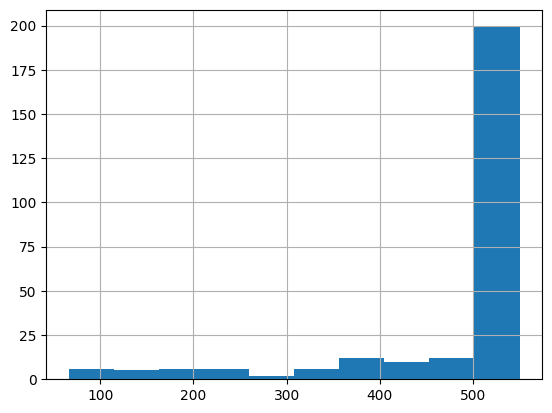

In [ ]:
df['Num_Pre'].hist()

<Axes: >

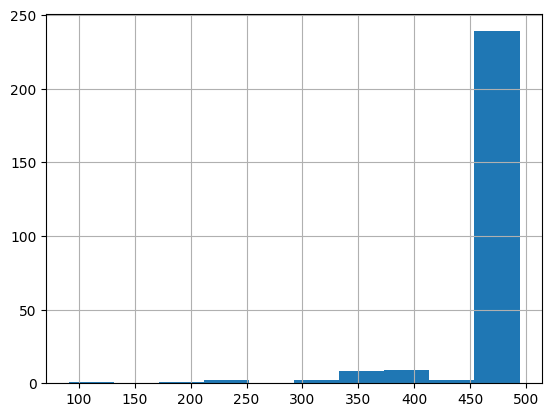

In [ ]:
df['Num_Pen'].hist()

<Axes: >

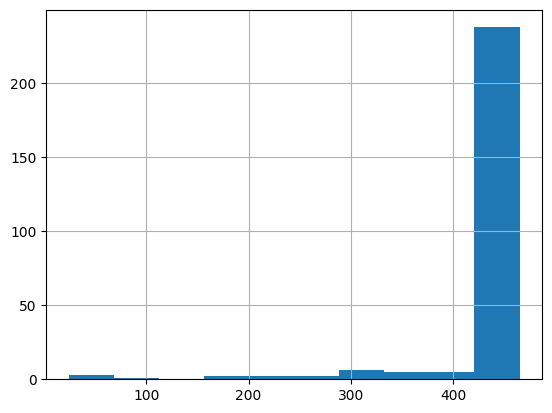

In [ ]:
df['Num_Ur'].hist()

In [ ]:
df_numpass = df.copy()

In [ ]:
esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
esg = esg[['Symbol','ESG Score','ETF Database Category']]
esg

,Symbol,ESG Score,ETF Database Category
0,VOTE,6.14,NaN
1,SPY,6.26,Large Cap Growth Equities
2,IVV,6.26,Large Cap Growth Equities
3,VTI,6.03,Large Cap Growth Equities
4,VOO,6.23,Large Cap Growth Equities
...,...,...,...
975,AFMC,6.22,Small Cap Blend Equities
976,DSPC,NaN,All Cap Equities
977,GBLO,7.43,Large Cap Blend Equities
978,GBGR,4.96,Large Cap Growth Equities


In [ ]:
###ตัด Energy sector ออก
#df = df[(df['ETF Database Category'] != 'Energy Equities')&(df['ETF Database Category'] != 'Alternative Energy Equities')]
#df

,ETF,Num_Pre,Num_Pen,Num_Ur,Symbol,ESG Score,ETF Database Category
0,ESGU,92,491,462,ESGU,7.06,Large Cap Growth Equities
1,VB,544,492,462,VB,5.55,Small Cap Growth Equities
2,AIEQ,323,367,240,AIEQ,5.14,Large Cap Growth Equities
3,AMJ,544,491,462,AMJ,NaN,MLPs
4,AMLP,544,491,462,AMLP,3.46,MLPs
...,...,...,...,...,...,...,...
259,XSD,540,491,462,XSD,5.40,Technology Equities
260,XSLV,544,491,443,XSLV,4.76,Volatility Hedged Equity
261,XSW,198,484,327,XSW,6.74,Technology Equities
262,XT,539,491,462,XT,6.70,Large Cap Growth Equities


In [ ]:
df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
df

,ETF,Num_Normal,Num_First,Num_Second,Num_Third,Num_Fourth,Num_Fifth,Num_Omi,Num_Ur,Symbol,ESG Score,ETF Database Category
0,ESGU,95,75,64,123,84,84,58,462,ESGU,7.06,Large Cap Growth Equities
1,VB,547,75,64,123,84,85,58,462,VB,5.55,Small Cap Growth Equities
2,AIEQ,326,34,32,92,80,73,53,240,AIEQ,5.14,Large Cap Growth Equities
3,AMJ,547,75,64,123,84,84,58,462,AMJ,NaN,MLPs
4,AMLP,547,75,64,123,84,84,58,462,AMLP,3.46,MLPs
...,...,...,...,...,...,...,...,...,...,...,...,...
259,XSD,543,75,64,123,84,84,58,462,XSD,5.40,Technology Equities
260,XSLV,547,75,64,123,84,84,58,443,XSLV,4.76,Volatility Hedged Equity
261,XSW,201,75,60,120,84,84,58,327,XSW,6.74,Technology Equities
262,XT,542,75,64,123,84,84,58,462,XT,6.70,Large Cap Growth Equities


In [ ]:
df[df['ESG Score'].isnull()==True]

,ETF,Num_Normal,Num_First,Num_Second,Num_Third,Num_Fourth,Num_Fifth,Num_Omi,Num_Ur,Symbol,ESG Score,ETF Database Category
3,AMJ,547,75,64,123,84,84,58,462,AMJ,NaN,MLPs
11,BIZD,159,72,42,119,84,84,58,462,BIZD,NaN,Financials Equities
114,IWC,509,75,55,114,84,84,58,458,IWC,NaN,Small Cap Blend Equities
142,KBWD,387,75,64,123,84,84,58,462,KBWD,NaN,Financials Equities


In [ ]:
df = df.drop([3,11,114,142])

In [ ]:
df[df['ESG Score'].isnull()==True]

,ETF,Num_Normal,Num_First,Num_Second,Num_Third,Num_Fourth,Num_Fifth,Num_Omi,Num_Ur,Symbol,ESG Score,ETF Database Category


In [ ]:
df.reset_index(drop=True)

,ETF,Num_Normal,Num_First,Num_Second,Num_Third,Num_Fourth,Num_Fifth,Num_Omi,Num_Ur,Symbol,ESG Score,ETF Database Category
0,ESGU,95,75,64,123,84,84,58,462,ESGU,7.06,Large Cap Growth Equities
1,VB,547,75,64,123,84,85,58,462,VB,5.55,Small Cap Growth Equities
2,AIEQ,326,34,32,92,80,73,53,240,AIEQ,5.14,Large Cap Growth Equities
3,AMLP,547,75,64,123,84,84,58,462,AMLP,3.46,MLPs
4,AMZA,547,75,64,123,84,84,58,462,AMZA,4.04,MLPs
...,...,...,...,...,...,...,...,...,...,...,...,...
255,XSD,543,75,64,123,84,84,58,462,XSD,5.40,Technology Equities
256,XSLV,547,75,64,123,84,84,58,443,XSLV,4.76,Volatility Hedged Equity
257,XSW,201,75,60,120,84,84,58,327,XSW,6.74,Technology Equities
258,XT,542,75,64,123,84,84,58,462,XT,6.70,Large Cap Growth Equities


# Get BNS statistic test

In [ ]:
# 5 periods
BNS = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_5_periods_statistic.csv')
BNS

,ETF,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
0,AMLP_Fifth,4.761905,-0.002068,0.006163,0.006385,0.002659,0.022985
1,AMLP_First,8.000000,0.008441,0.028121,0.029036,0.011114,0.053449
2,AMLP_Fourth,10.714286,-0.002367,0.006974,0.006737,0.001537,0.058315
3,AMLP_Normal,10.054845,0.000305,0.005942,0.006496,0.002641,0.049940
4,AMLP_Omi,5.172414,0.003566,0.008392,0.007741,0.001486,0.029959
...,...,...,...,...,...,...,...
1635,XT_Normal,27.490775,-0.000538,0.004326,0.004865,0.002290,0.148429
1636,XT_Omi,5.172414,-0.001059,0.003069,0.002881,0.000060,0.013686
1637,XT_Second,6.250000,-0.002432,0.003691,0.002894,0.000818,0.026974
1638,XT_Third,4.065041,-0.000132,0.004511,0.005020,0.002207,0.023138


In [ ]:
# 2 periods
BNS = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_2_periods_statistic.csv')
BNS

,ETF,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
0,AMLP_Pen,5.702648,0.000168,0.012279,0.015901,0.010105,0.034893
1,AMLP_Pre,10.110294,0.000305,0.005942,0.006496,0.002641,0.051456
2,AMLP_Ur,6.493506,-0.000161,0.005843,0.006147,0.001916,0.033854
3,AMZA_Pen,7.942974,-0.004018,0.019578,0.022343,0.011492,0.052468
4,AMZA_Pre,15.257353,-0.000791,0.007337,0.007754,0.002632,0.076289
...,...,...,...,...,...,...,...
610,XSLV_Pre,11.764706,0.000185,0.003690,0.003930,0.001364,0.057741
611,XSLV_Ur,40.632054,0.000648,0.007133,0.014425,0.012555,0.252972
612,XT_Pen,5.498982,-0.001794,0.004891,0.006167,0.004163,0.028949
613,XT_Pre,27.643785,-0.000538,0.004326,0.004865,0.002290,0.153328


In [ ]:
sp = BNS['ETF'].str.split(pat='_',expand=True)
BNS['ETF'] = sp[0]
BNS['Period'] = sp[1]
BNS

,ETF,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution,Period
0,AMLP,4.761905,-0.002068,0.006163,0.006385,0.002659,0.022985,Fifth
1,AMLP,8.000000,0.008441,0.028121,0.029036,0.011114,0.053449,First
2,AMLP,10.714286,-0.002367,0.006974,0.006737,0.001537,0.058315,Fourth
3,AMLP,10.054845,0.000305,0.005942,0.006496,0.002641,0.049940,Normal
4,AMLP,5.172414,0.003566,0.008392,0.007741,0.001486,0.029959,Omi
...,...,...,...,...,...,...,...,...
1635,XT,27.490775,-0.000538,0.004326,0.004865,0.002290,0.148429,Normal
1636,XT,5.172414,-0.001059,0.003069,0.002881,0.000060,0.013686,Omi
1637,XT,6.250000,-0.002432,0.003691,0.002894,0.000818,0.026974,Second
1638,XT,4.065041,-0.000132,0.004511,0.005020,0.002207,0.023138,Third


In [ ]:
BNSa = BNS.merge(df,how='inner',on='ETF')
BNSa

,ETF,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution,Period,Num_Normal,Num_First,Num_Second,Num_Third,Num_Fourth,Num_Fifth,Num_Omi,Num_Ur,Symbol,ESG Score,ETF Database Category
0,AMLP,4.761905,-0.002068,0.006163,0.006385,0.002659,0.022985,Fifth,547,75,64,123,84,84,58,462,AMLP,3.46,MLPs
1,AMLP,8.000000,0.008441,0.028121,0.029036,0.011114,0.053449,First,547,75,64,123,84,84,58,462,AMLP,3.46,MLPs
2,AMLP,10.714286,-0.002367,0.006974,0.006737,0.001537,0.058315,Fourth,547,75,64,123,84,84,58,462,AMLP,3.46,MLPs
3,AMLP,10.054845,0.000305,0.005942,0.006496,0.002641,0.049940,Normal,547,75,64,123,84,84,58,462,AMLP,3.46,MLPs
4,AMLP,5.172414,0.003566,0.008392,0.007741,0.001486,0.029959,Omi,547,75,64,123,84,84,58,462,AMLP,3.46,MLPs
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1635,XT,27.490775,-0.000538,0.004326,0.004865,0.002290,0.148429,Normal,542,75,64,123,84,84,58,462,XT,6.70,Large Cap Growth Equities
1636,XT,5.172414,-0.001059,0.003069,0.002881,0.000060,0.013686,Omi,542,75,64,123,84,84,58,462,XT,6.70,Large Cap Growth Equities
1637,XT,6.250000,-0.002432,0.003691,0.002894,0.000818,0.026974,Second,542,75,64,123,84,84,58,462,XT,6.70,Large Cap Growth Equities
1638,XT,4.065041,-0.000132,0.004511,0.005020,0.002207,0.023138,Third,542,75,64,123,84,84,58,462,XT,6.70,Large Cap Growth Equities


In [ ]:
# prompt: drop column Symbol, ETF database category from BNSa

BNSa = BNSa.drop(['Symbol', 'ETF Database Category'], axis=1)


In [ ]:
BNSa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640 entries, 0 to 1639
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   ETF                1640 non-null   object 
 1   Jump inten(%)      1640 non-null   float64
 2   Jump mean          1620 non-null   float64
 3   Abs Jump mean      1620 non-null   float64
 4   Jump std           1620 non-null   float64
 5   Abs Jump std       1620 non-null   float64
 6   Jump Contribution  1640 non-null   float64
 7   Period             1640 non-null   object 
 8   Num_Normal         1640 non-null   int64  
 9   Num_First          1640 non-null   int64  
 10  Num_Second         1640 non-null   int64  
 11  Num_Third          1640 non-null   int64  
 12  Num_Fourth         1640 non-null   int64  
 13  Num_Fifth          1640 non-null   int64  
 14  Num_Omi            1640 non-null   int64  
 15  Num_Ur             1640 non-null   int64  
 16  ESG Score          1640 

In [ ]:
# 2 period
BNSa.to_csv('/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/RAW_BNS_5min_2_periods_statistic_with_ESG.csv',index=False)

In [ ]:
# 5 period
BNSa.to_csv('/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/RAW_BNS_5min_5_periods_statistic_with_ESG.csv',index=False)

In [ ]:
BNSa = BNSa.drop(columns=['Num_Pre','Num_Post','ESG Score'])

KeyError: "['Num_Post'] not found in axis"

In [ ]:
# @title Get high/low df
type_of_sep = "90,10" # @param ["90,10", "75,25"]

if type_of_sep == '90,10':
  sep_h = 90
  sep_l = 10
elif type_of_sep == '75,25':
  sep_h = 75
  sep_l = 25
etf_high_list = pd.read_csv(f'/content/drive/Shareddrives/RA SASIN/Yfinance/ETF_High({sep_h})_list.csv')
etf_low_list = pd.read_csv(f'/content/drive/Shareddrives/RA SASIN/Yfinance/ETF_Low({sep_l})_list.csv')
etf_high_list = list(etf_high_list['ETF'])
etf_low_list = list(etf_low_list['ETF'])
BNSh = BNSa[BNSa['ETF'].isin(etf_high_list) == True]
BNSl = BNSa[BNSa['ETF'].isin(etf_low_list) == True]

NameError: name 'BNSa' is not defined

In [ ]:
BNShl = pd.concat([BNSh, BNSl])  # Use pd.concat to combine DataFrames
BNShl

,ETF,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution,Period,Num_Pre,Num_Pen,Num_Ur,Symbol,ESG Score,ETF Database Category
84,EUFN,12.423625,-0.000706,0.004442,0.004997,0.002396,0.063213,Pen,544,491,462,EUFN,10.00,Financials Equities
85,EUFN,12.316176,0.000076,0.003173,0.003492,0.001461,0.066122,Pre,544,491,462,EUFN,10.00,Financials Equities
86,EUFN,8.658009,-0.000054,0.004254,0.004697,0.001992,0.044647,Ur,544,491,462,EUFN,10.00,Financials Equities
87,EWD,10.997963,-0.001460,0.005021,0.005192,0.001970,0.057516,Pen,544,491,462,EWD,8.13,Europe Equities
88,EWD,16.176471,-0.000170,0.003162,0.003423,0.001323,0.080501,Pre,544,491,462,EWD,8.13,Europe Equities
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
756,XOP,6.776557,-0.002830,0.010521,0.015465,0.011683,0.042343,Pre,546,493,463,XOP,4.93,Energy Equities
757,XOP,5.831533,0.001508,0.009625,0.010012,0.003140,0.030866,Ur,546,493,463,XOP,4.93,Energy Equities
767,XSLV,15.478615,-0.000568,0.005229,0.006027,0.003051,0.064696,Pen,544,491,443,XSLV,4.76,Volatility Hedged Equity
768,XSLV,11.764706,0.000185,0.003690,0.003930,0.001364,0.057741,Pre,544,491,443,XSLV,4.76,Volatility Hedged Equity


In [ ]:
def CREATE_PART_SEP(BNS_df, period, BNS_com = pd.DataFrame()):
  not_used = ['Period', 'Symbol', 'ETF Database Category']
  if len(BNS_com) == 0:
    BNS_com = BNS_df[['ETF','Num_Pre', 'Num_Pen','Num_Ur','ESG Score']].drop_duplicates()


  BNS_HL_prepost1 = BNS_df[BNS_df['Period']== period]
  BNS_HL_prepost1.drop(columns=not_used,inplace=True)
  BNS_HL_prepost1.drop(columns=['Num_Pre', 'Num_Pen','Num_Ur','ESG Score'],inplace=True)

  col = ['Jump inten(%)','Jump mean','Abs Jump mean','Jump std','Abs Jump std','Jump Contribution']
  for c in BNS_HL_prepost1.columns:
    if c in col:
        new = f'{period}_' + c
        BNS_HL_prepost1.rename(columns={c:new}, inplace=True)
  BNS_com = BNS_com.merge(BNS_HL_prepost1,on='ETF')

  return BNS_com

In [ ]:
def HL(BNSh, BNSl):
  period = ['Pre', 'Pen', 'Ur']
  n = 1
  for p in period:
    if n == 1:
      dfH = CREATE_PART_SEP(BNSh, p)
    else:
      dfH = CREATE_PART_SEP(BNSh, p, dfH)
    n+=1
  dfH['ESG'] = 'High'

  n = 1
  for p in period:
    if n == 1:
      dfL = CREATE_PART_SEP(BNSl, p)
    else:
      dfL = CREATE_PART_SEP(BNSl, p, dfL)
    n+=1
  dfL['ESG'] = 'Low'

  df_all = pd.concat([dfH, dfL])
  df_all.reset_index(drop=True)
  return df_all

In [ ]:
BNShl = HL(BNSh, BNSl)
BNShl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 0 to 20
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ETF                    42 non-null     object 
 1   Num_Pre                42 non-null     int64  
 2   Num_Pen                42 non-null     int64  
 3   Num_Ur                 42 non-null     int64  
 4   ESG Score              42 non-null     float64
 5   Pre_Jump inten(%)      42 non-null     float64
 6   Pre_Jump mean          42 non-null     float64
 7   Pre_Abs Jump mean      42 non-null     float64
 8   Pre_Jump std           42 non-null     float64
 9   Pre_Abs Jump std       42 non-null     float64
 10  Pre_Jump Contribution  42 non-null     float64
 11  Pen_Jump inten(%)      42 non-null     float64
 12  Pen_Jump mean          42 non-null     float64
 13  Pen_Abs Jump mean      42 non-null     float64
 14  Pen_Jump std           42 non-null     float64
 15  Pen_Abs Jump 

<ipython-input-166-84ca1ef8fb5d>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BNS_HL_prepost1.drop(columns=not_used,inplace=True)
<ipython-input-166-84ca1ef8fb5d>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BNS_HL_prepost1.drop(columns=['Num_Pre', 'Num_Pen','Num_Ur','ESG Score'],inplace=True)
<ipython-input-166-84ca1ef8fb5d>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BNS_HL_prepost1.rename(columns={c:new}, inplace=True)

In [ ]:
BNShl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 42 entries, 0 to 20
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ETF                    42 non-null     object 
 1   Num_Pre                42 non-null     int64  
 2   Num_Pen                42 non-null     int64  
 3   Num_Ur                 42 non-null     int64  
 4   ESG Score              42 non-null     float64
 5   Pre_Jump inten(%)      42 non-null     float64
 6   Pre_Jump mean          42 non-null     float64
 7   Pre_Abs Jump mean      42 non-null     float64
 8   Pre_Jump std           42 non-null     float64
 9   Pre_Abs Jump std       42 non-null     float64
 10  Pre_Jump Contribution  42 non-null     float64
 11  Pen_Jump inten(%)      42 non-null     float64
 12  Pen_Jump mean          42 non-null     float64
 13  Pen_Abs Jump mean      42 non-null     float64
 14  Pen_Jump std           42 non-null     float64
 15  Pen_Abs Jump 

In [ ]:
#percentile 10 90

BNShl.to_csv('/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/Raw_BNS_HL_prepost_after_response#1.csv',index=False)

# table 2_4 (Descriptive statistics)

In [ ]:
def table2_4_prep(csv_files_location,interval,folder_name,df_sum):
  num = 1
  col = ['ETF', 'Period', 'Number_of_day','RT','Volume_of_trade', 'Trading value', 'Volatility', 'Return all day mean', 'Return all day volatility']
  summary = pd.DataFrame(columns = col)
  #for f in csv_files:
  for f in glob.glob(os.path.join(csv_files_location, '*.csv')):
    ETF_name = (os.path.basename(f)).split('-')
    ETF_name = ETF_name[0]
    print(os.path.basename(f))


    ## vaiable for per period
    rt_all = []
    vol_all = []
    avg_all = []
    vola_all = []
    return_all = []
    #import file
    df = pd.read_csv(f)

    #process rt
    date_month_year = df[['DD', 'MM','YY']]
    unique_date = date_month_year.drop_duplicates()
    sort_unique_date = unique_date.sort_values(['YY','MM','DD'])
    sort_unique_date.index = np.arange(0,len(sort_unique_date))
    number_of_days = len(sort_unique_date)

    result = np.zeros((number_of_days,9))

    from IPython.core.display import Math
    for i in range(number_of_days):
      layer1_test = [sort_unique_date.loc[i,'DD']]
      layer2_test = [sort_unique_date.loc[i,'MM']]
      layer3_test = [sort_unique_date.loc[i,'YY']]

      layer1 = np.isin(df["DD"],layer1_test)
      layer1.astype(int)
      layer1 = df[layer1]

      layer2 = np.isin(layer1["MM"],layer2_test)
      layer2.astype(int)
      layer2 = layer1[layer2]

      layer3 = np.isin(layer2["YY"],layer3_test)
      layer3.astype(int)
      layer3 = layer2[layer3]
      L = len(layer3)

      rt = np.zeros((L-1,1))
      vol = np.zeros((L,1))
      avg_trade_size = np.zeros((L,1))
      #volat = np.zeros
      get_first = True
      ## Get price in list
      for x in range(L): #5: Size (Volume)
        vol[x] = layer3.iloc[x,5] #เก็บค่า Volume ในแต่ช่วงของวัน ########
        price = float(layer3.iloc[x,6]) if layer3.iloc[x,6] != "ZERO" else 0
        avg_trade_size[x] = layer3.iloc[x,5] * price # เอาค่า Volume มาคูณกับ price ในช่วงนั้น ๆ ออกมาเป็น Value ########
        if layer3.iloc[x,6] == 'ZERO':
          continue
        if get_first:
          temp_first = math.log(float(layer3.iloc[x,6]))
          get_first = False
      temp_last = math.log(float(layer3.iloc[-1,6]))

      ## Get rt 77 variable
      for x in range(L-1):
        if any([layer3.iloc[x+1,6] == "ZERO", layer3.iloc[x,6] == 'ZERO']):
          rt[x] = 0
        else:
          rt[x] = (math.log(float(layer3.iloc[x+1,6]))-math.log(float(layer3.iloc[x,6]))) # Using 6: price
      ## Per day data
      result[i,0] = sort_unique_date.iloc[i,0] #DD
      result[i,1] = sort_unique_date.iloc[i,1] #MM
      result[i,2] = sort_unique_date.iloc[i,2] #YY
      result[i,3] = L
      result[i,4] = np.mean(rt)
      result[i,5] = np.sum(vol) #เอา Volume ทุกช่วงในวันนั้นมารวมกัน ########
      result[i,6] = np.sum(avg_trade_size) # เอา Value ทุกช่วงมาเฉลี่ยกัน ########
      result[i,7] = np.var(rt)
      result[i,8] = temp_last - temp_first # return all day
      ## Per period data prepare
      rt_all.append(np.mean(rt))
      vol_all.append(np.sum(vol)) #เก็บค่า Volume ของแต่ละวัน  ########
      avg_all.append(np.sum(avg_trade_size)) #เก็บค่า Value ของแต่ละวัน ########
      vola_all.append(np.var(rt))
      return_all.append(temp_last - temp_first)

    result = pd.DataFrame(result)
    result.columns = ['DD', 'MM','YY','L' ,'rt', 'Volume_of_trade','Trading value', 'Volatility', 'Return all day']
    #print(result) # for debug
    #export file
    if '-pre' in str(os.path.basename(f)):
      if '2' in str(os.path.basename(f)):
        ETF_name = ETF_name + "-2"
      filepath_w = f'/content/drive/Shareddrives/RA SASIN/table2_4/{interval}_no_Criteria_{folder_name}/{ETF_name}-Pre-{interval}-NoCriteria-table2_4.csv'

      result.to_csv(filepath_w, index = False)
      print(f'{num}. Process finished; {ETF_name} Pre-pandemic')

      temp = [ETF_name, 'Normal', number_of_days, np.mean(rt_all), np.mean(vol_all), np.mean(avg_all), np.mean(vola_all), np.mean(return_all), np.var(return_all)]
      ########'ETF',    'Period', 'Number_of_day',   'RT',         'Volume_of_trade', 'Trading value', 'Volatility',       'Return all day mean', 'Return all day volatitlity
                                                    ######### เอาค่า Volume และ Value ของแต่ละวันมาเฉลี่ยกัน ########
      summary.loc[len(summary)] = temp

      num += 1
    elif '-pen' in str(os.path.basename(f)):
      if '2' in str(os.path.basename(f)):
        ETF_name = ETF_name + "-2"
      filepath_w = f'/content/drive/Shareddrives/RA SASIN/table2_4/{interval}_no_Criteria_{folder_name}/{ETF_name}-Pen-{interval}-NoCriteria-table2_4.csv'
      result.to_csv(filepath_w, index = False)
      print(f'{num}. Process finish: {ETF_name} Pen-pandemic')

      temp = [ETF_name, 'Pandemic', number_of_days, np.mean(rt_all), np.mean(vol_all), np.mean(avg_all), np.mean(vola_all), np.mean(return_all), np.var(return_all)]
      summary.loc[len(summary)] = temp
      num +=1

    elif '-ur' in str(os.path.basename(f)):
      if '2' in str(os.path.basename(f)):
        ETF_name = ETF_name + "-2"
      filepath_w = f'/content/drive/Shareddrives/RA SASIN/table2_4/{interval}_no_Criteria_{folder_name}/{ETF_name}-Ur-{interval}-NoCriteria-table2_4.csv'
      result.to_csv(filepath_w, index = False)
      print(f'{num}. Process finish: {ETF_name} Ur')

      temp = [ETF_name, 'War', number_of_days, np.mean(rt_all), np.mean(vol_all), np.mean(avg_all), np.mean(vola_all), np.mean(return_all), np.var(return_all)]
      summary.loc[len(summary)] = temp
      num +=1
  summary = summary.sort_values(by=['ETF'])
  df_sum =summary.copy()
  report_w = f'/content/drive/Shareddrives/RA SASIN/table2_4/{interval}_summary_{folder_name}/table2_4_summary-{interval}-NoCriteria.csv'
  #print(summary) # for debug
  summary.to_csv(report_w, index = False )
  print('Summary table is exported')


In [ ]:
col = ['ETF', 'Period', 'Number_of_day','RT','Volume_of_trade', 'Trading value', 'Volatility', 'Return all day mean', 'Return all day volatility']
df_sum = pd.DataFrame(columns = col)

In [ ]:
table2_4_prep('/content/drive/Shareddrives/RA SASIN/Group time data/5min_3period_after_response#1',"5min","after_response#1",df_sum)

In [ ]:
table2_4_prep('/content/drive/Shareddrives/RA SASIN/Group time data/5min_3period_after_response#1',"5min","after_response#1")

ESGU-5min-data-pre.csv
1. Process finished; ESGU Pre-pandemic
ESGU-5min-data-pen.csv
2. Process finish: ESGU Pen-pandemic
ESGU-5min-data-ur.csv
3. Process finish: ESGU Ur
VB-5min-data-pen.csv
4. Process finish: VB Pen-pandemic
VB-5min-data-ur.csv
5. Process finish: VB Ur
AIEQ-5min-data-pre.csv
6. Process finished; AIEQ Pre-pandemic
AIEQ-5min-data-pen.csv
7. Process finish: AIEQ Pen-pandemic
AIEQ-5min-data-ur.csv
8. Process finish: AIEQ Ur
AMJ-5min-data-pre.csv
9. Process finished; AMJ Pre-pandemic
AMJ-5min-data-pen.csv
10. Process finish: AMJ Pen-pandemic
AMJ-5min-data-ur.csv
11. Process finish: AMJ Ur
AMLP-5min-data-pre.csv
12. Process finished; AMLP Pre-pandemic
AMLP-5min-data-pen.csv
13. Process finish: AMLP Pen-pandemic
AMLP-5min-data-ur.csv
14. Process finish: AMLP Ur
AMZA-5min-data-pre.csv
15. Process finished; AMZA Pre-pandemic
AMZA-5min-data-pen.csv
16. Process finish: AMZA Pen-pandemic
AMZA-5min-data-ur.csv
17. Process finish: AMZA Ur
ARKG-5min-data-pre.csv
18. Process finishe

OSError: Cannot save file into a non-existent directory: '/content/drive/Shareddrives/RA SASIN/table2_4/5min_summary__after_response#1'

In [ ]:
dfa = pd.read_csv('/content/drive/Shareddrives/RA SASIN/table2_4/5min_summary_after_response#1/table2_4_summary-5min-NoCriteria.csv')
dfa.head()

,ETF,Period,Number_of_day,RT,Volume_of_trade,Trading value,Volatility,Return all day mean,Return all day volatility
0,AIEQ,Pandemic,367,-0.000016,3.055305e+04,1.131659e+06,0.000005,-0.001239,0.000179
1,AIEQ,Normal,323,-0.000008,8.726256e+04,2.375514e+06,0.000002,-0.000600,0.000105
2,AIEQ,War,240,-0.000004,2.252803e+04,7.042142e+05,0.000003,-0.000308,0.000165
3,AMJ,Normal,544,-0.000021,2.068352e+06,4.996734e+07,0.000002,-0.001617,0.000135
4,AMJ,Pandemic,491,-0.000004,1.129865e+06,1.574571e+07,0.000008,-0.000274,0.000411


In [ ]:
dfa['ETF'].nunique()

264

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
esg = esg[['Symbol','ESG Score']]

df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
df.drop(columns=['Symbol'],inplace=True)
df = df.drop([1,86])
df.reset_index(drop=True)

,ETF,Num_Pre,Num_Post,ESG Score
0,VB,544,456,5.55
1,AMLP,544,455,3.46
2,AMZA,544,455,4.04
3,ARKG,535,458,4.27
4,ARKK,544,458,5.76
...,...,...,...,...
200,XOP,546,457,4.93
201,XRT,544,456,5.47
202,XSD,540,455,5.40
203,XSLV,544,455,4.76


In [ ]:
dta = dfa.merge(df,how='inner',on='ETF')
dta.head()

,ETF,Period,Number_of_day,RT,Volume_of_trade,Trading value,Volatility,Return all day mean,Return all day volatility,Num_Pre,Num_Post,ESG Score
0,AMLP,Pandemic,491,-0.000002,6.347124e+06,8.693877e+07,0.000008,-0.000177,0.000411,544,455,3.46
1,AMLP,Normal,544,-0.000018,1.822786e+07,1.711325e+08,0.000003,-0.001413,0.000124,544,455,3.46
2,AMLP,War,462,0.000005,1.859716e+06,7.255420e+07,0.000002,0.000354,0.000122,544,455,3.46
3,AMZA,War,462,-0.000008,5.687144e+04,1.802892e+06,0.000008,-0.000637,0.000202,544,455,4.04
4,AMZA,Normal,544,-0.000035,1.020256e+06,6.321171e+06,0.000004,-0.002694,0.000255,544,455,4.04


In [ ]:
dta

,ETF,Period,Number_of_day,RT,Volume_of_trade,Trading value,Volatility,Return all day mean,Return all day volatility,Num_Pre,Num_Post,ESG Score
0,AMLP,Pandemic,491,-2.296763e-06,6.347124e+06,8.693877e+07,0.000008,-0.000177,0.000411,544,455,3.46
1,AMLP,Normal,544,-1.835269e-05,1.822786e+07,1.711325e+08,0.000003,-0.001413,0.000124,544,455,3.46
2,AMLP,War,462,4.593274e-06,1.859716e+06,7.255420e+07,0.000002,0.000354,0.000122,544,455,3.46
3,AMZA,War,462,-8.274080e-06,5.687144e+04,1.802892e+06,0.000008,-0.000637,0.000202,544,455,4.04
4,AMZA,Normal,544,-3.498105e-05,1.020256e+06,6.321171e+06,0.000004,-0.002694,0.000255,544,455,4.04
...,...,...,...,...,...,...,...,...,...,...,...,...
610,XSLV,Pandemic,491,-7.268663e-06,3.131685e+05,1.193079e+07,0.000004,-0.000560,0.000176,544,455,4.76
611,XSLV,Normal,544,-2.846552e-06,2.274744e+05,1.081053e+07,0.000001,-0.000219,0.000061,544,455,4.76
612,XT,Pandemic,491,-3.975361e-07,2.131661e+05,1.145704e+07,0.000002,-0.000031,0.000095,539,455,6.70
613,XT,Normal,539,-6.342746e-07,1.959375e+05,7.463268e+06,0.000001,-0.000049,0.000060,539,455,6.70




```
# This is formatted as code
```

# table 2_4 - 5 periods

In [ ]:
df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
df = df.drop(columns=['Unnamed: 0'])
df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
esg = esg[['Symbol','ESG Score']]

df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
df.drop(columns=['Symbol'],inplace=True)
df = df.drop([1,86])
df.reset_index(drop=True)

,ETF,Num_Pre,Num_Post,ESG Score
0,VB,544,456,5.55
1,AMLP,544,455,3.46
2,AMZA,544,455,4.04
3,ARKG,535,458,4.27
4,ARKK,544,458,5.76
...,...,...,...,...
200,XOP,546,457,4.93
201,XRT,544,456,5.47
202,XSD,540,455,5.40
203,XSLV,544,455,4.76


In [ ]:
df.head()

,ETF,Num_Pre,Num_Post,ESG Score
0,VB,544,456,5.55
2,AMLP,544,455,3.46
3,AMZA,544,455,4.04
4,ARKG,535,458,4.27
5,ARKK,544,458,5.76


In [ ]:
'VB' in df['ETF'].tolist()

True

In [ ]:
def table2_4_prep(csv_files_location,interval,folder_name,df_sum):
  df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
  df = df.drop(columns=['Unnamed: 0'])
  df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

  esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
  esg = esg[['Symbol','ESG Score']]

  df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
  df.drop(columns=['Symbol'],inplace=True)
  df = df.drop([1,86])
  df.reset_index(drop=True)
  ETF_list = df['ETF'].tolist()

  num = 1
  col = ['ETF', 'Period', 'Number_of_day','RT','Volume_of_trade', 'Trading value', 'Volatility', 'Return all day mean', 'Return all day volatility']
  summary = pd.DataFrame(columns = col)
  #for f in csv_files:
  for f in glob.glob(os.path.join(csv_files_location, '*.csv')):
    ETF_name = (os.path.basename(f)).split('-')
    ETF_name = ETF_name[0]
    print(os.path.basename(f))

    #print(df['ETF'].tolist())
    if ETF_name in ETF_list:

      ## vaiable for per period
      rt_all = []
      vol_all = []
      avg_all = []
      vola_all = []
      return_all = []
      #import file
      df = pd.read_csv(f)

      #process rt
      date_month_year = df[['DD', 'MM','YY']]
      unique_date = date_month_year.drop_duplicates()
      sort_unique_date = unique_date.sort_values(['YY','MM','DD'])
      sort_unique_date.index = np.arange(0,len(sort_unique_date))
      number_of_days = len(sort_unique_date)

      result = np.zeros((number_of_days,9))

      from IPython.core.display import Math
      for i in range(number_of_days):
        layer1_test = [sort_unique_date.loc[i,'DD']]
        layer2_test = [sort_unique_date.loc[i,'MM']]
        layer3_test = [sort_unique_date.loc[i,'YY']]

        layer1 = np.isin(df["DD"],layer1_test)
        layer1.astype(int)
        layer1 = df[layer1]

        layer2 = np.isin(layer1["MM"],layer2_test)
        layer2.astype(int)
        layer2 = layer1[layer2]

        layer3 = np.isin(layer2["YY"],layer3_test)
        layer3.astype(int)
        layer3 = layer2[layer3]
        L = len(layer3)

        rt = np.zeros((L-1,1))
        vol = np.zeros((L,1))
        avg_trade_size = np.zeros((L,1))
        #volat = np.zeros
        get_first = True
        ## Get price in list
        for x in range(L): #5: Size (Volume)
          vol[x] = layer3.iloc[x,5] #เก็บค่า Volume ในแต่ช่วงของวัน ########
          price = float(layer3.iloc[x,6]) if layer3.iloc[x,6] != "ZERO" else 0
          avg_trade_size[x] = layer3.iloc[x,5] * price # เอาค่า Volume มาคูณกับ price ในช่วงนั้น ๆ ออกมาเป็น Value ########
          if layer3.iloc[x,6] == 'ZERO':
            continue
          if get_first:
            temp_first = math.log(float(layer3.iloc[x,6]))
            get_first = False
        temp_last = math.log(float(layer3.iloc[-1,6]))

        ## Get rt 77 variable
        for x in range(L-1):
          if any([layer3.iloc[x+1,6] == "ZERO", layer3.iloc[x,6] == 'ZERO']):
            rt[x] = 0
          else:
            rt[x] = (math.log(float(layer3.iloc[x+1,6]))-math.log(float(layer3.iloc[x,6]))) # Using 6: price
        ## Per day data
        result[i,0] = sort_unique_date.iloc[i,0] #DD
        result[i,1] = sort_unique_date.iloc[i,1] #MM
        result[i,2] = sort_unique_date.iloc[i,2] #YY
        result[i,3] = L
        result[i,4] = np.mean(rt)
        result[i,5] = np.sum(vol) #เอา Volume ทุกช่วงในวันนั้นมารวมกัน ########
        result[i,6] = np.sum(avg_trade_size) # เอา Value ทุกช่วงมาเฉลี่ยกัน ########
        result[i,7] = np.var(rt)
        result[i,8] = temp_last - temp_first # return all day
        ## Per period data prepare
        rt_all.append(np.mean(rt))
        vol_all.append(np.sum(vol)) #เก็บค่า Volume ของแต่ละวัน  ########
        avg_all.append(np.sum(avg_trade_size)) #เก็บค่า Value ของแต่ละวัน ########
        vola_all.append(np.var(rt))
        return_all.append(temp_last - temp_first)

      result = pd.DataFrame(result)
      result.columns = ['DD', 'MM','YY','L' ,'rt', 'Volume_of_trade','Trading value', 'Volatility', 'Return all day']
      #print(result) # for debug
      #export file
      for period in ['normal','first','second','third','fourth','fifth','omi','ur']:
        if period in str(os.path.basename(f)):
          if '2' in str(os.path.basename(f)):
            ETF_name = ETF_name + "-2"
          filepath_w = f'/content/drive/Shareddrives/RA SASIN/table2_4/{interval}_{folder_name}/{ETF_name}-{period}-{interval}-NoCriteria-table2_4.csv'

          result.to_csv(filepath_w, index = False)
          print(f'{num}. Process finished: {ETF_name} {period}')

          temp = [ETF_name, period, number_of_days, np.mean(rt_all), np.mean(vol_all), np.mean(avg_all), np.mean(vola_all), np.mean(return_all), np.var(return_all)]
          ########'ETF', 'Period', 'Number_of_day','RT',            'Volume_of_trade', 'Trading value', 'Volatility',       'Return all day mean', 'Return all day volatitlity
                                                        ######### เอาค่า Volume และ Value ของแต่ละวันมาเฉลี่ยกัน ########
          summary.loc[len(summary)] = temp

          num += 1

  summary = summary.sort_values(by=['ETF'])
  summary['Period'] = np.where(summary['Period'] == 'ur','War',summary['Period'])
  df_sum =summary.copy()
  report_w = f'/content/drive/Shareddrives/RA SASIN/table2_4/{interval}_summary_{folder_name}/table2_4_summary-{interval}-NoCriteria.csv'
  #print(summary) # for debug
  summary.to_csv(report_w, index = False )
  print('Summary table is exported')


In [ ]:
col = ['ETF', 'Period', 'Number_of_day','RT','Volume_of_trade', 'Trading value', 'Volatility', 'Return all day mean', 'Return all day volatility']
df_sum = pd.DataFrame(columns = col)

In [ ]:
table2_4_prep('/content/drive/Shareddrives/RA SASIN/Group time data/5min_5period_after_response#1',"5min_5periods","after_response#1",df_sum)

XTN-5min-data-fourth.csv
JHMM-5min-data-normal.csv
1. Process finished: JHMM normal
KBE-5min-data-normal.csv
2. Process finished: KBE normal
JHMM-5min-data-ur.csv
3. Process finished: JHMM ur
JHMM-5min-data-omi.csv
4. Process finished: JHMM omi
JHMM-5min-data-fifth.csv
5. Process finished: JHMM fifth
JHMM-5min-data-third.csv
6. Process finished: JHMM third
JHMM-5min-data-second.csv
7. Process finished: JHMM second
JHMM-5min-data-fourth.csv
8. Process finished: JHMM fourth
9. Process finished: JHMM ur
JHMM-5min-data-first.csv
10. Process finished: JHMM first
KBE-5min-data-fourth.csv
11. Process finished: KBE fourth
12. Process finished: KBE ur
KBE-5min-data-third.csv
13. Process finished: KBE third
KBE-5min-data-fifth.csv
14. Process finished: KBE fifth
KBE-5min-data-second.csv
15. Process finished: KBE second
KBE-5min-data-first.csv
16. Process finished: KBE first
KBE-5min-data-omi.csv
17. Process finished: KBE omi
KBE-5min-data-ur.csv
18. Process finished: KBE ur
KBWB-5min-data-normal

# Table 1 PanelA

In [ ]:
def prepare_df(low_quantile, file_path ,group):
  df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
  df = df.drop(columns=['Unnamed: 0'])
  df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

  esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
  esg = esg[['Symbol','ESG Score','ETF Database Category']]

  df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
  df.drop(columns=['Symbol'],inplace=True)
  df = df.drop([1,86])
  df.reset_index(drop=True)

  #percentile 10th, 25th(Q1)
  df_low = df[df['ESG Score'] <= df['ESG Score'].quantile(low_quantile)]
  #percentile 90th, 75th(Q4)
  df_high = df[df['ESG Score'] >= df['ESG Score'].quantile(1-low_quantile)]


  df['Energy'] = np.where(df['ETF Database Category'].str.contains('Energy'),'Energy','Non-Energy')
  #Energy
  df_Energy = df[df['Energy']=='Energy']
  #Non-Energy
  df_NonEnergy = df[df['Energy']=='Non-Energy']

  dfog = pd.read_csv(file_path)

  dta = dfog.merge(df,how='inner',on='ETF')
  dth = dfog.merge(df_high,how='inner',on='ETF')
  dtl = dfog.merge(df_low,how='inner',on='ETF')
  dte = dfog.merge(df_Energy,how='inner',on='ETF')
  dtne = dfog.merge(df_NonEnergy,how='inner',on='ETF')

  if group == 'all':
    return dta
  elif group == 'low':
    return dtl
  elif group == 'high':
    return dth
  elif group == 'energy':
    return dte
  elif group == 'nonEnergy':
    return dtne



def adjust_table(df):
  df2 = df
  if 'Number_of_day' in df2.columns:
    df2 = df2.drop(columns = ['Number_of_day'])

  df2 = df2.rename(columns = {'RT': 'Avg 5min return', 'Volume_of_trade': 'Avg trading volume', 'Trading value': 'Avg trading value', 'Volatility': 'Avg 5min vol', 'Return all day volatility': 'Daily volatility','Return all day mean': 'Daily return'})
  cols = ['Avg trading volume', 'Avg trading value', 'Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']
  df2 = df2[cols]

  #print(df2.info())
  #df2['Avg trading volume'] = round(df2['Avg trading volume'].astype(float)/1000000,3)
  #df2['Avg trading value'] = round(df2['Avg trading value'].astype(float)/1000000,3)

  #for c in ['Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']:
  #  df2[c] = round(df2[c].astype(float)*1000,3)
  #print(df2)
  return df2



def Ttest_5w(df,var,w):
        #print(df)
        #print(var)
        #print(w)
        summary, results = rp.ttest(group1= df[var][df['Period'] == w[0]],group1_name= w[0],
                                    group2= df[var][df['Period'] == w[1]],group2_name= w[1])
        #0.1* / 0.05** / 0.01***
        sig = ''
        p = results.iloc[3,1]
        t = results.iloc[2,1]
        if (p <= 0.1) & (p > 0.05):
            sig = '*'
        elif (p <= 0.05) & (p > 0.01):
            sig = '**'
        elif (p <= 0.01):
            sig = '***'

        return t,p,sig

def table2_4_A(low_quantile,file_path,group,num_periods,periods):
    df = prepare_df(low_quantile,file_path,group)

    df2 = df.drop(columns=['ETF','Energy','ETF Database Category'])
    df2 = df2.groupby('Period').mean()

    df2.drop(columns=['Num_Pre','Num_Post','ESG Score'],inplace=True)
    var = df.columns

    #w5 = [['Normal','Pandemic'],['Normal','War']]
    w5 = []

    for p in periods:
      w5.append(['Normal',p])


    for p in w5:
        n = 'Difference' + '-' + p[1]
        df2.loc[n,:] = df2.loc[p[0],:] - df2.loc[p[1],:]
        #print(df2)
    #print(df2)

    df2['Volume_of_trade'] = round(df2['Volume_of_trade'].astype(float)/1000000,3)
    df2['Trading value'] = round(df2['Trading value'].astype(float)/1000000,3)
    for c in ['RT', 'Volatility', 'Return all day volatility','Return all day mean']:
      df2[c] = round(df2[c].astype(float)*1000,3)

    df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))

    i=0
    #print(var)
    while i < num_periods-1:
        for v in var:
            if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','Number_of_day','Energy','ETF Database Category']:
                period = w5[i][1]
                t = 't' + '-' + w5[i][1]
                s = 'Sig' + '-' + w5[i][1]
                pv = 'P-value' + '-' + w5[i][1]
                dif = 'Difference' + '-' + period


                df2.loc[t,v],df2.at[pv,v],sig = Ttest_5w(df,v,w5[i])
                df2.loc[s,v] = sig

                df2.loc[period,v] = df2.loc[period,v] + '('+ df2.loc[dif,v] + df2.loc[s,v] + ')'

        i += 1
        continue
    df2 = adjust_table(df2)
    return df2


# def table2_4_A(df,num_periods,periods):
#   #print('All')

#   return
  # print('High ESG')
  # table5t_5w(dth,num_periods,periods)
  # print('Low ESG')
  # table5t_5w(dtl,num_periods,periods)


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_summary_after_response#1/table2_4_summary-5min-NoCriteria.csv'
table2_4_A(low_quantile=0.1,file_path = path,group='all',num_periods=3,periods=['Pandemic','War'])

<ipython-input-16-2df7c2eb0f64>:113: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Normal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Normal - Pandemic) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype 

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
Normal,2.183,246.891,-0.004,-0.284,0.002,0.092
Pandemic,2.456(-0.273),376.978(-130.087),-0.002(-0.002***),-0.134(-0.150***),0.003(-0.002***),0.173(-0.081***)
War,2.478(-0.296),413.629(-166.737),0.001(-0.005***),0.099(-0.383***),0.002(-0.001***),0.144(-0.052***)
Difference-Pandemic,-0.273,-130.087,-0.002,-0.150,-0.002,-0.081
Difference-War,-0.296,-166.737,-0.005,-0.383,-0.001,-0.052
t-Pandemic,-0.3636,-0.695,-3.8418,-3.8418,-9.873,-9.0095
P-value-Pandemic,0.7164,0.4875,0.0001,0.0001,0.0,0.0
Sig-Pandemic,,,***,***,***,***
t-War,-0.3974,-0.8219,-10.3714,-10.3714,-3.8427,-6.8208


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_summary_after_response#1/table2_4_summary-5min-NoCriteria.csv'
table2_4_A(low_quantile=0.1,file_path = path,group='high',num_periods=3,periods=['Pandemic','War'])

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
Normal,3.557,140.695,-0.004,-0.293,0.001,0.087
Pandemic,3.783(-0.226),191.523(-50.827),-0.001(-0.003**),-0.068(-0.224**),0.003(-0.001***),0.154(-0.067***)
War,3.343(0.214),199.809(-59.114),0.003(-0.007***),0.258(-0.551***),0.002(-0.001**),0.143(-0.056***)
Difference-Pandemic,-0.226,-50.827,-0.003,-0.224,-0.001,-0.067
Difference-War,0.214,-59.114,-0.007,-0.551,-0.001,-0.056
t-Pandemic,-0.0623,-0.4399,-2.6373,-2.6373,-5.336,-3.9451
P-value-Pandemic,0.9507,0.6624,0.0118,0.0118,0.0,0.0003
Sig-Pandemic,,,**,**,***,***
t-War,0.0654,-0.5167,-5.9495,-5.9495,-2.2755,-2.955


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_summary_after_response#1/table2_4_summary-5min-NoCriteria.csv'
table2_4_A(low_quantile=0.1,file_path = path,group='low',num_periods=3,periods=['Pandemic','War'])

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
Normal,3.499,226.286,-0.009,-0.677,0.002,0.144
Pandemic,3.020(0.479),371.502(-145.216),-0.004(-0.005*),-0.285(-0.392*),0.005(-0.003***),0.305(-0.161***)
War,2.880(0.619),364.926(-138.640),-0.000(-0.008***),-0.024(-0.653***),0.003(-0.001*),0.205(-0.061)
Difference-Pandemic,0.479,-145.216,-0.005,-0.392,-0.003,-0.161
Difference-War,0.619,-138.640,-0.008,-0.653,-0.001,-0.061
t-Pandemic,0.2326,-0.5022,-1.9825,-1.9825,-3.6138,-3.1658
P-value-Pandemic,0.8173,0.6183,0.0543,0.0543,0.0008,0.003
Sig-Pandemic,,,*,*,***,***
t-War,0.305,-0.4994,-3.6506,-3.6506,-1.7694,-1.6078


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_summary_after_response#1/table2_4_summary-5min-NoCriteria.csv'
table2_4_A(low_quantile=0.1,file_path = path,group='energy',num_periods=3,periods=['Pandemic','War'])

<ipython-input-16-2df7c2eb0f64>:113: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Normal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Normal - Pandemic) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype 

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
Normal,4.453,185.873,-0.021,-1.580,0.003,0.214
Pandemic,5.218(-0.766),239.226(-53.352),0.007(-0.027***),0.509(-2.089***),0.007(-0.004***),0.508(-0.293***)
War,3.923(0.530),325.634(-139.761),-0.001(-0.020***),-0.070(-1.510***),0.004(-0.001),0.259(-0.045)
Difference-Pandemic,-0.766,-53.352,-0.027,-2.089,-0.004,-0.293
Difference-War,0.530,-139.761,-0.020,-1.510,-0.001,-0.045
t-Pandemic,-0.1798,-0.2732,-10.1774,-10.1774,-4.9093,-4.7006
P-value-Pandemic,0.8596,0.7882,0.0,0.0,0.0002,0.0002
Sig-Pandemic,,,***,***,***,***
t-War,0.1425,-0.5653,-8.8553,-8.8553,-1.2001,-1.031


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_summary_after_response#1/table2_4_summary-5min-NoCriteria.csv'
table2_4_A(low_quantile=0.1,file_path = path,group='nonEnergy',num_periods=3,periods=['Pandemic','War'])

<ipython-input-16-2df7c2eb0f64>:113: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Normal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Normal - Pandemic) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype 

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
Normal,2.078,249.693,-0.003,-0.224,0.001,0.086
Pandemic,2.329(-0.251),383.303(-133.610),-0.002(-0.001*),-0.163(-0.061*),0.003(-0.002***),0.158(-0.072***)
War,2.412(-0.333),417.669(-167.976),0.001(-0.004***),0.107(-0.331***),0.002(-0.001***),0.139(-0.053***)
Difference-Pandemic,-0.251,-133.610,-0.001,-0.061,-0.002,-0.072
Difference-War,-0.333,-167.976,-0.004,-0.331,-0.001,-0.053
t-Pandemic,-0.3289,-0.6831,-1.8601,-1.8601,-9.8422,-10.0681
P-value-Pandemic,0.7424,0.495,0.0636,0.0636,0.0,0.0
Sig-Pandemic,,,*,*,***,***
t-War,-0.4388,-0.7926,-10.3934,-10.3934,-3.8185,-7.1771


#Table3

In [ ]:
def prepare_df(low_quantile, file_path ,group):
  df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
  df = df.drop(columns=['Unnamed: 0'])
  df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

  esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
  esg = esg[['Symbol','ESG Score','ETF Database Category']]

  df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
  df.drop(columns=['Symbol'],inplace=True)
  df = df.drop([1,86])
  df.reset_index(drop=True)

  #percentile 10th, 25th(Q1)
  df_low = df[df['ESG Score'] <= df['ESG Score'].quantile(low_quantile)]
  #percentile 90th, 75th(Q4)
  df_high = df[df['ESG Score'] >= df['ESG Score'].quantile(1-low_quantile)]

  df['Energy'] = np.where(df['ETF Database Category'].str.contains('Energy'),'Energy','Non-Energy')
  #Energy
  df_Energy = df[df['Energy']=='Energy']
  #Non-Energy
  df_NonEnergy = df[df['Energy']=='Non-Energy']

  dfog = pd.read_csv(file_path)

  dta = dfog.merge(df,how='inner',on='ETF')
  dth = dfog.merge(df_high,how='inner',on='ETF')
  dtl = dfog.merge(df_low,how='inner',on='ETF')
  dte = dfog.merge(df_Energy,how='inner',on='ETF')
  dtne = dfog.merge(df_NonEnergy,how='inner',on='ETF')

  if group == 'all':
    return dta
  elif group == 'low':
    return dtl
  elif group == 'high':
    return dth
  elif group == 'energy':
    return dte
  elif group == 'nonEnergy':
    return dtne



def adjust_table(df):
  df2 = df
  if 'Number_of_day' in df2.columns:
    df2 = df2.drop(columns = ['Number_of_day'])

  df2 = df2.rename(columns = {'RT': 'Avg 5min return', 'Volume_of_trade': 'Avg trading volume', 'Trading value': 'Avg trading value', 'Volatility': 'Avg 5min vol', 'Return all day volatility': 'Daily volatility','Return all day mean': 'Daily return'})
  cols = ['Avg trading volume', 'Avg trading value', 'Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']
  df2 = df2[cols]

  #print(df2.info())
  #df2['Avg trading volume'] = round(df2['Avg trading volume'].astype(float)/1000000,3)
  #df2['Avg trading value'] = round(df2['Avg trading value'].astype(float)/1000000,3)

  #for c in ['Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']:
  #  df2[c] = round(df2[c].astype(float)*1000,3)
  #print(df2)
  return df2



def Ttest_5w(df,var,w):
        #print(df)
        #print(var)
        #print(w)
        summary, results = rp.ttest(group1= df[var][df['Period'] == w[0]],group1_name= w[0],
                                    group2= df[var][df['Period'] == w[1]],group2_name= w[1])
        #0.1* / 0.05** / 0.01***
        sig = ''
        p = results.iloc[3,1]
        t = results.iloc[2,1]
        if (p <= 0.1) & (p > 0.05):
            sig = '*'
        elif (p <= 0.05) & (p > 0.01):
            sig = '**'
        elif (p <= 0.01):
            sig = '***'

        return t,p,sig

def table3(low_quantile,file_path,group,num_periods,periods):
    df = prepare_df(low_quantile,file_path,group)

    df2 = df.drop(columns=['ETF','Energy','ETF Database Category'])
    df2 = df2.groupby('Period').mean()
    df2.drop(columns=['Num_Pre','Num_Post','ESG Score'],inplace=True)
    var = df.columns

    #w5 = [['Normal','Pandemic'],['Normal','War']]
    w5 = []

    for p in periods:
      w5.append(['normal',p])


    for p in w5:
        n = 'Difference' + '-' + p[1]
        df2.loc[n,:] = df2.loc[p[0],:] - df2.loc[p[1],:]
        #print(df2)
    #print(df2)

    df2['Volume_of_trade'] = round(df2['Volume_of_trade'].astype(float)/1000000,3)
    df2['Trading value'] = round(df2['Trading value'].astype(float)/1000000,3)
    for c in ['RT', 'Volatility', 'Return all day volatility','Return all day mean']:
      df2[c] = round(df2[c].astype(float)*1000,3)

    df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))

    i=0
    #print(var)
    while i < num_periods-1:
        for v in var:
            if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','Number_of_day','Energy','ETF Database Category']:
                period = w5[i][1]
                t = 't' + '-' + w5[i][1]
                s = 'Sig' + '-' + w5[i][1]
                pv = 'P-value' + '-' + w5[i][1]
                dif = 'Difference' + '-' + period


                df2.loc[t,v],df2.at[pv,v],sig = Ttest_5w(df,v,w5[i])
                df2.loc[s,v] = sig

                df2.loc[period,v] = df2.loc[period,v] + '('+ df2.loc[dif,v] + df2.loc[s,v] + ')'

        i += 1
        continue
    df2 = adjust_table(df2)
    return df2


# def table2_4_A(df,num_periods,periods):
#   #print('All')

#   return
  # print('High ESG')
  # table5t_5w(dth,num_periods,periods)
  # print('Low ESG')
  # table5t_5w(dtl,num_periods,periods)


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_5periods_summary_after_response#1/table2_4_summary-5min_5periods-NoCriteria.csv'
table3(low_quantile=0.1,file_path = path,group='all',num_periods=8,periods=['first','second','third','fourth','fifth','omi','War'])

<ipython-input-20-cd7028f7a364>:111: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'normal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (normal - first) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is 

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
War,2.269(-0.062),382.994(-133.310),0.002(-0.007***),0.168(-0.518***),0.002(0.000*),0.111(-0.014*)
fifth,2.030(0.177),371.408(-121.724),-0.004(-0.000),-0.325(-0.025),0.001(0.001***),0.063(0.034***)
first,3.341(-1.134),378.842(-129.157),0.011(-0.016***),0.881(-1.231***),0.010(-0.008***),0.437(-0.340***)
fourth,2.061(0.147),352.359(-102.675),0.003(-0.008***),0.237(-0.587***),0.001(0.001***),0.077(0.020***)
normal,2.207,249.684,-0.005,-0.350,0.002,0.097
omi,3.273(-1.066),613.746(-364.062),-0.017(0.012***),-1.299(0.948***),0.003(-0.001***),0.206(-0.109***)
second,1.992(0.216),266.320(-16.636),-0.006(0.002**),-0.491(0.141**),0.002(-0.000**),0.137(-0.040***)
third,2.233(-0.026),333.601(-83.917),0.002(-0.007***),0.159(-0.509***),0.002(-0.000*),0.131(-0.034***)
Difference-first,-1.134,-129.157,-0.016,-1.231,-0.008,-0.340


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_5periods_summary_after_response#1/table2_4_summary-5min_5periods-NoCriteria.csv'
table3(low_quantile=0.1,file_path = path,group='high',num_periods=8,periods=['first','second','third','fourth','fifth','omi','War'])

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
War,3.309(0.280),201.003(-59.554),0.005(-0.010***),0.389(-0.751***),0.001(0.000),0.106(-0.013)
fifth,3.155(0.434),195.380(-53.931),-0.003(-0.002),-0.239(-0.123),0.001(0.001***),0.055(0.038***)
first,4.929(-1.340),165.079(-23.630),0.008(-0.013***),0.644(-1.006***),0.008(-0.007***),0.398(-0.305***)
fourth,3.274(0.315),202.197(-60.748),0.007(-0.011***),0.520(-0.882***),0.001(0.001***),0.069(0.024*)
normal,3.589,141.449,-0.005,-0.362,0.002,0.093
omi,4.486(-0.897),311.942(-170.493),-0.015(0.010***),-1.158(0.796***),0.002(-0.001*),0.173(-0.079**)
second,3.364(0.225),125.250(16.199),-0.006(0.001),-0.428(0.066),0.002(-0.000),0.126(-0.033**)
third,3.617(-0.028),173.374(-31.925),0.003(-0.008***),0.226(-0.588***),0.002(-0.000),0.109(-0.016)
Difference-first,-1.340,-23.630,-0.013,-1.006,-0.007,-0.305


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_5periods_summary_after_response#1/table2_4_summary-5min_5periods-NoCriteria.csv'
table3(low_quantile=0.1,file_path = path,group='low',num_periods=8,periods=['first','second','third','fourth','fifth','omi','War'])

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
War,2.670(0.868),374.090(-146.498),-0.002(-0.008***),-0.149(-0.619***),0.003(-0.000),0.182(-0.031)
fifth,2.453(1.084),385.757(-158.166),-0.011(0.001),-0.849(0.081),0.002(0.000),0.118(0.033)
first,4.839(-1.301),338.498(-110.906),0.009(-0.019***),0.706(-1.473***),0.015(-0.013***),0.703(-0.552***)
fourth,2.459(1.078),383.253(-155.662),-0.004(-0.006*),-0.273(-0.494*),0.002(0.000),0.160(-0.008)
normal,3.537,227.592,-0.010,-0.767,0.002,0.151
omi,3.898(-0.361),561.091(-333.499),-0.014(0.005),-1.115(0.348),0.005(-0.002**),0.408(-0.257**)
second,2.019(1.519),218.150(9.442),-0.012(0.002),-0.952(0.185),0.003(-0.001*),0.225(-0.074*)
third,2.614(0.923),361.968(-134.376),0.008(-0.018***),0.632(-1.400***),0.004(-0.001),0.244(-0.092*)
Difference-first,-1.301,-110.906,-0.019,-1.473,-0.013,-0.552


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_5periods_summary_after_response#1/table2_4_summary-5min_5periods-NoCriteria.csv'
table3(low_quantile=0.1,file_path = path,group='energy',num_periods=8,periods=['first','second','third','fourth','fifth','omi','War'])

<ipython-input-20-cd7028f7a364>:111: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'normal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (normal - first) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is 

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
War,4.233(0.269),285.840(-99.768),-0.006(-0.015***),-0.453(-1.189***),0.004(-0.000),0.294(-0.071)
fifth,4.705(-0.202),267.334(-81.262),-0.010(-0.011***),-0.775(-0.867***),0.004(-0.000),0.185(0.038)
first,6.791(-2.289),213.409(-27.336),0.026(-0.047***),2.006(-3.648***),0.020(-0.017***),1.189(-0.966***)
fourth,4.542(-0.040),246.046(-59.974),-0.011(-0.010***),-0.836(-0.806***),0.004(-0.000),0.329(-0.106)
normal,4.502,186.072,-0.021,-1.642,0.003,0.223
omi,5.768(-1.266),369.062(-182.990),0.035(-0.057***),2.721(-4.363***),0.005(-0.002*),0.409(-0.186**)
second,3.932(0.570),139.255(46.818),-0.038(0.016***),-2.891(1.249***),0.005(-0.002*),0.433(-0.210***)
third,5.283(-0.781),222.250(-36.178),0.032(-0.054***),2.495(-4.137***),0.006(-0.003***),0.489(-0.266***)
Difference-first,-2.289,-27.336,-0.047,-3.648,-0.017,-0.966


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_5periods_summary_after_response#1/table2_4_summary-5min_5periods-NoCriteria.csv'
table3(low_quantile=0.1,file_path = path,group='nonEnergy',num_periods=8,periods=['first','second','third','fourth','fifth','omi','War'])

<ipython-input-20-cd7028f7a364>:111: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'normal' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (normal - first) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is 

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
Period,,,,,,
War,2.179(-0.077),387.455(-134.850),0.003(-0.006***),0.197(-0.487***),0.001(0.000**),0.102(-0.011*)
fifth,1.907(0.195),376.187(-123.582),-0.004(0.000),-0.304(0.014),0.001(0.001***),0.057(0.034***)
first,3.183(-1.081),386.438(-133.833),0.011(-0.015***),0.829(-1.120***),0.009(-0.007***),0.402(-0.311***)
fourth,1.947(0.155),357.240(-104.635),0.004(-0.007***),0.286(-0.577***),0.001(0.001***),0.066(0.025***)
normal,2.102,252.605,-0.004,-0.291,0.002,0.091
omi,3.159(-1.057),624.981(-372.376),-0.019(0.015***),-1.483(1.192***),0.002(-0.001***),0.196(-0.105***)
second,1.902(0.200),272.155(-19.550),-0.005(0.001),-0.380(0.090),0.002(-0.000**),0.124(-0.033***)
third,2.093(0.009),338.714(-86.109),0.001(-0.004***),0.052(-0.342***),0.002(-0.000),0.114(-0.023***)
Difference-first,-1.081,-133.833,-0.015,-1.120,-0.007,-0.311


# Table1 PanelB

In [ ]:
def prepare_df(low_quantile, file_path ,group):
  df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
  df = df.drop(columns=['Unnamed: 0'])
  df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

  esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
  esg = esg[['Symbol','ESG Score','ETF Database Category']]

  df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
  df.drop(columns=['Symbol'],inplace=True)
  df = df.drop([1,86])
  df.reset_index(drop=True)

  #percentile 10th, 25th(Q1)
  df_low = df[df['ESG Score'] <= df['ESG Score'].quantile(low_quantile)]
  #percentile 90th, 75th(Q4)
  df_high = df[df['ESG Score'] >= df['ESG Score'].quantile(1-low_quantile)]

  df['Energy'] = np.where(df['ETF Database Category'].str.contains('Energy'),'Energy','Non-Energy')
  #Energy
  df_Energy = df[df['Energy']=='Energy']
  #Non-Energy
  df_NonEnergy = df[df['Energy']=='Non-Energy']

  dfog = pd.read_csv(file_path)

  dta = dfog.merge(df,how='inner',on='ETF')
  dth = dfog.merge(df_high,how='inner',on='ETF')
  dtl = dfog.merge(df_low,how='inner',on='ETF')
  dte = dfog.merge(df_Energy,how='inner',on='ETF')
  dtne = dfog.merge(df_NonEnergy,how='inner',on='ETF')

  if group == 'highLow':
    return dth,dtl
  elif group == 'energy':
    return dte, dtne



def HLprepare(dfh,dfl):
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Pre']
    dfp = df[df['Period']=='Post']
    return dfn,dfp

def HLprepare_3p(low_quantile,file_path,group):
    dfh,dfl = prepare_df(low_quantile, file_path ,group)
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Normal']
    dfp = df[df['Period']=='Pandemic']
    dfw = df[df['Period']=='War']
    return dfn,dfp,dfw

# for Energy
def HLprepare_3p_Energy(low_quantile,file_path,group):
    dfe,dfne = prepare_df(low_quantile, file_path ,group)
    dfe['ESG'] = 'Energy'
    dfne['ESG'] = 'Non-Energy'
    df = pd.concat([dfe, dfne], ignore_index=True)
    dfn = df[df['Period']=='Normal']
    dfp = df[df['Period']=='Pandemic']
    dfw = df[df['Period']=='War']
    return dfn,dfp,dfw

####try
def HLprepare_new(dfh,dfl,periods):
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    for p in periods:
      df_name = df + '_' + p
      dfn = df[df['Period']==p]
      dfp = df[df['Period']=='Post']
    return dfn,dfp

#####for desciptive
def HLprepare_5w(dfh,dfl):
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Normal']
    dfi = df[df['Period']=='Initial']
    dfs = df[df['Period']=='Second']
    dft = df[df['Period']=='Third']
    dfss = df[df['Period']=='Spring']
    dff = df[df['Period']=='Fourth']
    return dfn,dfi, dfs, dft, dfss, dff

####for jump test
def HLprepare_5w_stat(dfh,dfl):
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Normal']
    dfi = df[df['Period']=='Initial']
    dfs = df[df['Period']=='Second']
    dft = df[df['Period']=='Third']
    dfss = df[df['Period']=='Spring-Summer']
    dff = df[df['Period']=='Fourth']
    return dfn,dfi, dfs, dft, dfss, dff

def Ttest2HL(df,var,g1,g2):
    summary, results = rp.ttest(group1= df[var][df['ESG'] == g1],group1_name= g1,
                                group2= df[var][df['ESG'] == g2],group2_name= g2)
    #0.1* / 0.05** / 0.01***
    sig = ''
    p = results.iloc[3,1]
    t = results.iloc[2,1]
    if (p <= 0.1) & (p > 0.05):
        sig = '*'
    elif (p <= 0.05) & (p > 0.01):
        sig = '**'
    elif (p <= 0.01):
        sig = '***'

    return t,p,sig

def table5_tHL(df,group):
    #period = df.loc[0,'Period']
    df2 = df.drop(columns=['ETF','Period','Energy','ETF Database Category'])
    df2 = df2.groupby(['ESG']).mean()
    df2.drop(columns=['Num_Pre','Num_Post','ESG Score'],inplace=True)
    df2 = df2.sort_index()

    if group == 'highLow':
      df2.loc['Difference',:] = df2.loc['High',:] - df2.loc['Low',:]
    elif group == 'energy':
      df2.loc['Difference',:] = df2.loc['Energy',:] - df2.loc['Non-Energy',:]


    var = df.columns

    df2['Volume_of_trade'] = round(df2['Volume_of_trade'].astype(float)/1000000,3)
    df2['Trading value'] = round(df2['Trading value'].astype(float)/1000000,3)
    for c in ['RT', 'Volatility', 'Return all day volatility','Return all day mean']:
      df2[c] = round(df2[c].astype(float)*1000,3)

    df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
    for v in var:
        if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','ESG','Number_of_day','Energy','ETF Database Category']:
            if group == 'highLow':
                df2.loc['t',v],df2.at['P-value',v],sig = Ttest2HL(df,v,"High","Low")
            elif group == 'energy':
                df2.loc['t',v],df2.at['P-value',v],sig = Ttest2HL(df,v,"Energy","Non-Energy")

            df2.loc['Sig',v] = sig

            if sig != '':
              df2.loc['Difference',v] = df2.loc['Difference',v] + '(' + df2.loc['Sig',v] + ')'
    df2 = adjust_table(df2)
    return df2

In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_summary_after_response#1/table2_4_summary-5min-NoCriteria.csv'
dfn,dfp,dfw = HLprepare_3p(0.1,file_path=path,group='highLow')
table5_tHL(dfn,group='highLow')

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
High,3.55700000,140.69500000,-0.00400000,-0.29300000,0.00100000,0.08700000
Low,3.49900000,226.28600000,-0.00900000,-0.67700000,0.00200000,0.14400000
Difference,0.05800000,-85.59100000,0.00500000(**),0.38400000(**),-0.00100000(***),-0.05700000(**)
t,0.0198,-0.528,2.1505,2.1505,-3.2029,-2.4814
P-value,0.9843,0.6004,0.0376,0.0376,0.0027,0.0174
Sig,,,**,**,***,**


In [ ]:
table5_tHL(dfp,group='highLow')

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
High,3.78300000,191.52300000,-0.00100000,-0.06800000,0.00300000,0.15400000
Low,3.02000000,371.50200000,-0.00400000,-0.28500000,0.00500000,0.30500000
Difference,0.76300000,-179.97900000,0.00300000(*),0.21700000(*),-0.00300000(***),-0.15100000(***)
t,0.2562,-0.677,1.8063,1.8063,-3.1745,-3.1239
P-value,0.7991,0.5023,0.0784,0.0784,0.0029,0.0033
Sig,,,*,*,***,***


In [ ]:
table5_tHL(dfw,group='highLow')

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
High,3.34300000,199.80900000,0.00300000,0.25800000,0.00200000,0.14300000
Low,2.88000000,364.92600000,-0.00000000,-0.02400000,0.00300000,0.20500000
Difference,0.46300000,-165.11600000,0.00400000(***),0.28200000(***),-0.00100000(***),-0.06200000(*)
t,0.1851,-0.6533,3.022,3.022,-2.8065,-1.7471
P-value,0.8541,0.5173,0.0044,0.0044,0.0077,0.0883
Sig,,,***,***,***,*


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_summary_after_response#1/table2_4_summary-5min-NoCriteria.csv'
dfn,dfp,dfw = HLprepare_3p_Energy(0.1,file_path=path,group='energy')
table5_tHL(dfn,group='energy')

<ipython-input-28-b56f5dc7ad94>:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,4.45300000,185.87300000,-0.02100000,-1.58000000,0.00300000,0.21400000
Non-Energy,2.07800000,249.69300000,-0.00300000,-0.22400000,0.00100000,0.08600000
Difference,2.37400000,-63.82000000,-0.01800000(***),-1.35600000(***),0.00200000(***),0.12800000(***)
t,0.9468,-0.1227,-11.4262,-11.4262,3.7881,8.5135
P-value,0.3448,0.9025,0.0,0.0,0.0002,0.0
Sig,,,***,***,***,***


In [ ]:
table5_tHL(dfp,group='energy')

<ipython-input-28-b56f5dc7ad94>:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,5.21800000,239.22600000,0.00700000,0.50900000,0.00700000,0.50800000
Non-Energy,2.32900000,383.30300000,-0.00200000,-0.16300000,0.00300000,0.15800000
Difference,2.88900000,-144.07700000,0.00900000(***),0.67200000(***),0.00400000(***),0.35000000(***)
t,1.0783,-0.1912,6.3833,6.3833,7.2559,10.8481
P-value,0.2822,0.8486,0.0,0.0,0.0,0.0
Sig,,,***,***,***,***


In [ ]:
table5_tHL(dfw,group='energy')

<ipython-input-28-b56f5dc7ad94>:142: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,3.92300000,325.63400000,-0.00100000,-0.07000000,0.00400000,0.25900000
Non-Energy,2.41200000,417.66900000,0.00100000,0.10700000,0.00200000,0.13900000
Difference,1.51100000,-92.03500000,-0.00200000(*),-0.17700000(*),0.00200000(***),0.12000000(***)
t,0.5748,-0.1089,-1.8392,-1.8392,4.1357,3.7545
P-value,0.5661,0.9134,0.0673,0.0673,0.0001,0.0002
Sig,,,*,*,***,***


# Table4

In [ ]:
def prepare_df(low_quantile, file_path ,group):
  df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
  df = df.drop(columns=['Unnamed: 0'])
  df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

  esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
  esg = esg[['Symbol','ESG Score','ETF Database Category']]

  df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
  df.drop(columns=['Symbol'],inplace=True)
  df = df.drop([1,86])
  df.reset_index(drop=True)

  #percentile 10th, 25th(Q1)
  df_low = df[df['ESG Score'] <= df['ESG Score'].quantile(low_quantile)]
  #percentile 90th, 75th(Q4)
  df_high = df[df['ESG Score'] >= df['ESG Score'].quantile(1-low_quantile)]

  df['Energy'] = np.where(df['ETF Database Category'].str.contains('Energy'),'Energy','Non-Energy')
  #Energy
  df_Energy = df[df['Energy']=='Energy']
  #Non-Energy
  df_NonEnergy = df[df['Energy']=='Non-Energy']

  dfog = pd.read_csv(file_path)

  dta = dfog.merge(df,how='inner',on='ETF')
  dth = dfog.merge(df_high,how='inner',on='ETF')
  dtl = dfog.merge(df_low,how='inner',on='ETF')
  dte = dfog.merge(df_Energy,how='inner',on='ETF')
  dtne = dfog.merge(df_NonEnergy,how='inner',on='ETF')

  if group == 'highLow':
    return dth,dtl
  elif group == 'energy':
    return dte, dtne



def HLprepare(dfh,dfl):
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Pre']
    dfp = df[df['Period']=='Post']
    return dfn,dfp

def HLprepare_3p(low_quantile,file_path,group):
    dfh,dfl = prepare_df(low_quantile, file_path ,group)
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Normal']
    dfp = df[df['Period']=='Pandemic']
    dfw = df[df['Period']=='War']
    return dfn,dfp,dfw

####try
def HLprepare_new(dfh,dfl,periods):
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    for p in periods:
      df_name = df + '_' + p
      dfn = df[df['Period']==p]
      dfp = df[df['Period']=='Post']
    return dfn,dfp

#####for desciptive
def HLprepare_5w(low_quantile,file_path,group):
    dfh,dfl = prepare_df(low_quantile, file_path ,group)
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='normal']
    df1 = df[df['Period']=='first']
    df2 = df[df['Period']=='second']
    df3 = df[df['Period']=='third']
    df4 = df[df['Period']=='fourth']
    df5 = df[df['Period']=='fifth']
    dfo = df[df['Period']=='omi']
    dfw = df[df['Period']=='War']
    return dfn,df1, df2, df3, df4, df5,dfo,dfw

#####for desciptive - Energy
def HLprepare_5w_Energy(low_quantile,file_path,group):
    dfe,dfne = prepare_df(low_quantile, file_path ,group)
    dfe['ESG'] = 'Energy'
    dfne['ESG'] = 'Non-Energy'
    df = pd.concat([dfe, dfne], ignore_index=True)
    dfn = df[df['Period']=='normal']
    df1 = df[df['Period']=='first']
    df2 = df[df['Period']=='second']
    df3 = df[df['Period']=='third']
    df4 = df[df['Period']=='fourth']
    df5 = df[df['Period']=='fifth']
    dfo = df[df['Period']=='omi']
    dfw = df[df['Period']=='War']
    return dfn,df1, df2, df3, df4, df5,dfo,dfw

####for jump test
def HLprepare_5w_stat(dfh,dfl):
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Normal']
    dfi = df[df['Period']=='Initial']
    dfs = df[df['Period']=='Second']
    dft = df[df['Period']=='Third']
    dfss = df[df['Period']=='Spring-Summer']
    dff = df[df['Period']=='Fourth']
    return dfn,dfi, dfs, dft, dfss, dff


def Ttest2HL(df,var,g1,g2):
    summary, results = rp.ttest(group1= df[var][df['ESG'] == g1],group1_name= g1,
                                group2= df[var][df['ESG'] == g2],group2_name= g2)
    #0.1* / 0.05** / 0.01***
    sig = ''
    p = results.iloc[3,1]
    t = results.iloc[2,1]
    if (p <= 0.1) & (p > 0.05):
        sig = '*'
    elif (p <= 0.05) & (p > 0.01):
        sig = '**'
    elif (p <= 0.01):
        sig = '***'

    return t,p,sig

def table5_tHL(df,group):
    #period = df.loc[0,'Period']
    df2 = df.drop(columns=['ETF','Period','Energy','ETF Database Category'])
    df2 = df2.groupby(['ESG']).mean()
    df2.drop(columns=['Num_Pre','Num_Post','ESG Score'],inplace=True)
    df2 = df2.sort_index()

    if group == 'highLow':
      df2.loc['Difference',:] = df2.loc['High',:] - df2.loc['Low',:]
    elif group == 'energy':
      df2.loc['Difference',:] = df2.loc['Energy',:] - df2.loc['Non-Energy',:]

    var = df.columns

    df2['Volume_of_trade'] = round(df2['Volume_of_trade'].astype(float)/1000000,3)
    df2['Trading value'] = round(df2['Trading value'].astype(float)/1000000,3)
    for c in ['RT', 'Volatility', 'Return all day volatility','Return all day mean']:
      df2[c] = round(df2[c].astype(float)*1000,3)

    df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
    for v in var:
         if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','ESG','Number_of_day','Energy','ETF Database Category']:
            if group == 'highLow':
                df2.loc['t',v],df2.at['P-value',v],sig = Ttest2HL(df,v,"High","Low")
            elif group == 'energy':
                df2.loc['t',v],df2.at['P-value',v],sig = Ttest2HL(df,v,"Energy","Non-Energy")
            df2.loc['Sig',v] = sig

            if sig != '':
              df2.loc['Difference',v] = df2.loc['Difference',v] + '(' + df2.loc['Sig',v] + ')'
    df2 = adjust_table(df2)
    return df2

In [ ]:
path = path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_5periods_summary_after_response#1/table2_4_summary-5min_5periods-NoCriteria.csv'
dfn,df1, df2, df3, df4, df5,dfo,dfw = HLprepare_5w(0.1,file_path=path,group='highLow')
table5_tHL(dfn,group='highLow')

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
High,3.58900000,141.44900000,-0.00500000,-0.36200000,0.00200000,0.09300000
Low,3.53700000,227.59200000,-0.01000000,-0.76700000,0.00200000,0.15100000
Difference,0.05200000,-86.14300000,0.00500000(**),0.40500000(**),-0.00100000(***),-0.05800000(**)
t,0.0176,-0.5283,2.2172,2.2172,-3.0913,-2.478
P-value,0.986,0.6002,0.0324,0.0324,0.0036,0.0175
Sig,,,**,**,***,**


In [ ]:
table5_tHL(df5,group='highLow')

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
High,3.155,195.380,-0.003,-0.239,0.001,0.055
Low,2.453,385.757,-0.011,-0.849,0.002,0.118
Difference,0.702,-190.377,0.008(***),0.609(***),-0.001(***),-0.063(***)
t,0.2835,-0.676,2.9846,2.9846,-3.0093,-3.0088
P-value,0.7782,0.5029,0.0048,0.0048,0.0045,0.0045
Sig,,,***,***,***,***


In [ ]:
table5_tHL(dfo,group='highLow')

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
High,4.486,311.942,-0.015,-1.158,0.002,0.173
Low,3.898,561.091,-0.014,-1.115,0.005,0.408
Difference,0.588,-249.149,-0.001,-0.043,-0.003(***),-0.235(**)
t,0.1718,-0.6202,-0.0687,-0.0687,-2.9897,-2.3233
P-value,0.8645,0.5386,0.9456,0.9456,0.0048,0.0253
Sig,,,,,***,**


In [ ]:
table5_tHL(dfw,group='highLow')

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
High,3.309,201.003,0.005,0.389,0.001,0.106
Low,2.670,374.090,-0.002,-0.149,0.003,0.182
Difference,0.639,-173.086,0.007(***),0.538(***),-0.001(***),-0.076(***)
t,0.3685,-0.9422,4.3195,4.3195,-3.9544,-2.938
P-value,0.7134,0.3488,0.0,0.0,0.0002,0.0043
Sig,,,***,***,***,***


In [ ]:
path = path = '/content/drive/Shareddrives/RA SASIN/table2_4/5min_5periods_summary_after_response#1/table2_4_summary-5min_5periods-NoCriteria.csv'
dfn,df1, df2, df3, df4, df5,dfo,dfw = HLprepare_5w_Energy(0.1,file_path=path,group='energy')
table5_tHL(dfn,group='energy')

<ipython-input-34-a4062e4bfd72>:150: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,4.502,186.072,-0.021,-1.642,0.003,0.223
Non-Energy,2.102,252.605,-0.004,-0.291,0.002,0.091
Difference,2.400,-66.533,-0.018(***),-1.351(***),0.002(***),0.132(***)
t,0.9452,-0.1261,-10.8393,-10.8393,3.826,8.6076
P-value,0.3457,0.8998,0.0,0.0,0.0002,0.0
Sig,,,***,***,***,***


In [ ]:
table5_tHL(df1,group='energy')

<ipython-input-34-a4062e4bfd72>:150: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,6.791,213.409,0.026,2.006,0.020,1.189
Non-Energy,3.183,386.438,0.011,0.829,0.009,0.402
Difference,3.608,-173.029,0.015(***),1.177(***),0.011(***),0.787(***)
t,0.9295,-0.2068,3.2471,3.2471,6.0261,9.5561
P-value,0.3537,0.8364,0.0014,0.0014,0.0,0.0
Sig,,,***,***,***,***


In [ ]:
table5_tHL(df2,group='energy')

<ipython-input-34-a4062e4bfd72>:150: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,3.932,139.255,-0.038,-2.891,0.005,0.433
Non-Energy,1.902,272.155,-0.005,-0.380,0.002,0.124
Difference,2.030,-132.900,-0.033(***),-2.511(***),0.003(***),0.309(***)
t,0.8952,-0.2445,-10.3441,-10.3441,6.4346,12.9636
P-value,0.3717,0.8071,0.0,0.0,0.0,0.0
Sig,,,***,***,***,***


In [ ]:
table5_tHL(df3,group='energy')

<ipython-input-34-a4062e4bfd72>:150: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,5.283,222.250,0.032,2.495,0.006,0.489
Non-Energy,2.093,338.714,0.001,0.052,0.002,0.114
Difference,3.190,-116.464,0.032(***),2.444(***),0.004(***),0.375(***)
t,1.3141,-0.1786,11.885,11.885,6.3254,12.3965
P-value,0.1903,0.8584,0.0,0.0,0.0,0.0
Sig,,,***,***,***,***


In [ ]:
table5_tHL(df4,group='energy')

<ipython-input-34-a4062e4bfd72>:150: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,4.542,246.046,-0.011,-0.836,0.004,0.329
Non-Energy,1.947,357.240,0.004,0.286,0.001,0.066
Difference,2.596,-111.194,-0.015(***),-1.123(***),0.003(***),0.263(***)
t,1.1846,-0.1634,-5.1254,-5.1254,9.1416,11.9465
P-value,0.2376,0.8704,0.0,0.0,0.0,0.0
Sig,,,***,***,***,***


In [ ]:
table5_tHL(df5,group='energy')

<ipython-input-34-a4062e4bfd72>:150: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,4.705,267.334,-0.010,-0.775,0.004,0.185
Non-Energy,1.907,376.187,-0.004,-0.304,0.001,0.057
Difference,2.797,-108.853,-0.006(**),-0.471(**),0.003(***),0.127(***)
t,1.264,-0.1483,-2.5421,-2.5421,6.9083,8.9791
P-value,0.2077,0.8822,0.0118,0.0118,0.0,0.0
Sig,,,**,**,***,***


In [ ]:
table5_tHL(dfo,group='energy')

<ipython-input-34-a4062e4bfd72>:150: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,5.768,369.062,0.035,2.721,0.005,0.409
Non-Energy,3.159,624.981,-0.019,-1.483,0.002,0.196
Difference,2.609,-255.920,0.055(***),4.204(***),0.002(***),0.213(***)
t,0.764,-0.2137,8.1723,8.1723,3.5441,2.9772
P-value,0.4457,0.831,0.0,0.0,0.0005,0.0033
Sig,,,***,***,***,***


In [ ]:
table5_tHL(dfw,group='energy')

<ipython-input-34-a4062e4bfd72>:150: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.3f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Avg trading volume,Avg trading value,Avg 5min return,Daily return,Avg 5min vol,Daily volatility
ESG,,,,,,
Energy,4.233,285.840,-0.006,-0.453,0.004,0.294
Non-Energy,2.179,387.455,0.003,0.197,0.001,0.102
Difference,2.053,-101.615,-0.008(***),-0.650(***),0.002(***),0.192(***)
t,1.2022,-0.1877,-5.2944,-5.2944,7.9017,9.0027
P-value,0.23,0.8512,0.0,0.0,0.0,0.0
Sig,,,***,***,***,***


# T-test for jumps

In [ ]:
def prepare_df(low_quantile, file_path ,group):
  df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
  df = df.drop(columns=['Unnamed: 0'])
  df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

  esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
  esg = esg[['Symbol','ESG Score']]

  df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
  df.drop(columns=['Symbol'],inplace=True)
  df = df.drop([1,86])
  df.reset_index(drop=True)

  #percentile 10th, 25th(Q1)
  df_low = df[df['ESG Score'] <= df['ESG Score'].quantile(low_quantile)]
  #percentile 90th, 75th(Q4)
  df_high = df[df['ESG Score'] >= df['ESG Score'].quantile(1-low_quantile)]

  dfog = pd.read_csv(file_path)


  ##separate ETF_period###
  sp = dfog['ETF'].str.split(pat='_',expand=True)
  #print(sp)
  dfog['ETF'] = sp[0]
  dfog['Period'] = sp[1]

  dta = dfog.merge(df,how='inner',on='ETF')
  dth = dfog.merge(df_high,how='inner',on='ETF')
  dtl = dfog.merge(df_low,how='inner',on='ETF')

  if group == 'all':
    return dta
  elif group == 'low':
    return dtl
  else:
    return dth



def adjust_table(df):
  df2 = df
  if 'Number_of_day' in df2.columns:
    df2 = df2.drop(columns = ['Number_of_day'])

  #df2 = df2.rename(columns = {'RT': 'Avg 5min return', 'Volume_of_trade': 'Avg trading volume', 'Trading value': 'Avg trading value', 'Volatility': 'Avg 5min vol', 'Return all day volatility': 'Daily volatility','Return all day mean': 'Daily return'})
  #cols = ['Avg trading volume', 'Avg trading value', 'Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']
  #df2 = df2[cols]

  #print(df2.info())
  #df2['Avg trading volume'] = round(df2['Avg trading volume'].astype(float)/1000000,3)
  #df2['Avg trading value'] = round(df2['Avg trading value'].astype(float)/1000000,3)

  #for c in ['Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']:
  #  df2[c] = round(df2[c].astype(float)*1000,3)
  #print(df2)
  return df2



def Ttest_5w(df,var,w):
        #print(df)
        #print(var)
        #print(w)
        summary, results = rp.ttest(group1= df[var][df['Period'] == w[0]],group1_name= w[0],
                                    group2= df[var][df['Period'] == w[1]],group2_name= w[1])
        #0.1* / 0.05** / 0.01***
        sig = ''
        p = results.iloc[3,1]
        t = results.iloc[2,1]
        if (p <= 0.1) & (p > 0.05):
            sig = '*'
        elif (p <= 0.05) & (p > 0.01):
            sig = '**'
        elif (p <= 0.01):
            sig = '***'

        return t,p,sig



def table_ttest_jump(low_quantile,file_path,group,num_periods,periods):
    df = prepare_df(low_quantile,file_path,group)

    #print(df)

    df2 = df.drop(columns=['ETF'])
    df2 = df2.groupby('Period').mean()
    #df2 = df2.rename(index={'Pen': 'Pandemic period','Pre': 'Normal period','Ur':'War period'})
    df2.drop(columns=['Num_Pre','Num_Post','ESG Score'],inplace=True)

    var = df.columns

    #w5 = [['Normal','Pandemic'],['Normal','War']]
    w5 = []

    for p in periods:
      w5.append(['Pre',p])



    for p in w5:
        n = 'Difference' + '-' + p[1]
        df2.loc[n,:] = df2.loc[p[0],:] - df2.loc[p[1],:]

        #print(df2)
    #print(df2)

    #df2['Volume_of_trade'] = round(df2['Volume_of_trade'].astype(float)/1000000,3)
    #df2['Trading value'] = round(df2['Trading value'].astype(float)/1000000,3)
    #for c in ['RT', 'Volatility', 'Return all day volatility','Return all day mean']:
    #  df2[c] = round(df2[c].astype(float)*1000,3)

    df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))

    i=0
    #print(var)
    while i < num_periods-1:
        for v in var:
            if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','Number_of_day']:
                period = w5[i][1]
                t = 't' + '-' + w5[i][1]
                s = 'Sig' + '-' + w5[i][1]
                pv = 'P-value' + '-' + w5[i][1]
                dif = 'Difference' + '-' + period


                df2.loc[t,v],df2.at[pv,v],sig = Ttest_5w(df,v,w5[i])
                df2.loc[s,v] = sig

                #df2.loc[period,v] = df2.loc[period,v] + '(' + 't = ' + df2.loc[dif,v] + df2.loc[s,v] + ')'

        i += 1
        continue
    df2 = adjust_table(df2)
    return df2


# def table2_4_A(df,num_periods,periods):
#   #print('All')

#   return
  # print('High ESG')
  # table5t_5w(dth,num_periods,periods)
  # print('Low ESG')
  # table5t_5w(dtl,num_periods,periods)


In [ ]:
#5min_10-90_after_response#1
path = '/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_2_periods_statistic.csv'
table_ttest_jump(low_quantile=0.1,file_path = path,group='all',num_periods=3,periods=['Pen','Ur'])

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
Period,,,,,,
Pen,8.57167523,-0.00052598,0.00599578,0.00720810,0.00384801,0.04252739
Pre,14.07627476,-0.00006854,0.00443431,0.00516781,0.00249645,0.07264594
Ur,9.00347561,-0.00052706,0.00567253,0.00607371,0.00232451,0.04763905
Difference-Pen,5.50459953,0.00045744,-0.00156148,-0.00204029,-0.00135156,0.03011856
Difference-Ur,5.07279915,0.00045851,-0.00123822,-0.00090590,0.00017194,0.02500689
t-Pen,7.1811,3.8742,-7.7625,-5.6696,-3.9991,7.2655
P-value-Pen,0.0,0.0001,0.0,0.0,0.0001,0.0
Sig-Pen,***,***,***,***,***,***
t-Ur,5.9553,5.0954,-7.5197,-3.7888,0.8584,5.2877


# T-test for jumps - 5 periods

In [ ]:
def prepare_df(low_quantile, file_path ,group):
  df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
  df = df.drop(columns=['Unnamed: 0'])
  df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

  esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
  esg = esg[['Symbol','ESG Score']]

  df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
  df.drop(columns=['Symbol'],inplace=True)
  df = df.drop([1,86])
  df.reset_index(drop=True)

  #percentile 10th, 25th(Q1)
  df_low = df[df['ESG Score'] <= df['ESG Score'].quantile(low_quantile)]
  #percentile 90th, 75th(Q4)
  df_high = df[df['ESG Score'] >= df['ESG Score'].quantile(1-low_quantile)]

  dfog = pd.read_csv(file_path)


  ##separate ETF_period###
  sp = dfog['ETF'].str.split(pat='_',expand=True)
  #print(sp)
  dfog['ETF'] = sp[0]
  dfog['Period'] = sp[1]

  dta = dfog.merge(df,how='inner',on='ETF')
  dth = dfog.merge(df_high,how='inner',on='ETF')
  dtl = dfog.merge(df_low,how='inner',on='ETF')

  if group == 'all':
    return dta
  elif group == 'low':
    return dtl
  else:
    return dth



def adjust_table(df):
  df2 = df
  if 'Number_of_day' in df2.columns:
    df2 = df2.drop(columns = ['Number_of_day'])

  #df2 = df2.rename(columns = {'RT': 'Avg 5min return', 'Volume_of_trade': 'Avg trading volume', 'Trading value': 'Avg trading value', 'Volatility': 'Avg 5min vol', 'Return all day volatility': 'Daily volatility','Return all day mean': 'Daily return'})
  #cols = ['Avg trading volume', 'Avg trading value', 'Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']
  #df2 = df2[cols]

  #print(df2.info())
  #df2['Avg trading volume'] = round(df2['Avg trading volume'].astype(float)/1000000,3)
  #df2['Avg trading value'] = round(df2['Avg trading value'].astype(float)/1000000,3)

  #for c in ['Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']:
  #  df2[c] = round(df2[c].astype(float)*1000,3)
  #print(df2)
  return df2



def Ttest_5w(df,var,w):
        #print(df)
        #print(var)
        #print(w)
        summary, results = rp.ttest(group1= df[var][df['Period'] == w[0]],group1_name= w[0],
                                    group2= df[var][df['Period'] == w[1]],group2_name= w[1])
        #0.1* / 0.05** / 0.01***
        sig = ''
        p = results.iloc[3,1]
        t = results.iloc[2,1]
        if (p <= 0.1) & (p > 0.05):
            sig = '*'
        elif (p <= 0.05) & (p > 0.01):
            sig = '**'
        elif (p <= 0.01):
            sig = '***'

        return t,p,sig



def table_ttest_jump(low_quantile,file_path,group,num_periods,periods):
    df = prepare_df(low_quantile,file_path,group)

    #print(df)

    df2 = df.drop(columns=['ETF'])
    df2 = df2.groupby('Period').mean()
    #df2 = df2.rename(index={'Pen': 'Pandemic period','Pre': 'Normal period','Ur':'War period'})
    df2.drop(columns=['Num_Pre','Num_Post','ESG Score'],inplace=True)

    var = df.columns

    #w5 = [['Normal','Pandemic'],['Normal','War']]
    w5 = []

    for p in periods:
      w5.append(['Normal',p])



    for p in w5:
        n = 'Difference' + '-' + p[1]
        df2.loc[n,:] = df2.loc[p[0],:] - df2.loc[p[1],:]

        #print(df2)
    #print(df2)

    #df2['Volume_of_trade'] = round(df2['Volume_of_trade'].astype(float)/1000000,3)
    #df2['Trading value'] = round(df2['Trading value'].astype(float)/1000000,3)
    #for c in ['RT', 'Volatility', 'Return all day volatility','Return all day mean']:
    #  df2[c] = round(df2[c].astype(float)*1000,3)

    df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))

    i=0
    #print(var)
    while i < num_periods-1:
        for v in var:
            if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','Number_of_day']:
                period = w5[i][1]
                t = 't' + '-' + w5[i][1]
                s = 'Sig' + '-' + w5[i][1]
                pv = 'P-value' + '-' + w5[i][1]
                dif = 'Difference' + '-' + period


                df2.loc[t,v],df2.at[pv,v],sig = Ttest_5w(df,v,w5[i])
                df2.loc[s,v] = sig

                #df2.loc[period,v] = df2.loc[period,v] + '(' + 't = ' + df2.loc[dif,v] + df2.loc[s,v] + ')'

        i += 1
        continue
    df2 = adjust_table(df2)
    return df2


# def table2_4_A(df,num_periods,periods):
#   #print('All')

#   return
  # print('High ESG')
  # table5t_5w(dth,num_periods,periods)
  # print('Low ESG')
  # table5t_5w(dtl,num_periods,periods)


In [ ]:
path = '/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_5_periods_statistic.csv'
table_ttest_jump(low_quantile=0.1,file_path = path ,group='all',num_periods=8,periods=['First','Second','Third','Fourth','Fifth','Omi','Ur'])

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
Period,,,,,,
Fifth,9.23383508,0.00016674,0.00437462,0.00422010,0.00136185,0.05063331
First,7.14953112,-0.00055335,0.01043809,0.00855476,0.00382600,0.03348859
Fourth,9.72488483,-0.00031001,0.00449342,0.00413554,0.00128164,0.05520503
Normal,14.01924753,-0.00007768,0.00453541,0.00567148,0.00308338,0.07170592
Omi,7.07656441,-0.00102030,0.00615495,0.00418743,0.00140800,0.03417021
Second,9.52796022,-0.00181437,0.00594631,0.00456492,0.00136744,0.05107312
Third,8.54895772,-0.00051010,0.00556336,0.00535181,0.00171629,0.04453395
Ur,9.00347561,-0.00052706,0.00567253,0.00607371,0.00232451,0.04763905
Difference-First,6.86971641,0.00047567,-0.00590267,-0.00288329,-0.00074262,0.03821733


# T-test for jumps High-Low

In [ ]:
def prepare_df(low_quantile, file_path ,group):
  df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
  df = df.drop(columns=['Unnamed: 0'])
  df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

  esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
  esg = esg[['Symbol','ESG Score','ETF Database Category']]

  df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
  df.drop(columns=['Symbol'],inplace=True)
  df = df.drop([1,86])
  df.reset_index(drop=True)

  #percentile 10th, 25th(Q1)
  df_low = df[df['ESG Score'] <= df['ESG Score'].quantile(low_quantile)]
  #percentile 90th, 75th(Q4)
  df_high = df[df['ESG Score'] >= df['ESG Score'].quantile(1-low_quantile)]

  df['Energy'] = np.where(df['ETF Database Category'].str.contains('Energy'),'Energy','Non-Energy')
  #Energy
  df_Energy = df[df['Energy']=='Energy']
  #Non-Energy
  df_NonEnergy = df[df['Energy']=='Non-Energy']

  dfog = pd.read_csv(file_path)


  ##separate ETF_period###
  sp = dfog['ETF'].str.split(pat='_',expand=True)
  #print(sp)
  dfog['ETF'] = sp[0]
  dfog['Period'] = sp[1]

  dta = dfog.merge(df,how='inner',on='ETF')
  dth = dfog.merge(df_high,how='inner',on='ETF')
  dtl = dfog.merge(df_low,how='inner',on='ETF')
  dte = dfog.merge(df_Energy,how='inner',on='ETF')
  dtne = dfog.merge(df_NonEnergy,how='inner',on='ETF')

  if group == 'highLow':
    return dth,dtl
  elif group == 'energy':
    return dte, dtne


def HLprepare_3p(low_quantile,file_path,group):
    dfh,dfl = prepare_df(low_quantile, file_path ,group)
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Pre']
    dfp = df[df['Period']=='Pen']
    dfw = df[df['Period']=='Ur']
    return dfn,dfp,dfw

# for Energy
def HLprepare_3p_Energy(low_quantile,file_path,group):
    dfe,dfne = prepare_df(low_quantile, file_path ,group)
    dfe['ESG'] = 'Energy'
    dfne['ESG'] = 'Non-Energy'
    df = pd.concat([dfe, dfne], ignore_index=True)
    dfn = df[df['Period']=='Pre']
    dfp = df[df['Period']=='Pen']
    dfw = df[df['Period']=='Ur']
    return dfn,dfp,dfw

#####for desciptive
def HLprepare_5w(low_quantile,file_path,group):
    dfh,dfl = prepare_df(low_quantile, file_path ,group)
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='normal']
    df1 = df[df['Period']=='first']
    df2 = df[df['Period']=='second']
    df3 = df[df['Period']=='third']
    df4 = df[df['Period']=='fourth']
    df5 = df[df['Period']=='fifth']
    dfo = df[df['Period']=='omi']
    dfw = df[df['Period']=='War']
    return dfn,df1, df2, df3, df4, df5,dfo,dfw

def Ttest2HL(df,var,g1,g2):
    summary, results = rp.ttest(group1= df[var][df['ESG'] == g1],group1_name= g1,
                                group2= df[var][df['ESG'] == g2],group2_name= g2)
    #0.1* / 0.05** / 0.01***
    sig = ''
    p = results.iloc[3,1]
    t = results.iloc[2,1]
    if (p <= 0.1) & (p > 0.05):
        sig = '*'
    elif (p <= 0.05) & (p > 0.01):
        sig = '**'
    elif (p <= 0.01):
        sig = '***'

    return t,p,sig

def table_ttest_jump_HL(df,group):
    #period = df.loc[0,'Period']

    if group == 'highLow':
      df2 = df.drop(columns=['ETF','Period','ETF Database Category'])
    elif group == 'energy':
      df2 = df.drop(columns=['ETF','Period','Energy','ETF Database Category'])

    df2 = df2.groupby(['ESG']).mean()
    df2.drop(columns=['Num_Pre','Num_Post','ESG Score'],inplace=True)
    df2 = df2.sort_index()

    if group == 'highLow':
      df2.loc['Difference',:] = df2.loc['High',:] - df2.loc['Low',:]
    elif group == 'energy':
      df2.loc['Difference',:] = df2.loc['Energy',:] - df2.loc['Non-Energy',:]

    var = df.columns

    #df2['Volume_of_trade'] = round(df2['Volume_of_trade'].astype(float)/1000000,3)
    #df2['Trading value'] = round(df2['Trading value'].astype(float)/1000000,3)
    #for c in ['RT', 'Volatility', 'Return all day volatility','Return all day mean']:
    #  df2[c] = round(df2[c].astype(float)*1000,3)

    df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
    for v in var:
        if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','ESG','Number_of_day','Energy','ETF Database Category']:
            if group == 'highLow':
                df2.loc['t',v],df2.at['P-value',v],sig = Ttest2HL(df,v,"High","Low")
            elif group == 'energy':
                df2.loc['t',v],df2.at['P-value',v],sig = Ttest2HL(df,v,"Energy","Non-Energy")

            df2.loc['Sig',v] = sig

            if sig != '':
              df2.loc['Difference',v] = df2.loc['Difference',v] + '(' + df2.loc['Sig',v] + ')'
    #df2 = adjust_table(df2)
    return df2



In [ ]:
###Normal###
path = '/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_2_periods_statistic.csv'
dfn,dfp, dfw = HLprepare_3p(0.1,file_path=path,group='highLow')
table_ttest_jump_HL(dfn,group='highLow')

<ipython-input-9-8575561be4c8>:123: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (High - Low) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is depreca

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,14.20741840,0.00002447,0.00438963,0.00494670,0.00226864,0.07598209
Low,11.38022190,-0.00028560,0.00566337,0.00629544,0.00266513,0.05838573
Difference,2.82719649,0.00031007,-0.00127374(**),-0.00134874(*),-0.00039649,0.01759636
t,1.0913,1.3297,-2.3845,-1.9581,-0.7587,1.1931
P-value,0.2817,0.1912,0.0219,0.0572,0.4525,0.2398
Sig,,,**,*,,


In [ ]:
###Pandemic###
table_ttest_jump_HL(dfp,group='highLow')

<ipython-input-9-8575561be4c8>:123: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (High - Low) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is depreca

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,8.58151295,-0.00066562,0.00550380,0.00607330,0.00266670,0.04212376
Low,7.54382979,-0.00041891,0.00836079,0.00953610,0.00479655,0.03788282
Difference,1.03768317,-0.00024671,-0.00285699(***),-0.00346280(***),-0.00212985(**),0.00424094
t,0.9233,-0.4522,-2.9835,-2.9568,-2.6245,0.7164
P-value,0.3614,0.6536,0.0048,0.0052,0.0122,0.4779
Sig,,,***,***,**,


In [ ]:
###War###
table_ttest_jump_HL(dfw,group='highLow')

<ipython-input-9-8575561be4c8>:123: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (High - Low) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is depreca

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,8.53083934,-0.00037883,0.00555880,0.00596325,0.00224870,0.04488274
Low,10.78471717,-0.00007667,0.00741726,0.00808321,0.00321259,0.05900116
Difference,-2.25387783,-0.00030216,-0.00185846(***),-0.00211996(***),-0.00096389(*),-0.01411841
t,-0.9327,-0.8073,-2.9816,-2.8271,-1.7551,-1.0188
P-value,0.3566,0.4243,0.0049,0.0073,0.0869,0.3144
Sig,,,***,***,*,


Energy

In [ ]:
###Normal###
path = '/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_2_periods_statistic.csv'
dfn,dfp,dfw = HLprepare_3p_Energy(0.1,file_path=path,group='energy')
table_ttest_jump_HL(dfn,group='energy')

<ipython-input-20-49f8f6b3566c>:123: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,14.06729587,0.00030571,0.00755946,0.00860472,0.00399074,0.07819096
Non-Energy,14.07668706,-0.00008573,0.00429081,0.00500999,0.00242784,0.07239133
Difference,-0.00939119,0.00039144,0.00326866(***),0.00359473(***),0.00156290(*),0.00579964
t,-0.0029,1.5479,7.914,4.2541,1.8642,0.327
P-value,0.9977,0.1232,0.0,0.0,0.0637,0.744
Sig,,,***,***,*,


In [ ]:
###Pandemic###
table_ttest_jump_HL(dfp,group='energy')

<ipython-input-20-49f8f6b3566c>:123: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,8.87841505,0.00135188,0.01232565,0.01413047,0.00736983,0.05244852
Non-Energy,8.55759024,-0.00061221,0.00570513,0.00689024,0.00368629,0.04207182
Difference,0.32082481,0.00196409(***),0.00662052(***),0.00724023(***),0.00368354(***),0.01037669
t,0.1761,3.9277,9.0972,5.0389,2.636,1.0577
P-value,0.8604,0.0001,0.0,0.0,0.009,0.2915
Sig,,***,***,***,***,


In [ ]:
###War###
table_ttest_jump_HL(dfw,group='energy')

<ipython-input-20-49f8f6b3566c>:123: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,5.59806376,0.00038161,0.00881666,0.00928748,0.00311818,0.03082479
Non-Energy,9.15984657,-0.00056878,0.00552815,0.00592614,0.00228806,0.04841113
Difference,-3.56178281,0.00095039(***),0.00328851(***),0.00336134(***),0.00083012(*),-0.01758635
t,-1.3906,2.6913,5.387,4.594,1.6862,-1.1875
P-value,0.1659,0.0077,0.0,0.0,0.0933,0.2364
Sig,,***,***,***,*,


# T-test for jumps High-Low 5 periods

In [ ]:
def prepare_df(low_quantile, file_path ,group):
  df = pd.read_csv('/content/drive/Shareddrives/RA SASIN/Group time data/Num_Pre_Post.csv')
  df = df.drop(columns=['Unnamed: 0'])
  df = df[(df['Num_Pre']>=400)&(df['Num_Post']>=400)]

  esg = pd.read_csv('/content/drive/Shareddrives/RA SASIN/ESG score/ETFdata US Market.csv')
  esg = esg[['Symbol','ESG Score','ETF Database Category']]

  df = df.merge(esg, how='inner', left_on='ETF', right_on='Symbol').reset_index(drop=True)
  df.drop(columns=['Symbol'],inplace=True)
  df = df.drop([1,86])
  df.reset_index(drop=True)

  #percentile 10th, 25th(Q1)
  df_low = df[df['ESG Score'] <= df['ESG Score'].quantile(low_quantile)]
  #percentile 90th, 75th(Q4)
  df_high = df[df['ESG Score'] >= df['ESG Score'].quantile(1-low_quantile)]


  df['Energy'] = np.where(df['ETF Database Category'].str.contains('Energy'),'Energy','Non-Energy')
  #Energy
  df_Energy = df[df['Energy']=='Energy']
  #Non-Energy
  df_NonEnergy = df[df['Energy']=='Non-Energy']


  dfog = pd.read_csv(file_path)


  ##separate ETF_period###
  sp = dfog['ETF'].str.split(pat='_',expand=True)
  #print(sp)
  dfog['ETF'] = sp[0]
  dfog['Period'] = sp[1]

  dta = dfog.merge(df,how='inner',on='ETF')
  dth = dfog.merge(df_high,how='inner',on='ETF')
  dtl = dfog.merge(df_low,how='inner',on='ETF')
  dte = dfog.merge(df_Energy,how='inner',on='ETF')
  dtne = dfog.merge(df_NonEnergy,how='inner',on='ETF')

  if group == 'highLow':
    return dth,dtl
  elif group == 'energy':
    return dte, dtne


def HLprepare_3p(low_quantile,file_path,group):
    dfh,dfl = prepare_df(low_quantile, file_path ,group)
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Pre']
    dfp = df[df['Period']=='Pen']
    dfw = df[df['Period']=='Ur']
    return dfn,dfp,dfw

#####for desciptive
def HLprepare_5w(low_quantile,file_path,group):
    dfh,dfl = prepare_df(low_quantile, file_path ,group)
    dfh['ESG'] = 'High'
    dfl['ESG'] = 'Low'
    df = pd.concat([dfh, dfl], ignore_index=True)
    dfn = df[df['Period']=='Normal']
    df1 = df[df['Period']=='First']
    df2 = df[df['Period']=='Second']
    df3 = df[df['Period']=='Third']
    df4 = df[df['Period']=='Fourth']
    df5 = df[df['Period']=='Fifth']
    dfo = df[df['Period']=='Omi']
    dfw = df[df['Period']=='Ur']
    return dfn,df1, df2, df3, df4, df5,dfo,dfw

#####for desciptive - Energy
def HLprepare_5w_Energy(low_quantile,file_path,group):
    dfe,dfne = prepare_df(low_quantile, file_path ,group)
    dfe['ESG'] = 'Energy'
    dfne['ESG'] = 'Non-Energy'
    df = pd.concat([dfe, dfne], ignore_index=True)
    dfn = df[df['Period']=='Normal']
    df1 = df[df['Period']=='First']
    df2 = df[df['Period']=='Second']
    df3 = df[df['Period']=='Third']
    df4 = df[df['Period']=='Fourth']
    df5 = df[df['Period']=='Fifth']
    dfo = df[df['Period']=='Omi']
    dfw = df[df['Period']=='Ur']
    return dfn,df1, df2, df3, df4, df5,dfo,dfw

def Ttest2HL(df,var,g1,g2):
    summary, results = rp.ttest(group1= df[var][df['ESG'] == g1],group1_name= g1,
                                group2= df[var][df['ESG'] == g2],group2_name= g2)
    #0.1* / 0.05** / 0.01***
    sig = ''
    p = results.iloc[3,1]
    t = results.iloc[2,1]
    if (p <= 0.1) & (p > 0.05):
        sig = '*'
    elif (p <= 0.05) & (p > 0.01):
        sig = '**'
    elif (p <= 0.01):
        sig = '***'

    return t,p,sig

def table_ttest_jump_HL(df,group):
    #period = df.loc[0,'Period']
    if group == 'highLow':
      df2 = df.drop(columns=['ETF','Period','ETF Database Category'])
    elif group == 'energy':
      df2 = df.drop(columns=['ETF','Period','Energy','ETF Database Category'])

    df2 = df2.groupby(['ESG']).mean()
    df2.drop(columns=['Num_Pre','Num_Post','ESG Score'],inplace=True)
    df2 = df2.sort_index()

    if group == 'highLow':
      df2.loc['Difference',:] = df2.loc['High',:] - df2.loc['Low',:]
    elif group == 'energy':
      df2.loc['Difference',:] = df2.loc['Energy',:] - df2.loc['Non-Energy',:]

    var = df.columns

    #df2['Volume_of_trade'] = round(df2['Volume_of_trade'].astype(float)/1000000,3)
    #df2['Trading value'] = round(df2['Trading value'].astype(float)/1000000,3)
    #for c in ['RT', 'Volatility', 'Return all day volatility','Return all day mean']:
    #  df2[c] = round(df2[c].astype(float)*1000,3)

    df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
    for v in var:
         if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','ESG','Number_of_day','Energy','ETF Database Category']:
            if group == 'highLow':
                df2.loc['t',v],df2.at['P-value',v],sig = Ttest2HL(df,v,"High","Low")
            elif group == 'energy':
                df2.loc['t',v],df2.at['P-value',v],sig = Ttest2HL(df,v,"Energy","Non-Energy")
            df2.loc['Sig',v] = sig

            if sig != '':
              df2.loc['Difference',v] = df2.loc['Difference',v] + '(' + df2.loc['Sig',v] + ')'
    #df2 = adjust_table(df2)
    return df2



In [ ]:
###Normal###
path = '/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_5_periods_statistic.csv'
dfn,df1, df2, df3, df4, df5,dfo,dfw = HLprepare_5w(0.1,file_path=path,group='highLow')
table_ttest_jump_HL(dfn,group='highLow')

<ipython-input-29-51eae6190b28>:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'High' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (High - Low) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprec

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,14.12339483,0.00002447,0.00438963,0.00494670,0.00226864,0.07322319
Low,11.35118678,-0.00013795,0.00580927,0.00671453,0.00312123,0.05824335
Difference,2.77220805,0.00016242,-0.00141965(**),-0.00176783(**),-0.00085259,0.01497984
t,1.0769,0.8138,-2.4076,-2.1001,-1.2253,1.0503
P-value,0.288,0.4206,0.0208,0.0421,0.2276,0.2999
Sig,,,**,**,,


In [ ]:
table_ttest_jump_HL(df1,group='highLow')

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,9.11258197,-0.00117042,0.00872297,0.00821434,0.00351369,0.03865841
Low,6.22222222,-0.00081197,0.01450774,0.01088845,0.00395753,0.03026784
Difference,2.89035975(*),-0.00035845,-0.00578477(***),-0.00267411,-0.00044384,0.00839057
t,1.6909,-0.1437,-2.771,-1.1123,-0.447,1.0931
P-value,0.0986,0.8865,0.0086,0.273,0.6574,0.2809
Sig,*,,***,,,


In [ ]:
table_ttest_jump_HL(df2,group='highLow')

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,10.66350151,-0.00139108,0.00554924,0.00502500,0.00161620,0.05727779
Low,7.06845238,-0.00116048,0.00832828,0.00678101,0.00150506,0.03744941
Difference,3.59504913(**),-0.00023060,-0.00277903(***),-0.00175601,0.00011114,0.01982839(**)
t,2.1728,-0.2103,-3.2276,-1.5826,0.2729,2.1478
P-value,0.0358,0.8345,0.0025,0.1214,0.7863,0.0378
Sig,**,,***,,,**


In [ ]:
table_ttest_jump_HL(df3,group='highLow')

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,8.51413086,-0.00008569,0.00521045,0.00513227,0.00147413,0.04430288
Low,7.11992553,-0.00057563,0.00763964,0.00723009,0.00217209,0.03874239
Difference,1.39420533,0.00048995,-0.00242919(***),-0.00209782(**),-0.00069796(**),0.00556049
t,0.989,0.5876,-2.9843,-2.461,-2.4904,0.6781
P-value,0.3286,0.5602,0.0049,0.0184,0.0171,0.5016
Sig,,,***,**,**,


In [ ]:
table_ttest_jump_HL(df4,group='highLow')

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,9.75056689,-0.00032267,0.00442632,0.00427470,0.00126000,0.05594240
Low,8.10657596,-0.00068141,0.00632176,0.00550014,0.00146146,0.04425866
Difference,1.64399093,0.00035874,-0.00189544(**),-0.00122544,-0.00020147,0.01168374
t,1.1436,0.4618,-2.6669,-1.4981,-0.8353,1.493
P-value,0.2596,0.6468,0.011,0.1419,0.4085,0.1433
Sig,,,**,,,


In [ ]:
table_ttest_jump_HL(df5,group='highLow')

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,8.08856876,-0.00028446,0.00389038,0.00382716,0.00085700,0.04165136
Low,10.48861312,0.00028252,0.00610542,0.00574698,0.00195624,0.05795425
Difference,-2.40004436,-0.00056698,-0.00221503(***),-0.00191982(**),-0.00109924(**),-0.01630289
t,-1.2808,-0.8687,-3.1228,-2.2606,-2.54,-1.5423
P-value,0.2076,0.3902,0.0033,0.0293,0.0151,0.1309
Sig,,,***,**,**,


In [ ]:
table_ttest_jump_HL(dfo,group='highLow')

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,5.33661741,-0.00163240,0.00588580,0.00392953,0.00136600,0.02737061
Low,5.66502463,-0.00372492,0.00885818,0.00416740,0.00161301,0.02934465
Difference,-0.32840722,0.00209251,-0.00297238(***),-0.00023788,-0.00024701,-0.00197404
t,-0.2959,1.1005,-2.7467,-0.2237,-0.7333,-0.3323
P-value,0.7689,0.2779,0.0091,0.8241,0.4677,0.7414
Sig,,,***,,,


In [ ]:
table_ttest_jump_HL(dfw,group='highLow')

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
High,8.53083934,-0.00037883,0.00555880,0.00596325,0.00224870,0.04488274
Low,10.78471717,-0.00007667,0.00741726,0.00808321,0.00321259,0.05900116
Difference,-2.25387783,-0.00030216,-0.00185846(***),-0.00211996(***),-0.00096389(*),-0.01411841
t,-0.9327,-0.8073,-2.9816,-2.8271,-1.7551,-1.0188
P-value,0.3566,0.4243,0.0049,0.0073,0.0869,0.3144
Sig,,,***,***,*,


Energy

In [ ]:
###Normal###
path = '/content/drive/Shareddrives/RA SASIN/Statistic report/5min_after_response#1/BNS_5min_5_periods_statistic.csv'
dfn,df1, df2, df3, df4, df5,dfo,dfw = HLprepare_5w_Energy(0.1,file_path=path,group='energy')
table_ttest_jump_HL(dfn,group='energy')

<ipython-input-29-51eae6190b28>:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,14.09832854,0.00069256,0.00790881,0.00941241,0.00487868,0.07933359
Non-Energy,14.01561626,-0.00011305,0.00438051,0.00549970,0.00300094,0.07135567
Difference,0.08271228,0.00080560(***),0.00352830(***),0.00391271(***),0.00187774,0.00797792
t,0.0253,2.7788,7.7531,3.1163,1.4405,0.4589
P-value,0.9798,0.006,0.0,0.0021,0.1513,0.6468
Sig,,***,***,***,,


In [ ]:
table_ttest_jump_HL(df1,group='energy')

<ipython-input-29-51eae6190b28>:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,9.20370370,0.00006349,0.02088205,0.01526833,0.00615463,0.05690183
Non-Energy,7.05520687,-0.00058256,0.00994337,0.00823675,0.00371570,0.03241349
Difference,2.14849683,0.00064605,0.01093868(***),0.00703158(***),0.00243893(*),0.02448834(**)
t,0.9986,0.2582,6.7398,3.4045,1.9186,2.2614
P-value,0.3192,0.7965,0.0,0.0008,0.0565,0.0248
Sig,,,***,***,*,**


In [ ]:
table_ttest_jump_HL(df2,group='energy')

<ipython-input-29-51eae6190b28>:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,10.76388889,0.00216668,0.01041806,0.01014744,0.00310806,0.06091702
Non-Energy,9.47120840,-0.00200295,0.00573449,0.00430048,0.00128499,0.05062110
Difference,1.29268049,0.00416963(***),0.00468357(***),0.00584696(***),0.00182307(***),0.01029592
t,0.4484,4.1498,7.0385,6.0506,5.9322,0.6371
P-value,0.6544,0.0,0.0,0.0,0.0,0.5248
Sig,,***,***,***,***,


In [ ]:
table_ttest_jump_HL(df3,group='energy')

<ipython-input-29-51eae6190b28>:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,8.01668434,-0.00247296,0.01210414,0.01118045,0.00355872,0.04751253
Non-Energy,8.57339885,-0.00042998,0.00529639,0.00511391,0.00164109,0.04439718
Difference,-0.55671451,-0.00204298(**),0.00680775(***),0.00606654(***),0.00191763(***),0.00311535
t,-0.2591,-2.4945,10.6311,7.8155,4.7615,0.2578
P-value,0.7958,0.0134,0.0,0.0,0.0,0.7968
Sig,,**,***,***,***,


In [ ]:
table_ttest_jump_HL(df4,group='energy')

<ipython-input-29-51eae6190b28>:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,10.05291005,0.00157415,0.00869230,0.00810656,0.00172785,0.05382027
Non-Energy,9.70982244,-0.00039697,0.00429963,0.00395226,0.00126104,0.05526861
Difference,0.34308761,0.00197112(***),0.00439267(***),0.00415430(***),0.00046681(**),-0.00144835
t,0.1501,2.6399,7.5673,6.9577,2.3038,-0.109
P-value,0.8809,0.0089,0.0,0.0,0.0222,0.9133
Sig,,***,***,***,**,


In [ ]:
table_ttest_jump_HL(df5,group='energy')

<ipython-input-29-51eae6190b28>:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,9.94806490,-0.00098440,0.00967045,0.00962430,0.00210313,0.05788972
Non-Energy,9.20103881,0.00021987,0.00413019,0.00397067,0.00132764,0.05030011
Difference,0.74702609,-0.00120427(*),0.00554026(***),0.00565363(***),0.00077549,0.00758961
t,0.3399,-1.8967,9.596,7.5577,1.4937,0.585
P-value,0.7343,0.0593,0.0,0.0,0.1368,0.5592
Sig,,*,***,***,,


In [ ]:
table_ttest_jump_HL(dfo,group='energy')

<ipython-input-29-51eae6190b28>:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,5.17241379,0.00386098,0.00999147,0.00496602,0.00146951,0.02698791
Non-Energy,7.16399990,-0.00125031,0.00597417,0.00415074,0.00140510,0.03450001
Difference,-1.99158611,0.00511129(***),0.00401729(***),0.00081528,0.00006441,-0.00751210
t,-1.2526,3.3013,4.175,0.7849,0.2018,-0.9487
P-value,0.2118,0.0011,0.0,0.4335,0.8403,0.3439
Sig,,***,***,,,


In [ ]:
table_ttest_jump_HL(dfw,group='energy')

<ipython-input-29-51eae6190b28>:129: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Energy' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table.iloc[0,0] = group1_name
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:460: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Difference (Energy - Non-Energy) = ' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  table2.iloc[0,0] = f"Difference ({group1_name} - {group2_name}) = "
/usr/local/lib/python3.10/dist-packages/researchpy/ttest.py:301: FutureWarning: Setting an item of incompatible dtyp

,Jump inten(%),Jump mean,Abs Jump mean,Jump std,Abs Jump std,Jump Contribution
ESG,,,,,,
Energy,5.59806376,0.00038161,0.00881666,0.00928748,0.00311818,0.03082479
Non-Energy,9.15984657,-0.00056878,0.00552815,0.00592614,0.00228806,0.04841113
Difference,-3.56178281,0.00095039(***),0.00328851(***),0.00336134(***),0.00083012(*),-0.01758635
t,-1.3906,2.6913,5.387,4.594,1.6862,-1.1875
P-value,0.1659,0.0077,0.0,0.0,0.0933,0.2364
Sig,,***,***,***,*,


In [ ]:
####T test for 2 periods

def adjust_table(df):
  df2 = df
  if 'Number_of_day' in df2.columns:
    df2 = df2.drop(columns = ['Number_of_day'])
  df2 = df2.rename(columns = {'RT': 'Avg 5min return', 'Volume_of_trade': 'Avg trading volume', 'Trading value': 'Avg trading value', 'Volatility': 'Avg 5min vol', 'Return all day volatility': 'Daily volatility','Return all day mean': 'Daily return'})
  cols = ['Avg trading volume', 'Avg trading value', 'Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']
  df2 = df2[cols]
  return df2

def Ttest2(df,var):
    summary, results = rp.ttest(group1= df[var][df['Period'] == 'Pre'],group1_name= "Pre",
                                group2= df[var][df['Period'] == 'Post'],group2_name= "Post")
    #0.1* / 0.05** / 0.01***
    sig = 'None'
    p = results.iloc[3,1]
    t = results.iloc[2,1]
    if (p <= 0.1) & (p > 0.05):
        sig = '*'
    elif (p <= 0.05) & (p > 0.01):
        sig = '**'
    elif (p <= 0.01):
        sig = '***'

    return t,p,sig

def table5_t(df):
    df2 = df.groupby('Period').mean()
    df2 = df2.rename(index={'Post': 'Pandemic period','Pre': 'Normal period'})
    df2.drop(columns=['Num_Pre','Num_Post','Number_of_day','ESG Score'],inplace=True)
    df2 = df2.sort_index()
    df2.loc['Difference',:] = df2.loc['Normal period',:] - df2.loc['Pandemic period',:]

    var = df.columns
    df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
    for v in var:
        if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','Number_of_day']:
            df2.at['t',v],df2.at['P-value',v],sig = Ttest2(df,v)
            #df2[v] = df2[v].astype(str)
            df2.loc['Sig',v] = sig
    df2 = adjust_table(df2)
    return df2

In [ ]:
def table2_4_old(csv_files,interval):
  num = 1
  col = ['ETF', 'Period', 'Number_of_day','RT','Volume_of_trade', 'Trading value', 'Volatility', 'Return all day mean', 'Return all day volatility']
  summary = pd.DataFrame(columns = col)
  for f in csv_files:
    ETF_name = (os.path.basename(f)).split('-')
    ETF_name = ETF_name[0]
    print(os.path.basename(f))


    ## vaiable for per period
    rt_all = []
    vol_all = []
    avg_all = []
    vola_all = []
    return_all = []
    #import file
    df = pd.read_csv(f)

    #process rt
    date_month_year = df[['DD', 'MM','YY']]
    unique_date = date_month_year.drop_duplicates()
    sort_unique_date = unique_date.sort_values(['YY','MM','DD'])
    sort_unique_date.index = np.arange(0,len(sort_unique_date))
    number_of_days = len(sort_unique_date)

    result = np.zeros((number_of_days,9))

    from IPython.core.display import Math
    for i in range(number_of_days):
      layer1_test = [sort_unique_date.loc[i,'DD']]
      layer2_test = [sort_unique_date.loc[i,'MM']]
      layer3_test = [sort_unique_date.loc[i,'YY']]

      layer1 = np.isin(df["DD"],layer1_test)
      layer1.astype(int)
      layer1 = df[layer1]

      layer2 = np.isin(layer1["MM"],layer2_test)
      layer2.astype(int)
      layer2 = layer1[layer2]

      layer3 = np.isin(layer2["YY"],layer3_test)
      layer3.astype(int)
      layer3 = layer2[layer3]
      L = len(layer3)

      rt = np.zeros((L-1,1))
      vol = np.zeros((L,1))
      avg_trade_size = np.zeros((L,1))
      #volat = np.zeros
      get_first = True
      ## Get price in list
      for x in range(L): #5: Size (Volume)
        vol[x] = layer3.iloc[x,5] #เก็บค่า Volume ในแต่ช่วงของวัน ########
        price = float(layer3.iloc[x,6]) if layer3.iloc[x,6] != "ZERO" else 0
        avg_trade_size[x] = layer3.iloc[x,5] * price # เอาค่า Volume มาคูณกับ price ในช่วงนั้น ๆ ออกมาเป็น Value ########
        if layer3.iloc[x,6] == 'ZERO':
          continue
        if get_first:
          temp_first = math.log(float(layer3.iloc[x,6]))
          get_first = False
      temp_last = math.log(float(layer3.iloc[-1,6]))

      ## Get rt 77 variable
      for x in range(L-1):
        if any([layer3.iloc[x+1,6] == "ZERO", layer3.iloc[x,6] == 'ZERO']):
          rt[x] = 0
        else:
          rt[x] = (math.log(float(layer3.iloc[x+1,6]))-math.log(float(layer3.iloc[x,6]))) # Using 6: price
      ## Per day data
      result[i,0] = sort_unique_date.iloc[i,0] #DD
      result[i,1] = sort_unique_date.iloc[i,1] #MM
      result[i,2] = sort_unique_date.iloc[i,2] #YY
      result[i,3] = L
      result[i,4] = np.mean(rt)
      result[i,5] = np.sum(vol) #เอา Volume ทุกช่วงในวันนั้นมารวมกัน ########
      result[i,6] = np.sum(avg_trade_size) # เอา Value ทุกช่วงมาเฉลี่ยกัน ########
      result[i,7] = np.var(rt)
      result[i,8] = temp_last - temp_first # return all day
      ## Per period data prepare
      rt_all.append(np.mean(rt))
      vol_all.append(np.sum(vol)) #เก็บค่า Volume ของแต่ละวัน  ########
      avg_all.append(np.sum(avg_trade_size)) #เก็บค่า Value ของแต่ละวัน ########
      vola_all.append(np.var(rt))
      return_all.append(temp_last - temp_first)

    result = pd.DataFrame(result)
    result.columns = ['DD', 'MM','YY','L' ,'rt', 'Volume_of_trade','Trading value', 'Volatility', 'Return all day']
    #print(result) # for debug
    #export file
    if '-pre' in str(os.path.basename(f)):
      if '2' in str(os.path.basename(f)):
        ETF_name = ETF_name + "-2"
      filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/table2_4/{interval}_no_Criteria/{ETF_name}-Pre-{interval}-NoCriteria-table2_4.csv'

      result.to_csv(filepath_w, index = False)
      print(f'{num}. Process finished; {ETF_name} Pre-pandemic')

      temp = [ETF_name, 'Pre', number_of_days, np.mean(rt_all), np.mean(vol_all), np.mean(avg_all), np.mean(vola_all), np.mean(return_all), np.var(return_all)]
      ########'ETF', 'Period', 'Number_of_day','RT',            'Volume_of_trade', 'Trading value', 'Volatility',       'Return all day mean', 'Return all day volatitlity
                                                    ######### เอาค่า Volume และ Value ของแต่ละวันมาเฉลี่ยกัน ########
      summary.loc[len(summary)] = temp

      num += 1
    elif '-post' in str(os.path.basename(f)):
      if '2' in str(os.path.basename(f)):
        ETF_name = ETF_name + "-2"
      filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/table2_4/{interval}_no_Criteria/{ETF_name}-Post-{interval}-NoCriteria-table2_4.csv'
      result.to_csv(filepath_w, index = False)
      print(f'{num}. Process finish: {ETF_name} Post-pandemic')

      temp = [ETF_name, 'Post', number_of_days, np.mean(rt_all), np.mean(vol_all), np.mean(avg_all), np.mean(vola_all), np.mean(return_all), np.var(return_all)]
      summary.loc[len(summary)] = temp
      num +=1
  summary = summary.sort_values(by=['ETF'])
  report_w = f'/content/gdrive/Shareddrives/RA SASIN/table2_4/{interval}_summary/table2_4_summary-{interval}-NoCriteria.csv'
  #print(summary) # for debug
  summary.to_csv(report_w, index = False )
  print('Summary table is exported')


In [ ]:
#### T-test for jumps - old
def adjust_table(df):
  df2 = df
  if 'Number_of_day' in df2.columns:
    df2 = df2.drop(columns = ['Number_of_day'])
  df2 = df2.rename(columns = {'RT': 'Avg 5min return', 'Volume_of_trade': 'Avg trading volume', 'Trading value': 'Avg trading value', 'Volatility': 'Avg 5min vol', 'Return all day volatility': 'Daily volatility','Return all day mean': 'Daily return'})
  cols = ['Avg trading volume', 'Avg trading value', 'Avg 5min return', 'Daily return', 'Avg 5min vol', 'Daily volatility']
  df2 = df2[cols]
  return df2

def Ttest2(df,var):
    summary, results = rp.ttest(group1= df[var][df['Period'] == 'Pre'],group1_name= "Pre",
                                group2= df[var][df['Period'] == 'Post'],group2_name= "Post")
    #0.1* / 0.05** / 0.01***
    sig = 'None'
    p = results.iloc[3,1]
    t = results.iloc[2,1]
    if (p <= 0.1) & (p > 0.05):
        sig = '*'
    elif (p <= 0.05) & (p > 0.01):
        sig = '**'
    elif (p <= 0.01):
        sig = '***'

    return t,p,sig

def table5_t(df):
    df2 = df.groupby('Period').mean()
    df2 = df2.rename(index={'Post': 'Pandemic period','Pre': 'Normal period'})
    df2.drop(columns=['Num_Pre','Num_Post','Number_of_day','ESG Score'],inplace=True)
    df2 = df2.sort_index()
    df2.loc['Difference',:] = df2.loc['Normal period',:] - df2.loc['Pandemic period',:]

    var = df.columns
    df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))
    for v in var:
        if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','Number_of_day']:
            df2.at['t',v],df2.at['P-value',v],sig = Ttest2(df,v)
            #df2[v] = df2[v].astype(str)
            df2.loc['Sig',v] = sig
    df2 = adjust_table(df2)
    return df2

In [ ]:
#### T-test for jumps 5 periods - old

def Ttest_5w(df,var,w):
        summary, results = rp.ttest(group1= df[var][df['Period'] == w[0]],group1_name= w[0],
                                    group2= df[var][df['Period'] == w[1]],group2_name= w[1])
        #0.1* / 0.05** / 0.01***
        sig = 'None'
        p = results.iloc[3,1]
        t = results.iloc[2,1]
        if (p <= 0.1) & (p > 0.05):
            sig = '*'
        elif (p <= 0.05) & (p > 0.01):
            sig = '**'
        elif (p <= 0.01):
            sig = '***'

        return t,p,sig

def table5t_5w(df):
    df2 = df.groupby('Period').mean()
    df2.drop(columns=['Num_Pre','Num_Post','ESG Score'],inplace=True)
    var = df.columns

    w5 = [['Normal','Initial'],['Normal','Second'],['Normal','Third'],['Normal','Spring'],['Normal','Fourth']]

    for p in w5:
        n = 'Difference' + '-' + p[1]
        df2.loc[n,:] = df2.loc[p[0],:] - df2.loc[p[1],:]
    df2 = df2.applymap(lambda x: '{0:.8f}'.format(x))

    i=0
    while i < 5:
        for v in var:
            if v not in ['ETF','Period','Num_Pre', 'Num_Post','ESG Score','Number_of_day']:
                t = 't' + '-' + w5[i][1]
                s = 'Sig' + '-' + w5[i][1]
                pv = 'P-value' + '-' + w5[i][1]

                df2.loc[t,v],df2.at[pv,v],sig = Ttest_5w(df,v,w5[i])
                df2.loc[s,v] = sig
        i += 1
        continue
    df2 = adjust_table(df2)
    return df2

In [ ]:
def BNS(csv_files,interval):
  num = 1
  col = ['ETF', 'Jump inten(%)','Jump mean','Abs Jump mean', 'Jump std','Abs Jump std','Jump Contribution']
  stat = pd.DataFrame(columns = col)

  for f in csv_files:
    ETF_name = (os.path.basename(f)).split('-')
    ETF_name = ETF_name[0]
    print(os.path.basename(f))
    #used in statistic calculate
    jump_count = 0
    jv_jump = []
    abs_jv_jump = []
    con_rv = []
    con_jv = []

    #import file
    df = pd.read_csv(f)

    #process
    date_month_year = df[['DD', 'MM','YY']]
    unique_date = date_month_year.drop_duplicates()
    sort_unique_date = unique_date.sort_values(['YY','MM','DD'])
    sort_unique_date.index = np.arange(0,len(sort_unique_date))
    number_of_days = len(sort_unique_date)
    test = np.zeros((number_of_days,12))
    from IPython.core.display import Math
    for i in range(number_of_days):
      layer1_test = [sort_unique_date.loc[i,'DD']]
      layer2_test = [sort_unique_date.loc[i,'MM']]
      layer3_test = [sort_unique_date.loc[i,'YY']]

      layer1 = np.isin(df["DD"],layer1_test)
      layer1.astype(int)
      layer1 = df[layer1]

      layer2 = np.isin(layer1["MM"],layer2_test)
      layer2.astype(int)
      layer2 = layer1[layer2]

      layer3 = np.isin(layer2["YY"],layer3_test)
      layer3.astype(int)
      layer3 = layer2[layer3]
      L = len(layer3)

      rt = np.zeros((L-1,1))

      #statistic variable
      max_abs_rt = 0
      for x in range(L-1):
        #error##
        if any([layer3.iloc[x+1,6] == "ZERO", layer3.iloc[x,6] == 'ZERO']):
          rt[x] = 0
        else:
          rt[x] = (math.log(float(layer3.iloc[x+1,6]))-math.log(float(layer3.iloc[x,6]))) # Using price
    #statistic part
            # find max abs(rt) for sign
        if abs(rt[x]) > abs(max_abs_rt):
            max_abs_rt = rt[x]

      #get sign
      if max_abs_rt >= 0:
        sign = 1
      else: sign = -1
      #  RV:1,BV:2,BNS:0,TP1:9, L:3, DD:4,MM:5,YY:6, std:7, mean:8
      test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt) #RV,BV,BNS,TP1
      test[i,3] = L
      test[i,4] = sort_unique_date.iloc[i,0]
      test[i,5] = sort_unique_date.iloc[i,1]
      test[i,6] = sort_unique_date.iloc[i,2]
      test[i,7] = np.std(rt);
      test[i,8] = np.mean(rt);

      #JV
      jv = test[i,1] - test[i,2]
      if jv < 0:
        jv = 0

      if(test[i,0] > 2.33): #edit: 08/08/2022
        test[i,10] = 1
  #statistic part
        #jump count
        jump_count+=1
        #get jv for cal jump mean
        jv_jump.append(math.sqrt(jv) * sign)
        #get abs jv
        abs_jv_jump.append(abs(math.sqrt(jv)*sign))

      if test[i,0] < 2.33:
        test[i,10] = 0
        jv = 0

      test[i,11] = jv
      #get jv for jump contribution
      con_jv.append(math.sqrt(jv))
      #get rv for jump contribution
      con_rv.append(math.sqrt(test[i,1]))


    result = pd.DataFrame(test)
    result.columns = ['BNS', 'RV', 'BV', 'L', 'DD', 'MM','YY', 'std dev', 'mean', 'TP', 'hypothesis test','JV']

    #jump inten ต้องระดับปี
    jump_inten = (jump_count / number_of_days) * 100

    #jump mean ต้องคำนวณระดับวันแล้วเฉลี่ยระดับปี
    jump_mean = np.mean(jv_jump)
    #jump standard deviation
    jump_std = np.std(jv_jump)
    #absolute jump mean
    abs_jump_mean = np.mean(abs_jv_jump)
    #absolute jump std
    abs_jump_std = np.std(abs_jv_jump)
    #jump contribution

    jump_con = sum(con_jv)/sum(con_rv)


  #export file
    if '-pre' in str(os.path.basename(f)):
      if '2' in str(os.path.basename(f)):
        ETF_name = ETF_name + "-2"
      #filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/5min_Pre&Post/{interval}_Pre/{ETF_name}-Pre-{interval}-BNStest.csv'
      #filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/5sec_No_criteria/{ETF_name}-Pre-{interval}-BNStest.csv'
      filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/30sec_No_criteria/{ETF_name}-Pre-{interval}-BNStest.csv'
      result.to_csv(filepath_w, index=False)
      print(f'{num}.Process finished: {ETF_name} Pre-pandemic')

      ETF_name = ETF_name + "_Pre"
      temp_stat = [ETF_name, jump_inten, jump_mean,abs_jump_mean,jump_std, abs_jump_std,jump_con]
      stat.loc[len(stat)] = temp_stat
      num+=1
    elif '-post' in str(os.path.basename(f)):
      if '2' in str(os.path.basename(f)):
        ETF_name = ETF_name + "-2"
      #filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/5min_Pre&Post/{interval}_Post/{ETF_name}-Post-{interval}-BNStest.csv'
      #filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/5sec_No_criteria/{ETF_name}-Post-{interval}-BNStest.csv'
      filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/30sec_No_criteria/{ETF_name}-Post-{interval}-BNStest.csv'
      result.to_csv(filepath_w, index=False)
      print(f'{num}.Process finished: {ETF_name} Post-pandemic')

      ETF_name = ETF_name + "_Post"
      temp_stat = [ETF_name, jump_inten, jump_mean,abs_jump_mean,jump_std, abs_jump_std,jump_con]
      stat.loc[len(stat)] = temp_stat
      num+=1
  stat = stat.sort_values(by=['ETF'])
  #report_w = f'/content/gdrive/Shareddrives/RA SASIN/Statistic report/5min_Pre&Post/BNStest_{interval}_pre&post_statistic_with_criteria.csv'
  #report_w = f'/content/gdrive/Shareddrives/RA SASIN/Statistic report/5sec_No_criteria/BNStest_{interval}_pre&post_statistic_no_criteria.csv'
  report_w = f'/content/gdrive/Shareddrives/RA SASIN/Statistic report/30 sec/BNStest_{interval}_pre&post_statistic_no_criteria.csv'
  stat.to_csv(report_w, index = False )
  print('BNStest Report process finished')


In [ ]:
def BNS100(f,interval):
  num = 1
  col = ['ETF', 'Jump inten(%)','Jump mean','Abs Jump mean', 'Jump std','Abs Jump std','Jump Contribution']
  stat = pd.DataFrame(columns = col)

  ETF_name = (os.path.basename(f)).split('-')
  ETF_name = ETF_name[0]
  print(os.path.basename(f))
  #used in statistic calculate
  jump_count = 0
  jv_jump = []
  abs_jv_jump = []
  con_rv = []
  con_jv = []

  #import file
  df = pd.read_csv(f)

  #process
  date_month_year = df[['DD', 'MM','YY']]
  unique_date = date_month_year.drop_duplicates()
  sort_unique_date = unique_date.sort_values(['YY','MM','DD'])
  sort_unique_date.index = np.arange(0,len(sort_unique_date))
  number_of_days = len(sort_unique_date)
  test = np.zeros((number_of_days,12))
  from IPython.core.display import Math
  for i in range(number_of_days):
    layer1_test = [sort_unique_date.loc[i,'DD']]
    layer2_test = [sort_unique_date.loc[i,'MM']]
    layer3_test = [sort_unique_date.loc[i,'YY']]

    layer1 = np.isin(df["DD"],layer1_test)
    layer1.astype(int)
    layer1 = df[layer1]

    layer2 = np.isin(layer1["MM"],layer2_test)
    layer2.astype(int)
    layer2 = layer1[layer2]

    layer3 = np.isin(layer2["YY"],layer3_test)
    layer3.astype(int)
    layer3 = layer2[layer3]
    L = len(layer3)

    rt = np.zeros((L-1,1))

    #statistic variable
    max_abs_rt = 0
    for x in range(L-1):
      #error##
      if any([layer3.iloc[x+1,6] == "ZERO", layer3.iloc[x,6] == 'ZERO']):
        rt[x] = 0
      else:
        rt[x] = (math.log(float(layer3.iloc[x+1,6]))-math.log(float(layer3.iloc[x,6]))) * 100 # modify to compare
  #statistic part
          # find max abs(rt) for sign
      if abs(rt[x]) > abs(max_abs_rt):
          max_abs_rt = rt[x]

    #get sign
    if max_abs_rt >= 0:
      sign = 1
    else: sign = -1
    #  RV:1,BV:2,BNS:0,TP1:9, L:3, DD:4,MM:5,YY:6, std:7, mean:8
    test[i,1],test[i,2],test[i,0],test[i,9] = BNStest(rt) #RV,BV,BNS,TP1
    test[i,3] = L
    test[i,4] = sort_unique_date.iloc[i,0]
    test[i,5] = sort_unique_date.iloc[i,1]
    test[i,6] = sort_unique_date.iloc[i,2]
    test[i,7] = np.std(rt);
    test[i,8] = np.mean(rt);

    #JV
    jv = test[i,1] - test[i,2]
    if jv < 0:
      jv = 0

    if(test[i,0] > 2.33): #edit: 08/08/2022
      test[i,10] = 1
#statistic part
      #jump count
      jump_count+=1
      #get jv for cal jump mean
      jv_jump.append(math.sqrt(jv) * sign)
      #get abs jv
      abs_jv_jump.append(abs(math.sqrt(jv)*sign))

    if test[i,0] < 2.33:
      test[i,10] = 0
      jv = 0

    test[i,11] = jv
    #get jv for jump contribution
    con_jv.append(math.sqrt(jv))
    #get rv for jump contribution
    con_rv.append(math.sqrt(test[i,1]))


  result = pd.DataFrame(test)
  result.columns = ['BNS', 'RV', 'BV', 'L', 'DD', 'MM','YY', 'std dev', 'mean', 'TP', 'hypothesis test','JV']

  #jump inten ต้องระดับปี
  jump_inten = (jump_count / number_of_days) * 100

  #jump mean ต้องคำนวณระดับวันแล้วเฉลี่ยระดับปี
  jump_mean = np.mean(jv_jump)
  #jump standard deviation
  jump_std = np.std(jv_jump)
  #absolute jump mean
  abs_jump_mean = np.mean(abs_jv_jump)
  #absolute jump std
  abs_jump_std = np.std(abs_jv_jump)
  #jump contribution

  jump_con = sum(con_jv)/sum(con_rv)


#export file
  if '-pre' in str(os.path.basename(f)):
    if '2' in str(os.path.basename(f)):
      ETF_name = ETF_name + "-2"
    #filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/5min_Pre&Post/{interval}_Pre/{ETF_name}-Pre-{interval}-BNStest.csv'
    filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/5sec_No_criteria/{ETF_name}-Pre-{interval}-BNS100test.csv'
    #filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/30sec_No_criteria/{ETF_name}-Pre-{interval}-BNStest.csv'
    result.to_csv(filepath_w, index=False)
    print(f'{num}.Process finished: {ETF_name} Pre-pandemic')

    ETF_name = ETF_name + "_Pre"
    temp_stat = [ETF_name, jump_inten, jump_mean,abs_jump_mean,jump_std, abs_jump_std,jump_con]
    stat.loc[len(stat)] = temp_stat
    num+=1
  elif '-post' in str(os.path.basename(f)):
    if '2' in str(os.path.basename(f)):
      ETF_name = ETF_name + "-2"
    #filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/5min_Pre&Post/{interval}_Post/{ETF_name}-Post-{interval}-BNStest.csv'
    filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/5sec_No_criteria/{ETF_name}-Post-{interval}-BNS100test.csv'
    #filepath_w = f'/content/gdrive/Shareddrives/RA SASIN/Jump test/30sec_No_criteria/{ETF_name}-Post-{interval}-BNStest.csv'
    result.to_csv(filepath_w, index=False)
    print(f'{num}.Process finished: {ETF_name} Post-pandemic')

    ETF_name = ETF_name + "_Post"
    temp_stat = [ETF_name, jump_inten, jump_mean,abs_jump_mean,jump_std, abs_jump_std,jump_con]
    stat.loc[len(stat)] = temp_stat
    num+=1
  stat = stat.sort_values(by=['ETF'])
  #report_w = f'/content/gdrive/Shareddrives/RA SASIN/Statistic report/5min_Pre&Post/BNStest_{interval}_pre&post_statistic_with_criteria.csv'
  report_w = f'/content/gdrive/Shareddrives/RA SASIN/Statistic report/5sec_No_criteria/BNS100test_{interval}_pre&post_statistic_no_criteria.csv'
  #report_w = f'/content/gdrive/Shareddrives/RA SASIN/Statistic report/30 sec/BNS100test_{interval}_pre&post_statistic_no_criteria.csv'
  stat.to_csv(report_w, index = False )
  print('BNS100test Report process finished')